In [1]:
import pandas as pd
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib import dates
from scipy.optimize import curve_fit
from libs.date_handle import diff_dates

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

#### 0. Injestion ####

In [2]:
url = (
    'https://raw.githubusercontent.com/pcm-dpc/COVID-19'
    '/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
)

ti = pd.read_csv(url, index_col = 0)

In [3]:
ti = ti.reset_index()
ti.data = pd.to_datetime(ti.data).dt.date
ti = ti.set_index('data')

In [4]:
# try:
#     import get_data # script that automatically downloads data
# except:
#     import get_data # sometimes returns error for no reason so i'll just run it two times

In [5]:
ti = pd.read_csv('italia-terapie-intensive.csv', sep = ';', index_col = 0)

In [6]:
max_ti = ti[ti.terapia_intensiva == max(ti.terapia_intensiva)].terapia_intensiva[0]
max_ric = ti[ti.ospedalizzati == max(ti.ospedalizzati)].ospedalizzati[0]

In [7]:
hists = ['diff_ricoverati', 'diff_terapia_intensiva', 'diff_ospedalizzati', 'nuovi_positivi', 'diff_deceduti', 'diff_tamponi']

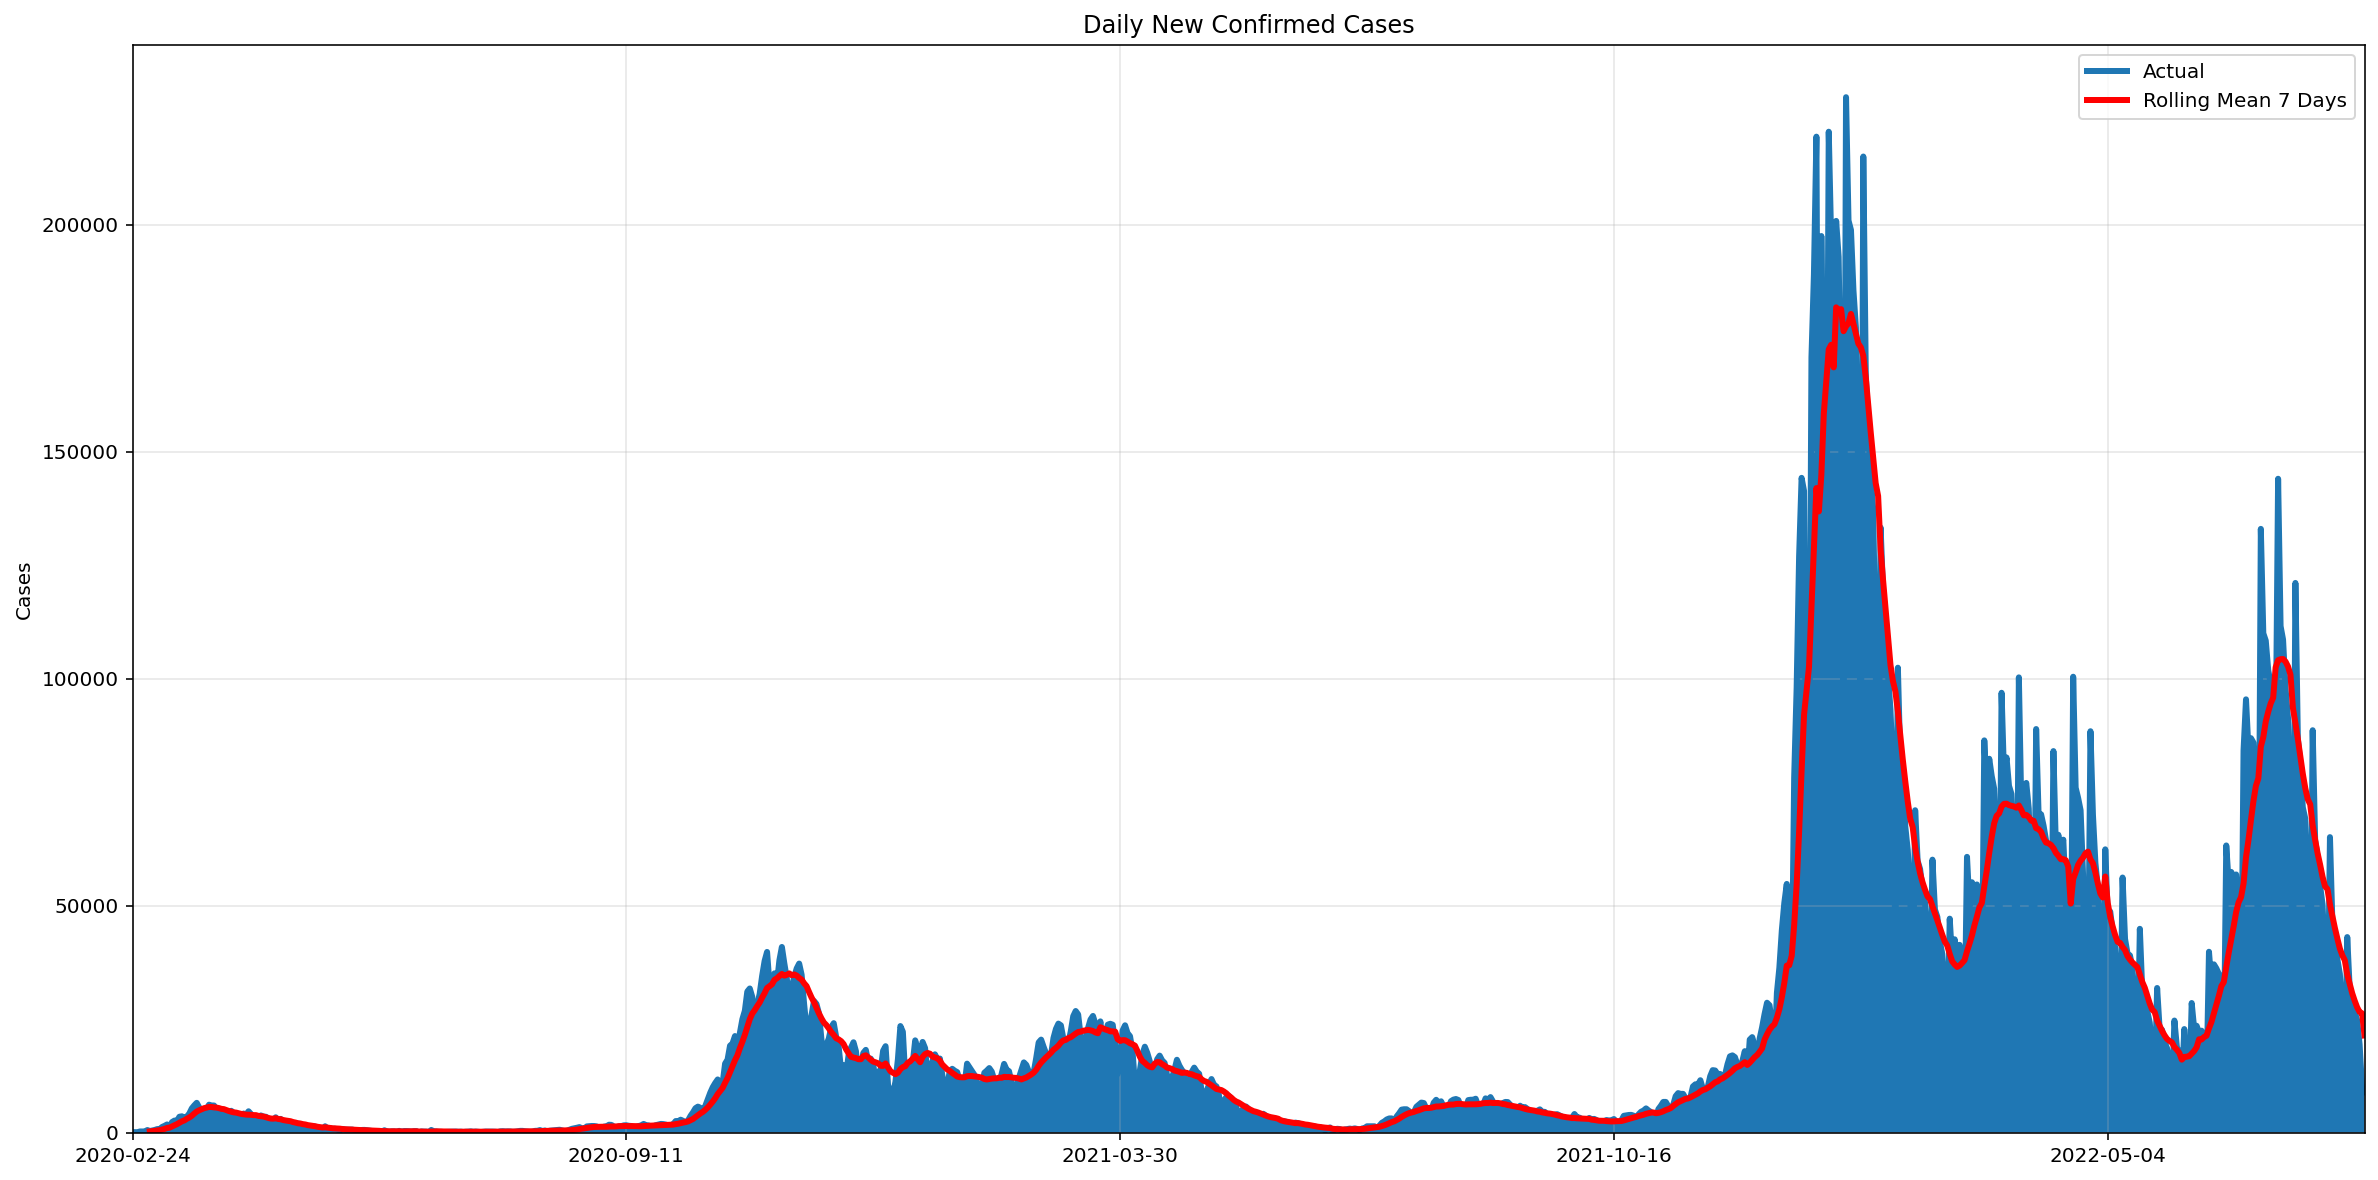

In [8]:
fig, ax = plt.subplots(figsize=(20,10))

ti.totale_casi.diff().plot(ax=ax, linewidth = 3, label = 'Actual')
ti.totale_casi.diff().rolling(7).mean().plot(ax=ax, c = 'r', linewidth = 3, label = 'Rolling Mean 7 Days')
_ = ax.fill_between(ti.totale_casi.diff().index, ti.totale_casi.diff())
_ = ax.legend()
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Cases')
_ = ax.set_title('Daily New Confirmed Cases')
_ = ax.set_xlim(0, len(ti)-1)
_ = ax.set_ylim(0)

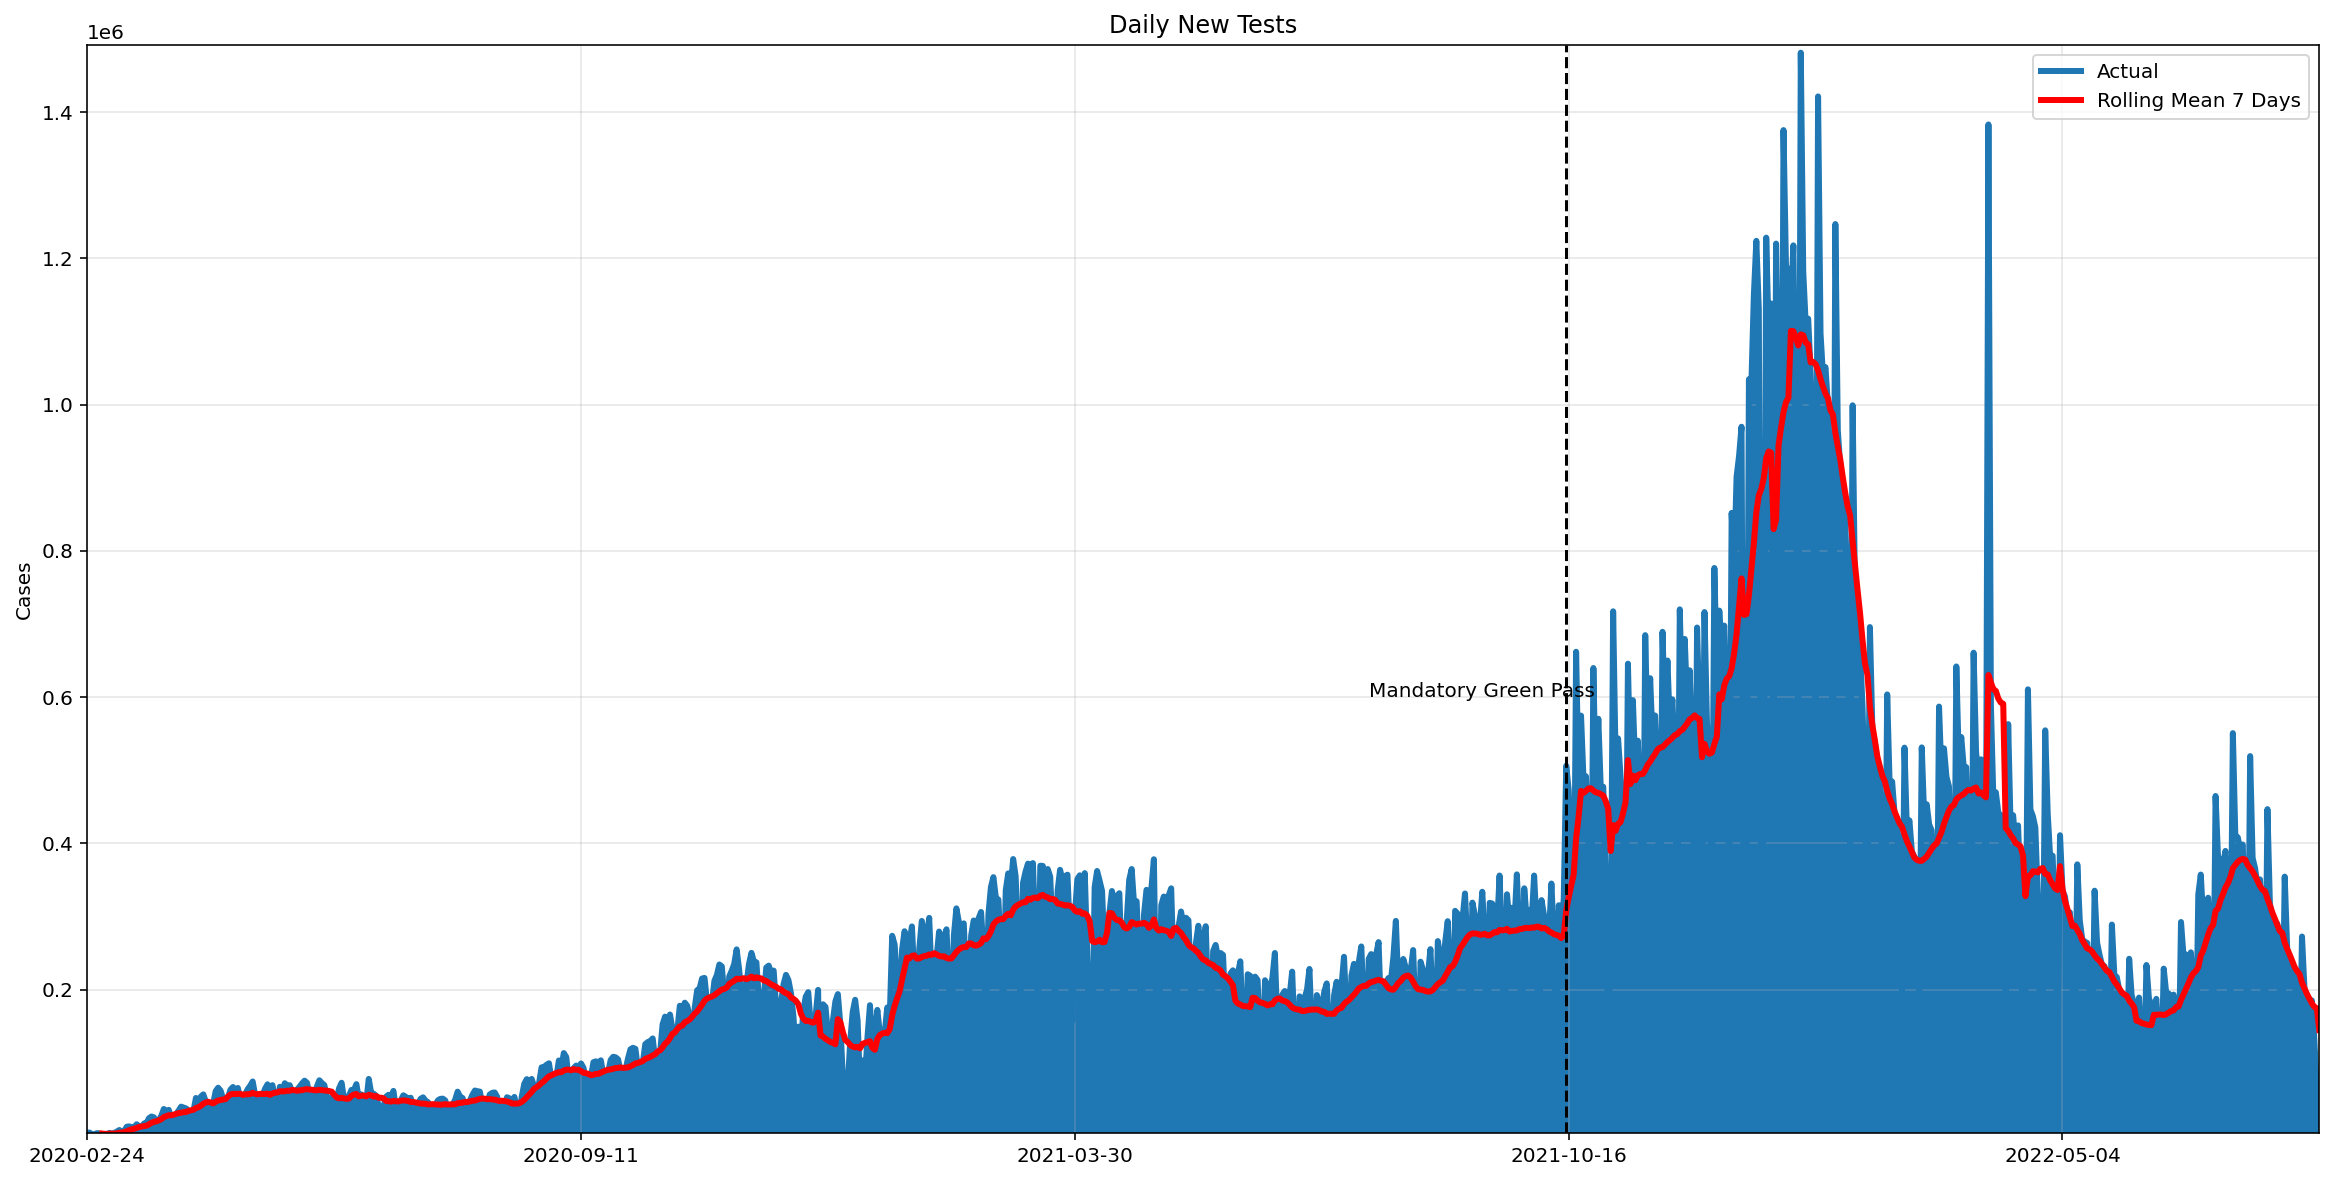

In [9]:
fig, ax = plt.subplots(figsize=(20,10))

mand_gp = (pd.to_datetime('2021-10-15') - pd.to_datetime(ti.index[0])).days

ti.diff_tamponi.plot(ax=ax, linewidth = 3, label = 'Actual')
ti.diff_tamponi.rolling(7).mean().plot(ax=ax, c = 'r', linewidth = 3, label = 'Rolling Mean 7 Days')
_ = ax.fill_between(ti.diff_tamponi.index, ti.diff_tamponi)
_ = ax.legend()
_ = ax.grid(alpha=.3)
_ = ax.axvline(mand_gp, c = 'k', linestyle = '--')
_ = ax.text(mand_gp - 80, 600000, 'Mandatory Green Pass')
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Cases')
_ = ax.set_title('Daily New Tests')
_ = ax.set_xlim(ti.diff_tamponi.index[0], ti.diff_tamponi.index[-1])
_ = ax.set_ylim(ti.diff_tamponi[0], ti.diff_tamponi.max() + 10000)
fig.savefig('Daily_tests.png')

#### 1. EDA ####

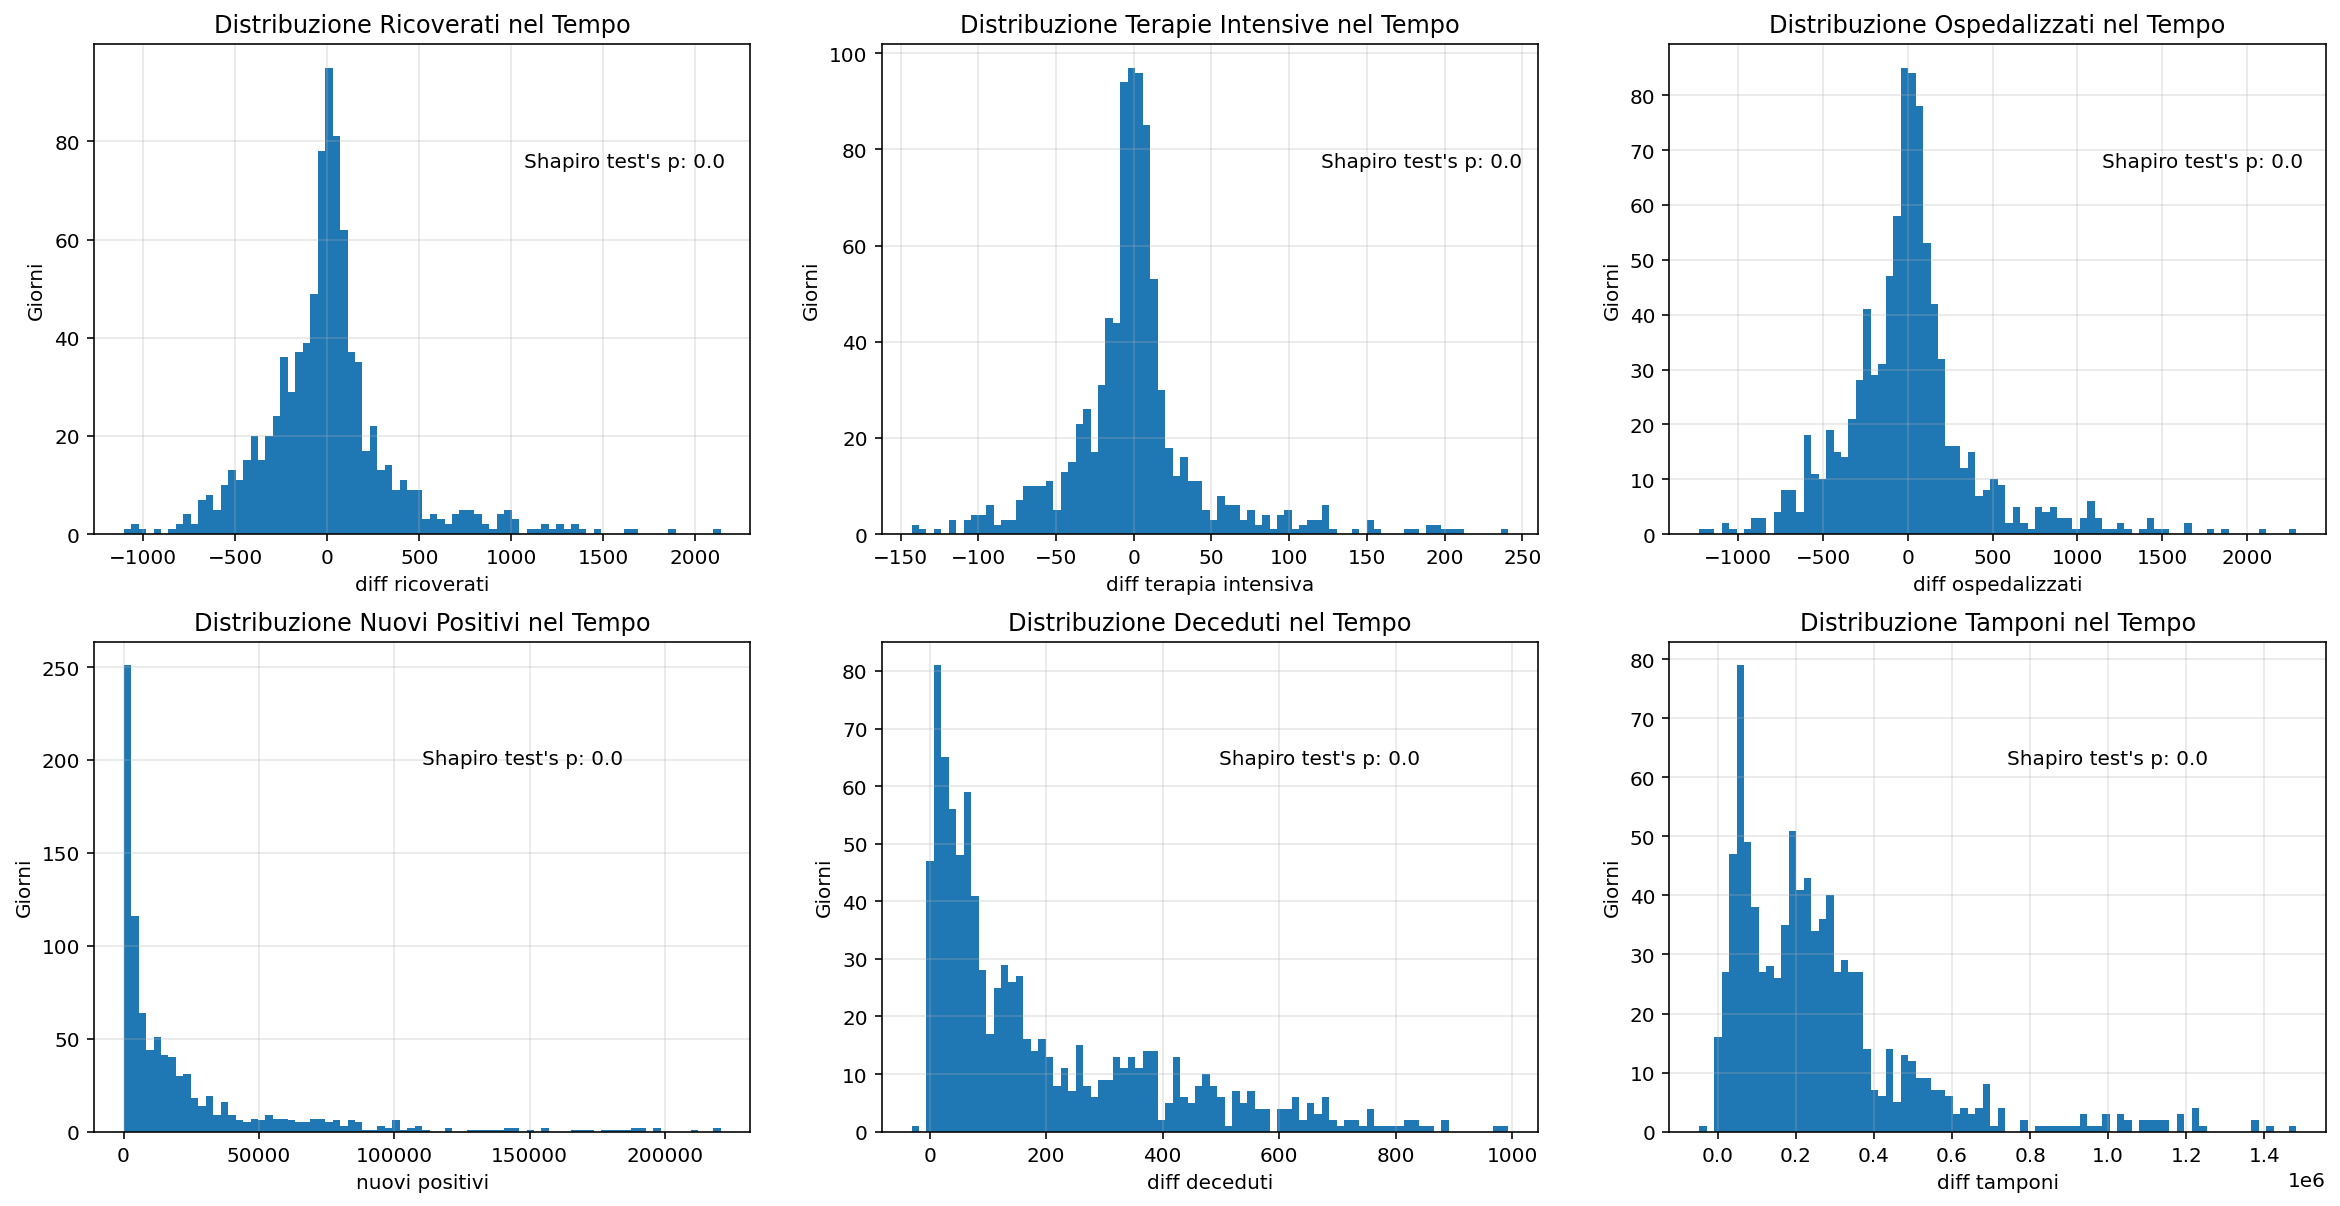

In [10]:
titles = ['Ricoverati', 'Terapie Intensive', 'Ospedalizzati', 'Nuovi Positivi', 'Deceduti', 'Tamponi']
fig, ax = plt.subplots(2,3, figsize=(20,10))

flax = ax.flatten()
for n, to_plot in enumerate(hists):
    _, p = ss.shapiro(ti[to_plot])
    ti[to_plot].hist(ax = flax[n], bins = 80)
    ylim = flax[n].get_ylim()
    _ = flax[n].grid(alpha = .3)
    _ = flax[n].set_ylabel('Giorni')
    _ = flax[n].set_xlabel(to_plot.replace('_', ' '))
    _ = flax[n].set_title(f'Distribuzione {titles[n]} nel Tempo')
    _ = flax[n].text(ti[to_plot].max() - ti[to_plot].max() / 2, ylim[1] - ylim[1] / 4, f'Shapiro test\'s p: {round(p, 6)}')

_ = fig.subplots_adjust(hspace=.22)

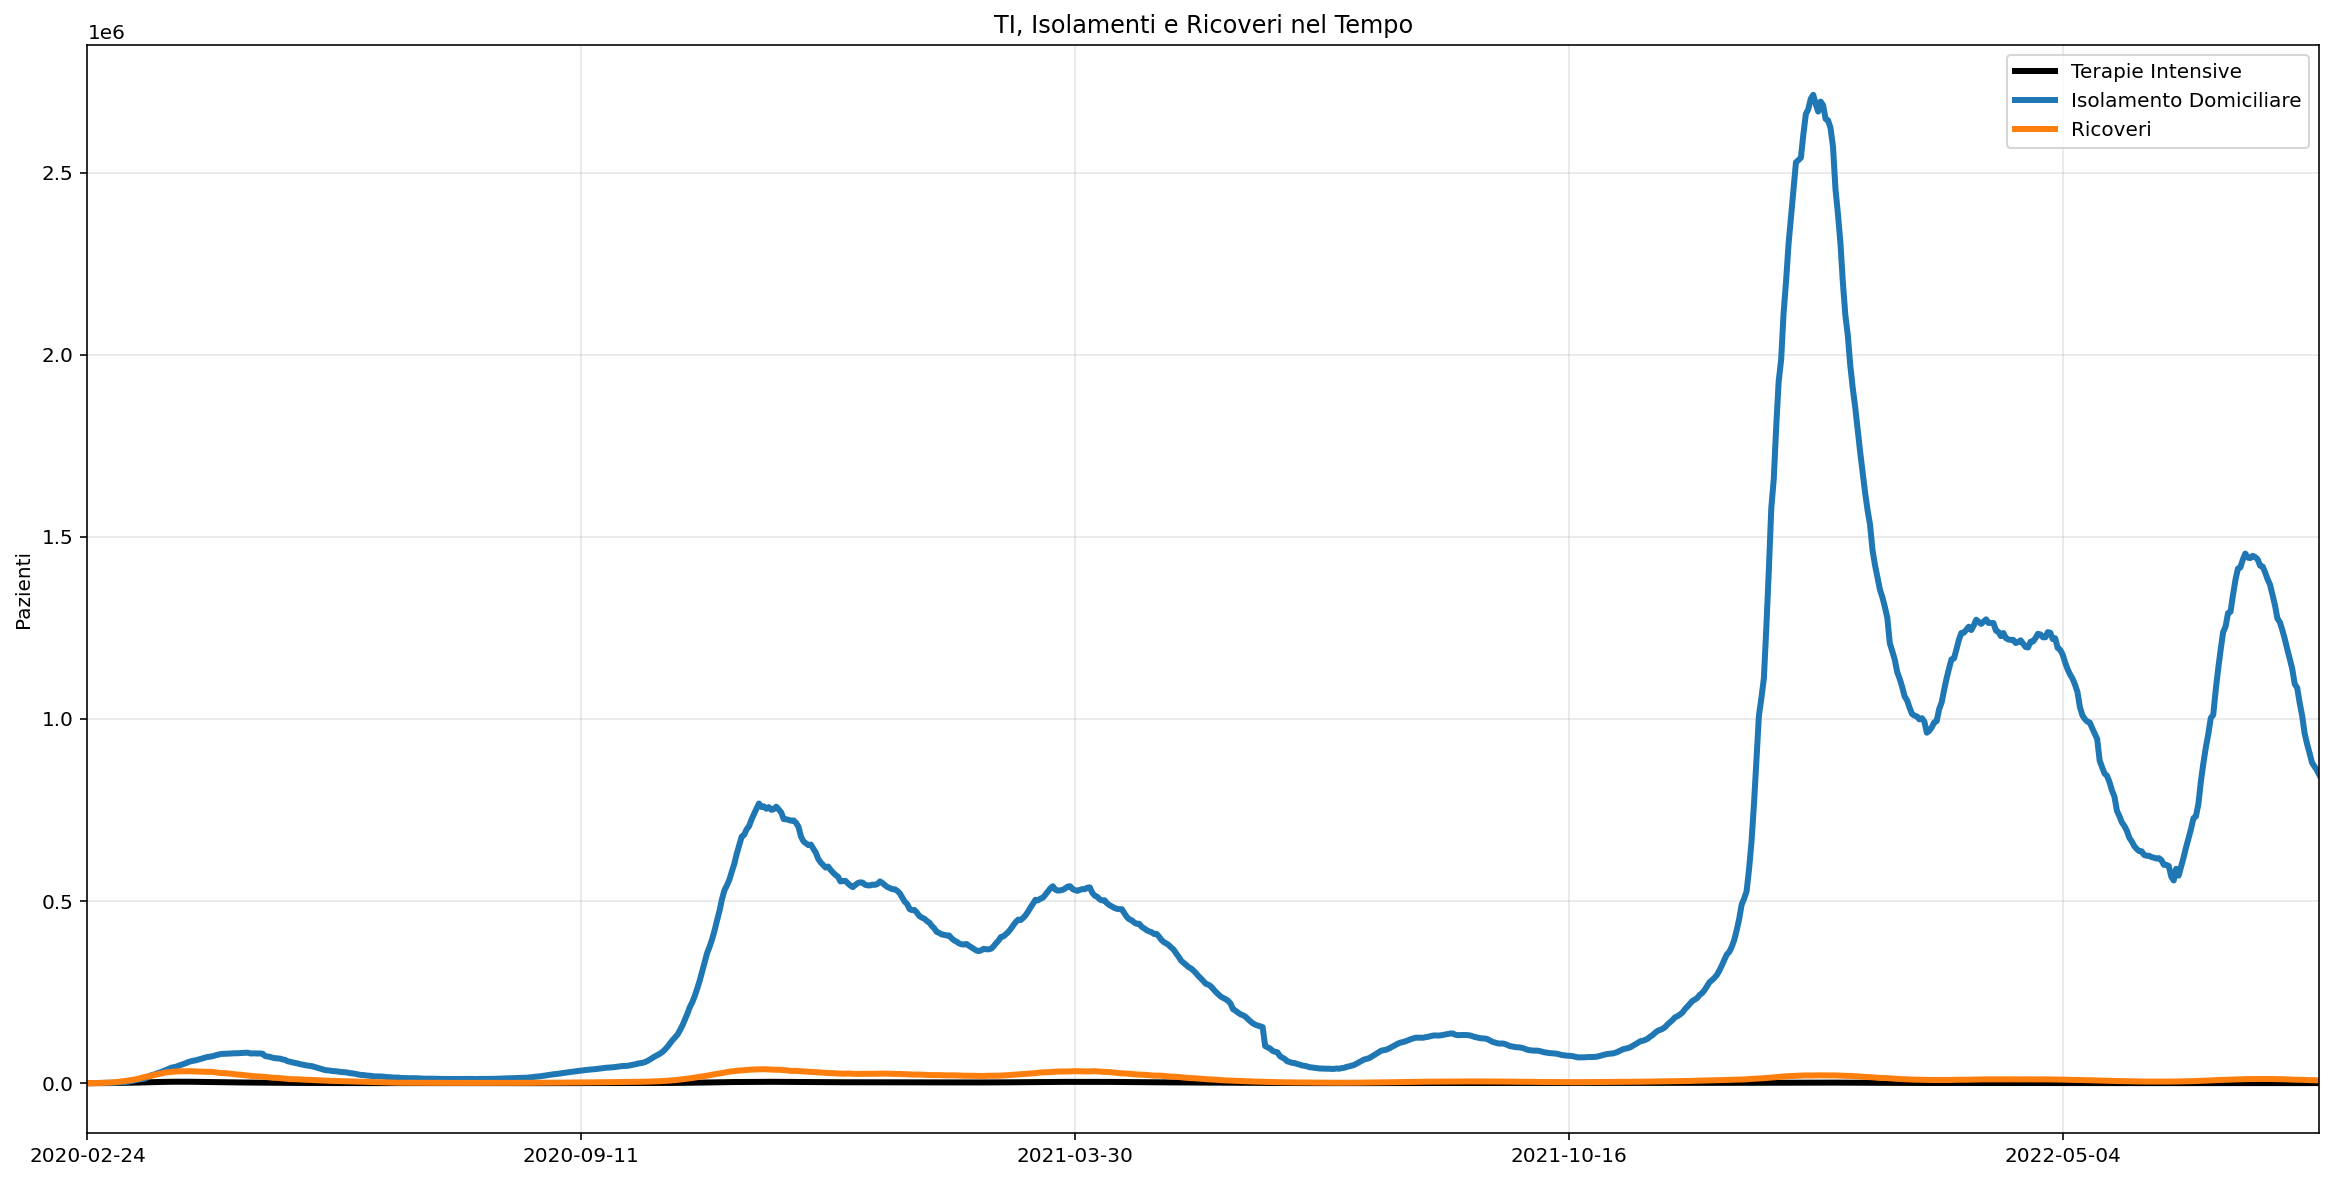

In [11]:
fig, ax = plt.subplots(figsize = (20,10))

ti.terapia_intensiva.plot(ax = ax, c = 'k', linewidth = 3, label = 'Terapie Intensive')
ti.isolamento_domiciliare.plot(ax = ax, linewidth = 3, label = 'Isolamento Domiciliare')
ti.ospedalizzati.plot(ax = ax, linewidth = 3, label = 'Ricoveri')
_ = ax.legend()
_ = ax.grid(alpha = .3)
_ = ax.set_ylabel('Pazienti')
_ = ax.set_xlabel('')
_ = ax.set_title('TI, Isolamenti e Ricoveri nel Tempo')
_ = ax.set_xlim(0, len(ti)-1)

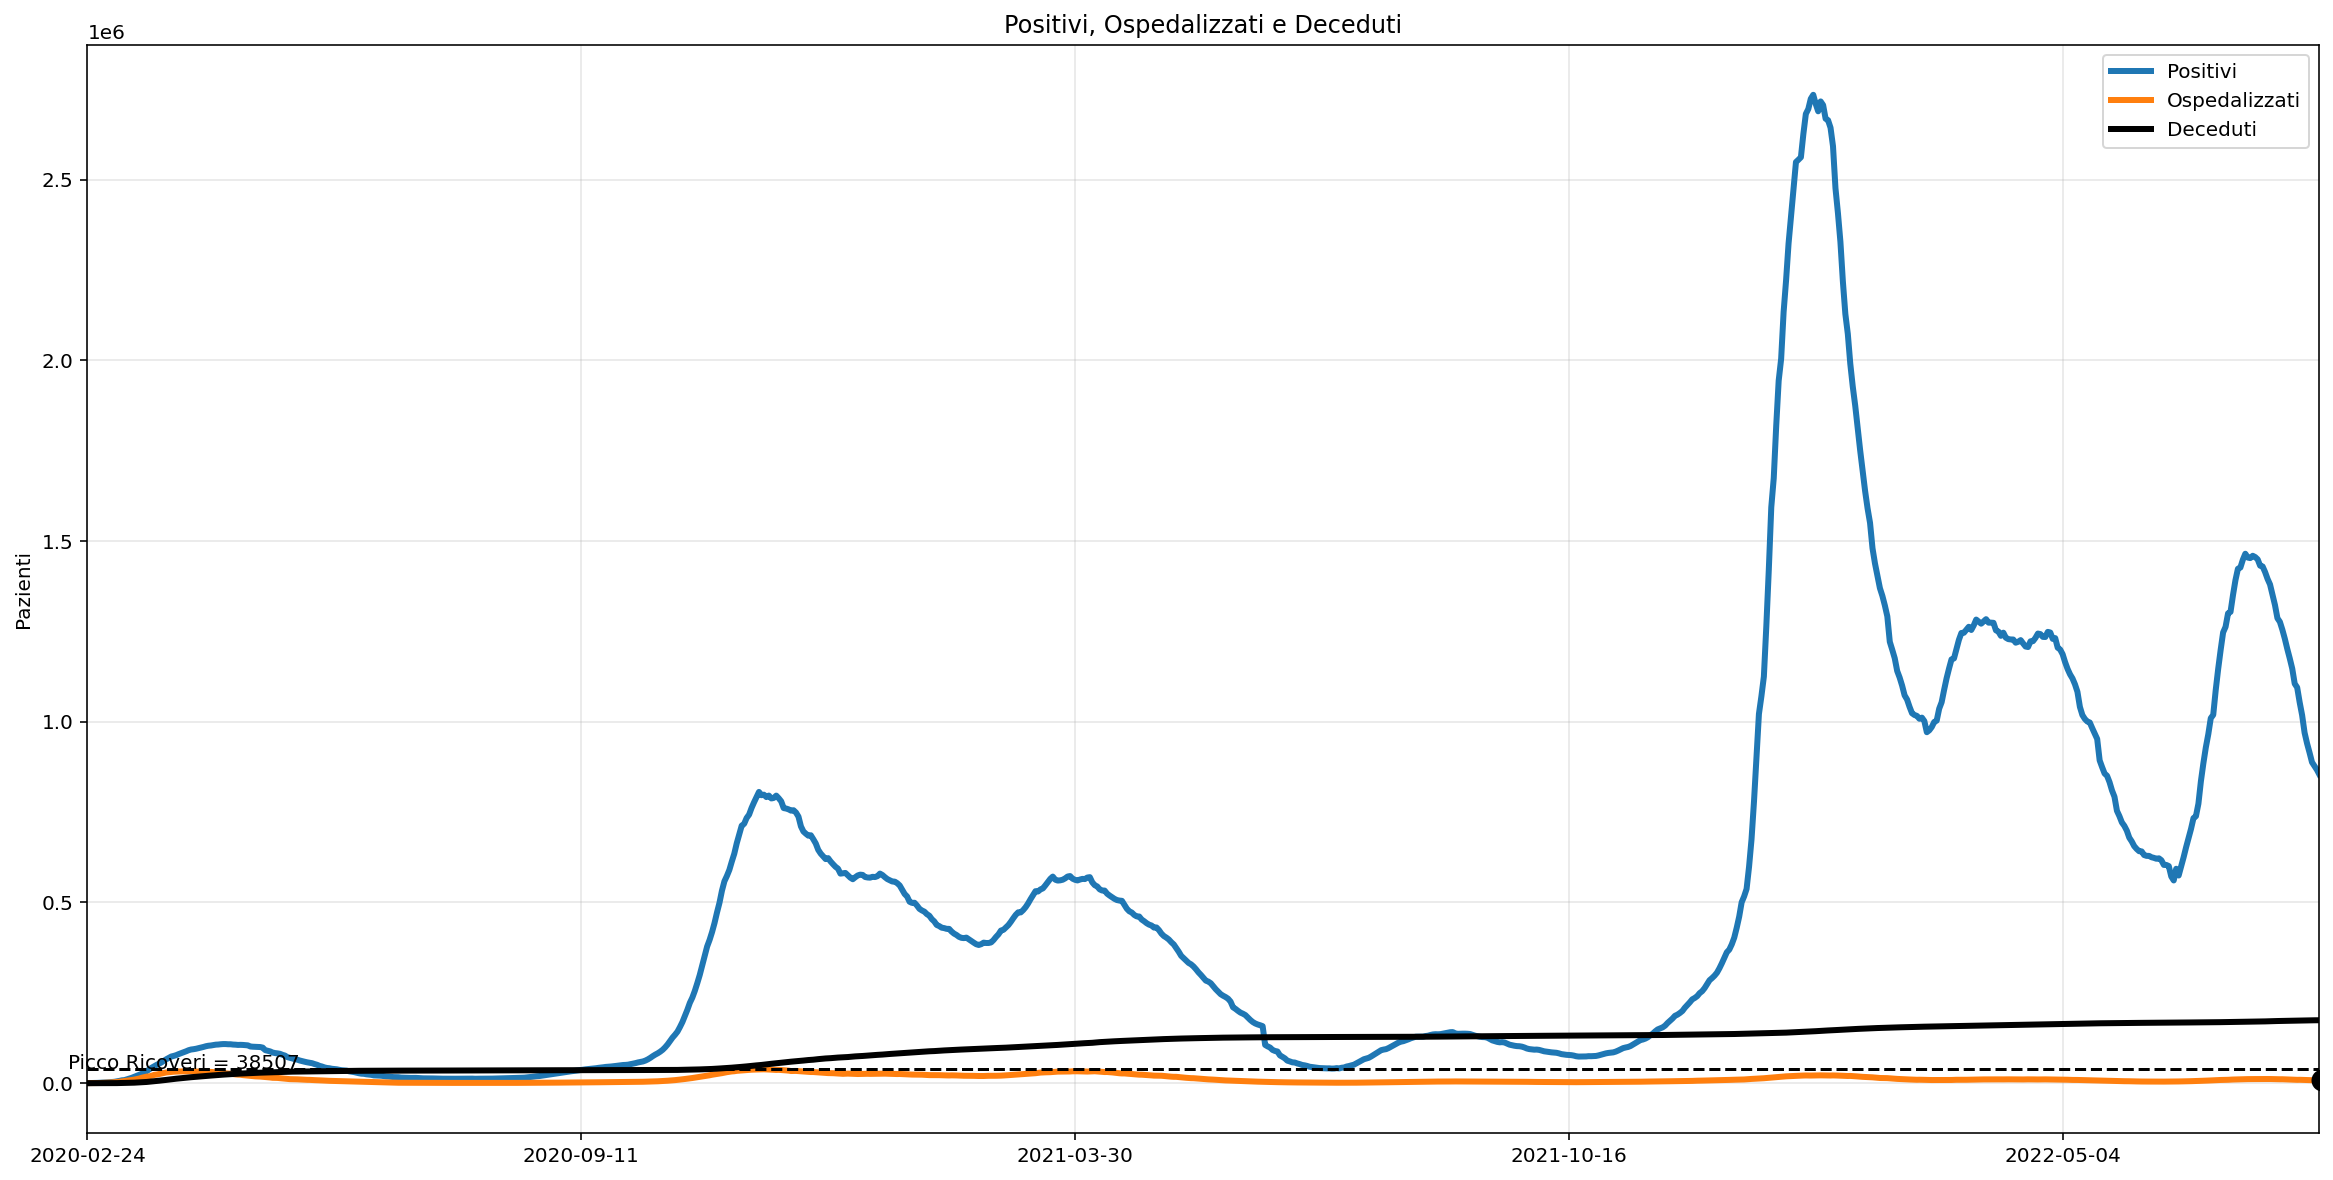

In [12]:
fig, ax = plt.subplots(figsize = (20,10))

ti.totale_positivi.plot(ax = ax, linewidth = 3, label = 'Positivi')
ti.ospedalizzati.plot(ax = ax, linewidth = 3, label = 'Ospedalizzati')
ti.deceduti.plot(ax = ax, c = 'k', linewidth = 3, label = 'Deceduti')
_ = ax.legend()
_ = ax.grid(alpha = .3)
_ = ax.set_ylabel('Pazienti')
_ = ax.set_xlabel('')
_ = ax.set_title('Positivi, Ospedalizzati e Deceduti')
_ = ax.axhline(max(ti.ospedalizzati), c = 'k', linestyle = '--')
_ = ax.scatter(len(ti.index), ti.ospedalizzati[-1], c = 'k', s = 100, zorder = 3)
_ = ax.text(-8, max_ric+2000, f'Picco Ricoveri = {max_ric}')
_ = ax.set_xlim(0, len(ti)-1)

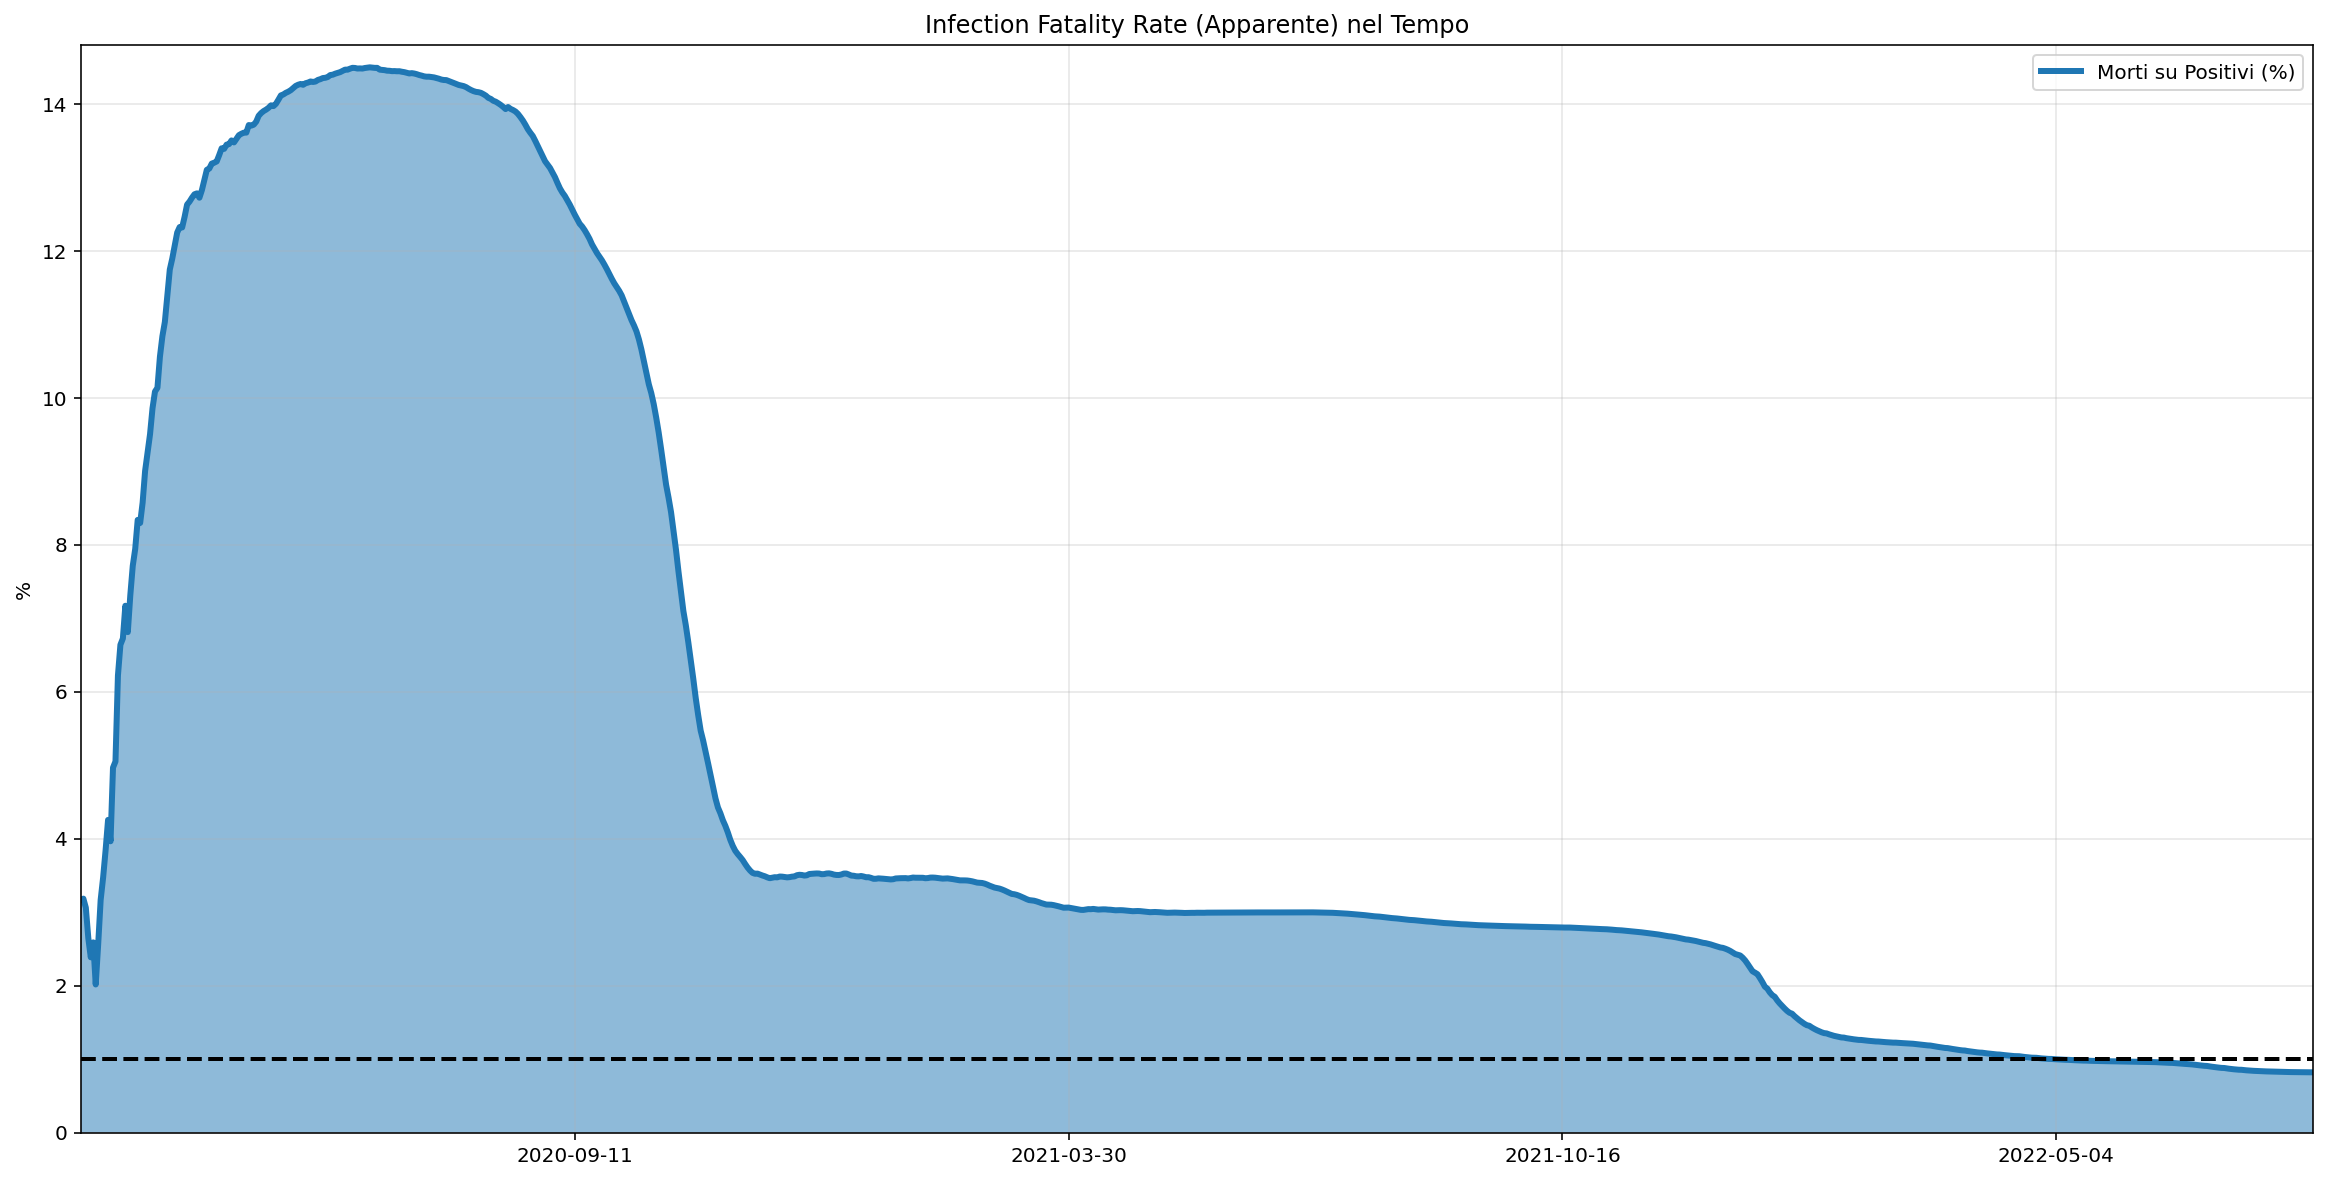

In [13]:
ti['Fatality'] = (ti.deceduti / np.cumsum(ti.nuovi_positivi)) * 100
# ti['ti_rate'] = (np.cumsum(ti.terapia_intensiva) / np.cumsum(ti.nuovi_positivi)) * 100

fig, ax = plt.subplots(figsize = (20,10))
ti.Fatality.plot(ax = ax, linewidth = 3, label = 'Morti su Positivi (%)')
_ = ax.fill_between(ti.Fatality.index, ti.Fatality, alpha = .5)
_ = ax.legend()
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('%')
_ = ax.set_title('Infection Fatality Rate (Apparente) nel Tempo')
_ = ax.set_xlim(.05, (pd.to_datetime(ti.index[-1]) - pd.to_datetime(ti.index[0])).days)
_ = ax.set_ylim(0, 14.8)
_ = ax.axhline(1, linewidth=2, c="k", linestyle="--")

C:\Users\ttommasini\AppData\Local\Temp\ipykernel_22036\791569072.py:16: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  _ = ax.axvline(drate.reset_index()[drate.index=="2021-12-01"].index, c="k", linestyle="--", linewidth=2)


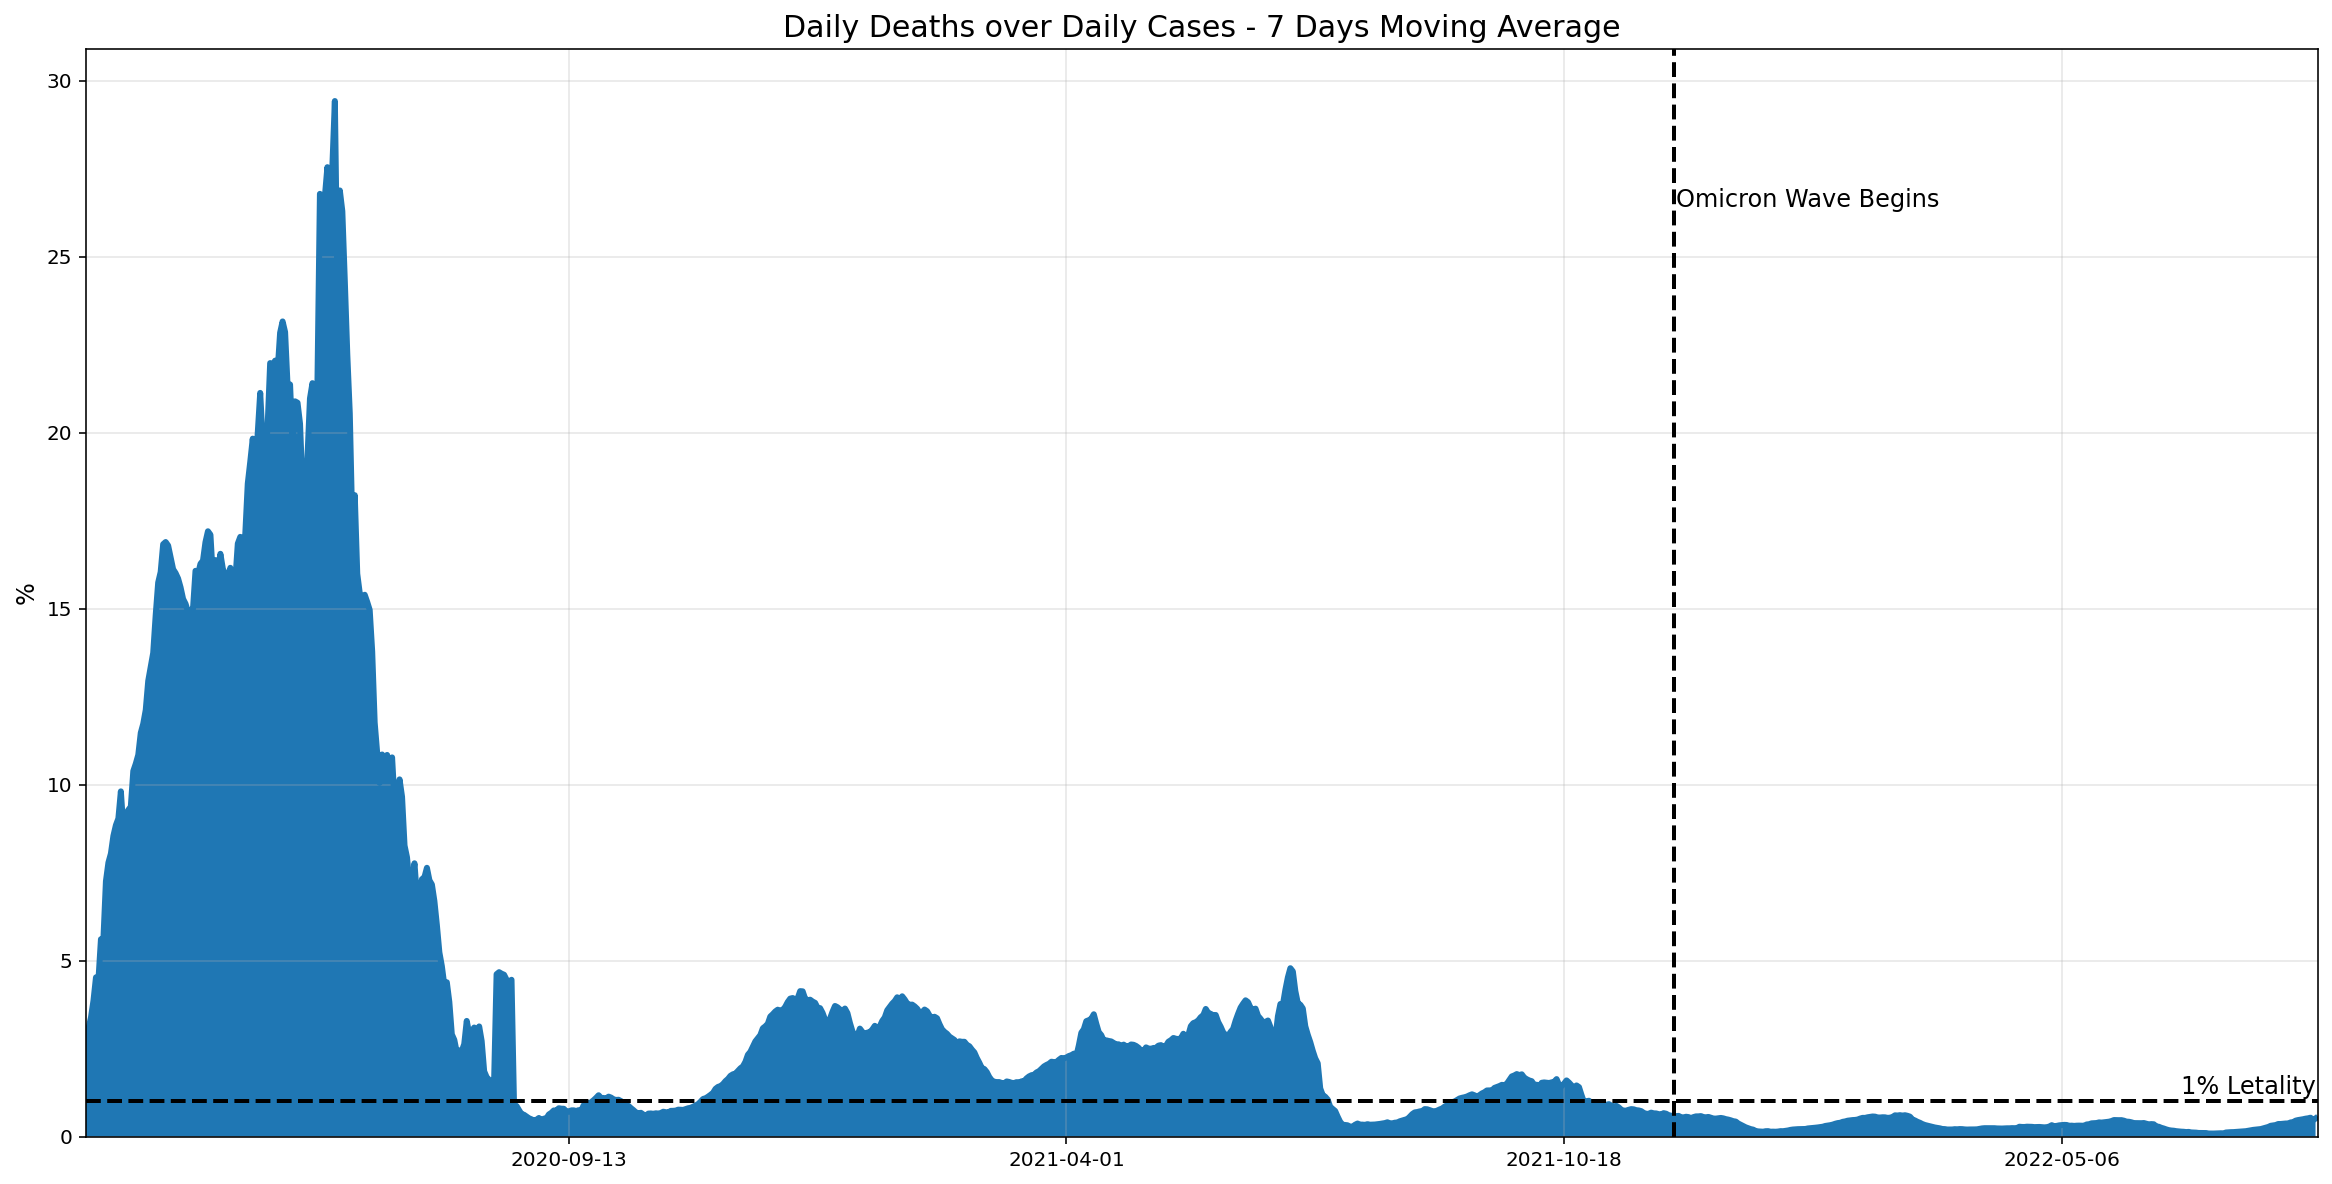

In [14]:
fig, ax = plt.subplots(figsize=(20,10))

st = "1% Letality"
drate = ti.deceduti.diff()[ti.deceduti.diff()>0] / ti.nuovi_positivi[ti.deceduti.diff()>0] * 100
# drate.plot(ax=ax, linewidth=3)
drate.rolling(7).mean().plot(linewidth=3, ax=ax)
_ = ax.grid(alpha=.3)
_ = ax.set_ylim(0)
_ = ax.set_xlim(drate.rolling(7).mean().reset_index().index[0]+6, len(drate))
_ = ax.fill_between(drate.rolling(7).mean().index, drate.rolling(7).mean())
_ = ax.axhline(1, c="k", linestyle="--", linewidth=2)
_ = ax.text(len(drate)-5*len(st), 1.2, st, fontsize=12)
_ = ax.set_ylabel("%", fontsize=12)
_ = ax.set_xlabel("")
_ = ax.set_title("Daily Deaths over Daily Cases - 7 Days Moving Average", fontsize=15)
_ = ax.axvline(drate.reset_index()[drate.index=="2021-12-01"].index, c="k", linestyle="--", linewidth=2)
_ = ax.text(
    drate.reset_index()[drate.index=="2021-12-01"].index[0]+1, 
    drate.rolling(7).mean().max()-3, "Omicron Wave Begins", fontsize=12
)

C:\Users\ttommasini\AppData\Local\Temp\ipykernel_22036\2963668083.py:16: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  _ = ax.axvline(drate.reset_index()[drate.index=="2021-12-01"].index, c="k", linestyle="--", linewidth=2)


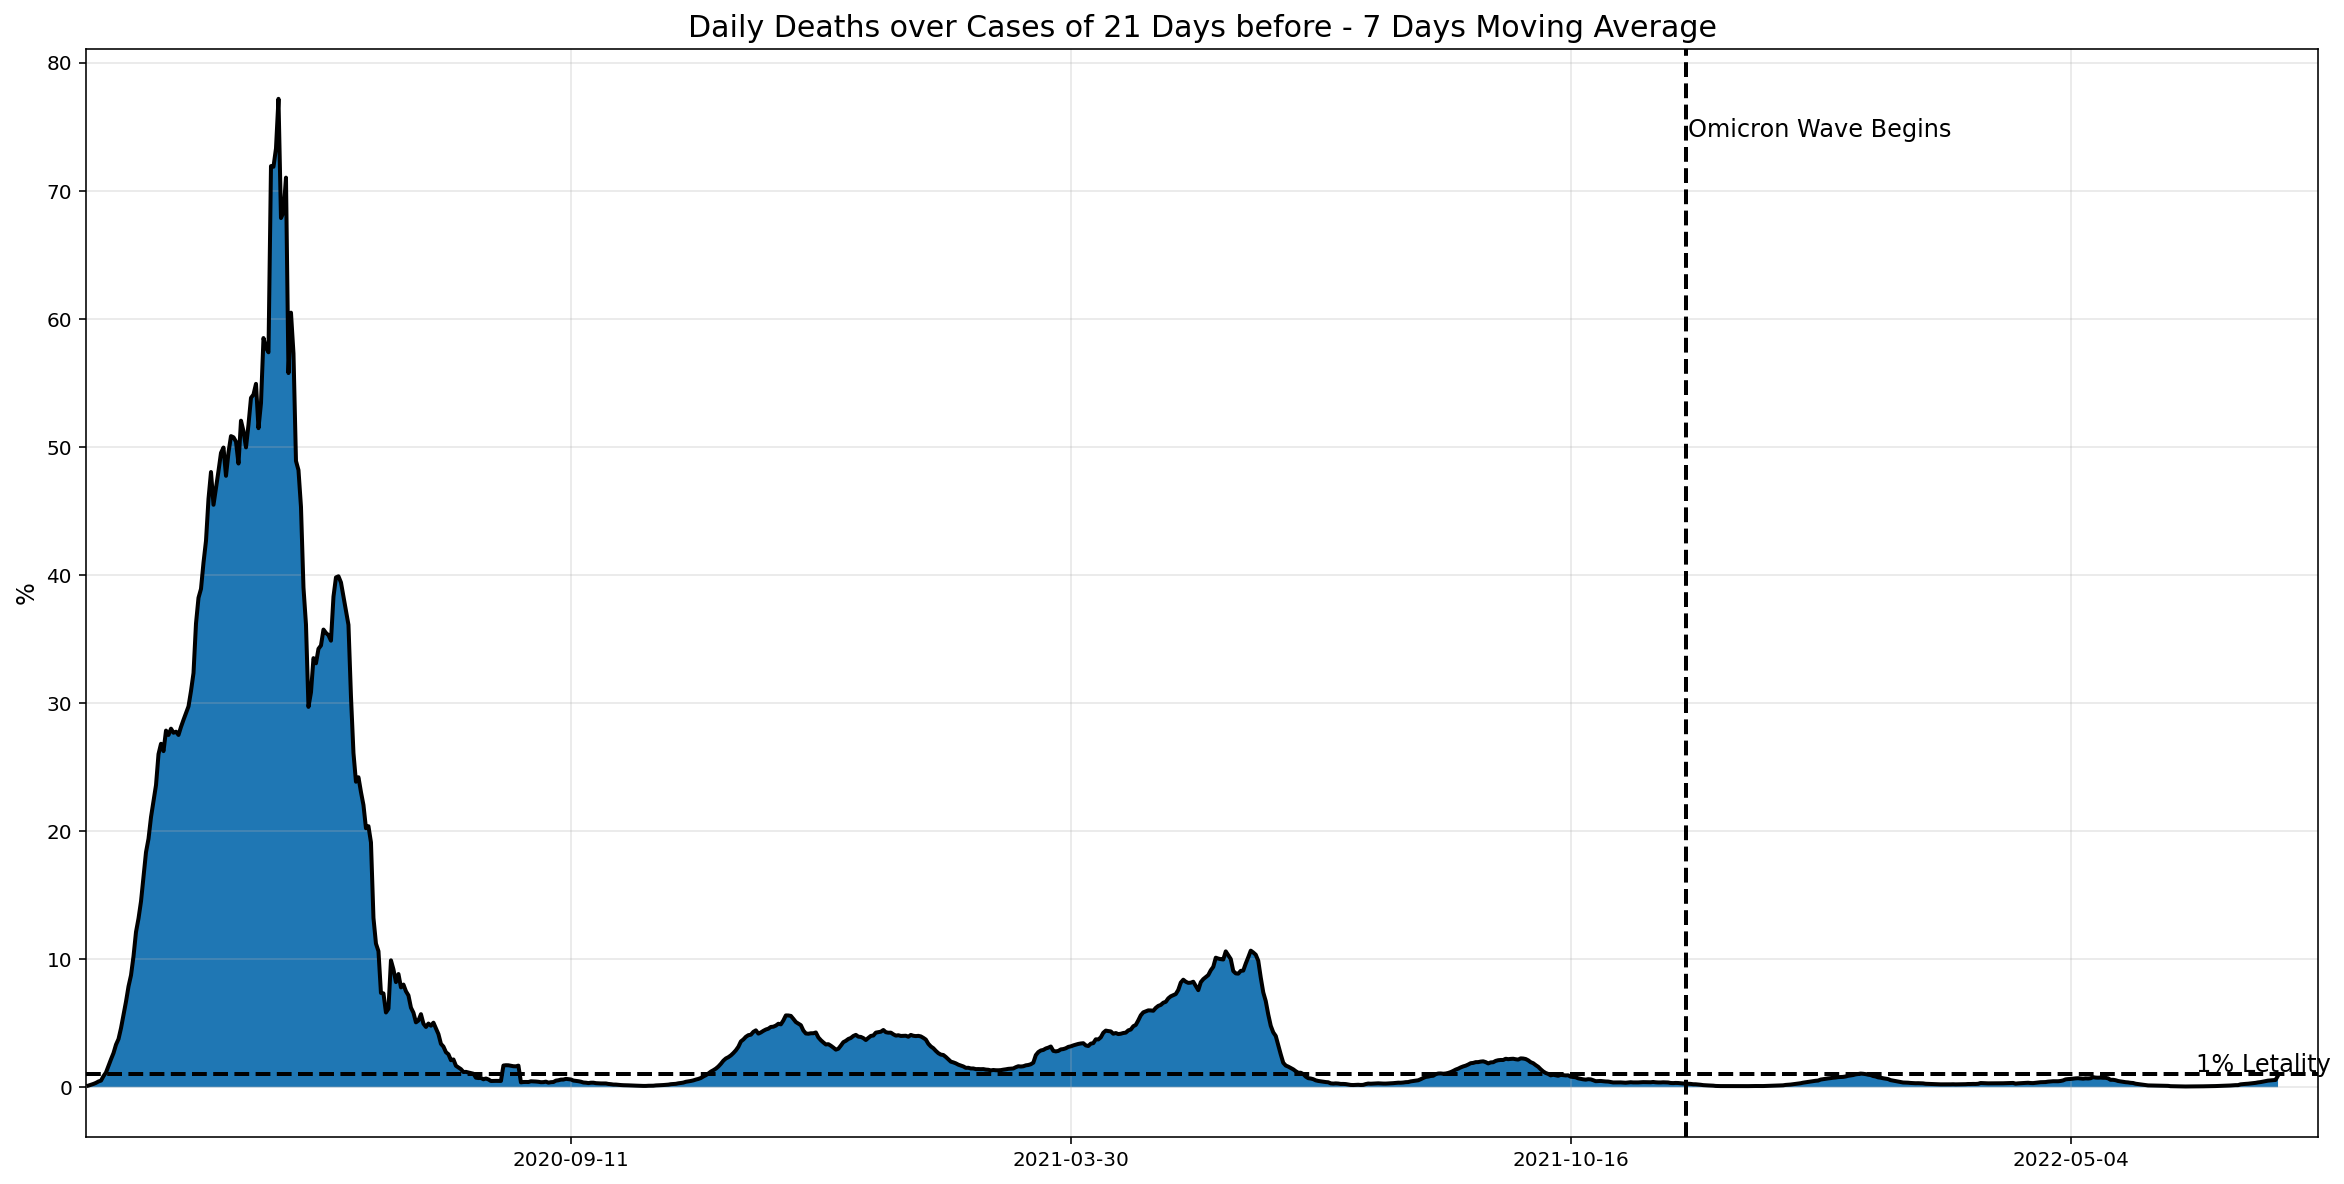

In [15]:
fig, ax = plt.subplots(figsize=(20,10))

st = "1% Letality"
drate = ti.deceduti.diff() / ti.nuovi_positivi.shift(-21) * 100
# drate.plot(ax=ax, linewidth=3)
drate.rolling(7).mean().plot(linewidth=2, ax=ax, c="k")
_ = ax.grid(alpha=.3)
# _ = ax.set_ylim(21)
_ = ax.set_xlim(drate.rolling(7).mean().reset_index().index[0]+6, len(drate)-6)
_ = ax.fill_between(drate.rolling(7).mean().index, drate.rolling(7).mean())
_ = ax.axhline(1, c="k", linestyle="--", linewidth=2)
_ = ax.text(len(drate)-5*len(st), 1.2, st, fontsize=12)
_ = ax.set_ylabel("%", fontsize=12)
_ = ax.set_xlabel("")
_ = ax.set_title("Daily Deaths over Cases of 21 Days before - 7 Days Moving Average", fontsize=15)
_ = ax.axvline(drate.reset_index()[drate.index=="2021-12-01"].index, c="k", linestyle="--", linewidth=2)
_ = ax.text(
    drate.reset_index()[drate.index=="2021-12-01"].index[0]+1, 
    drate.rolling(7).mean().max()-3, "Omicron Wave Begins", fontsize=12
)

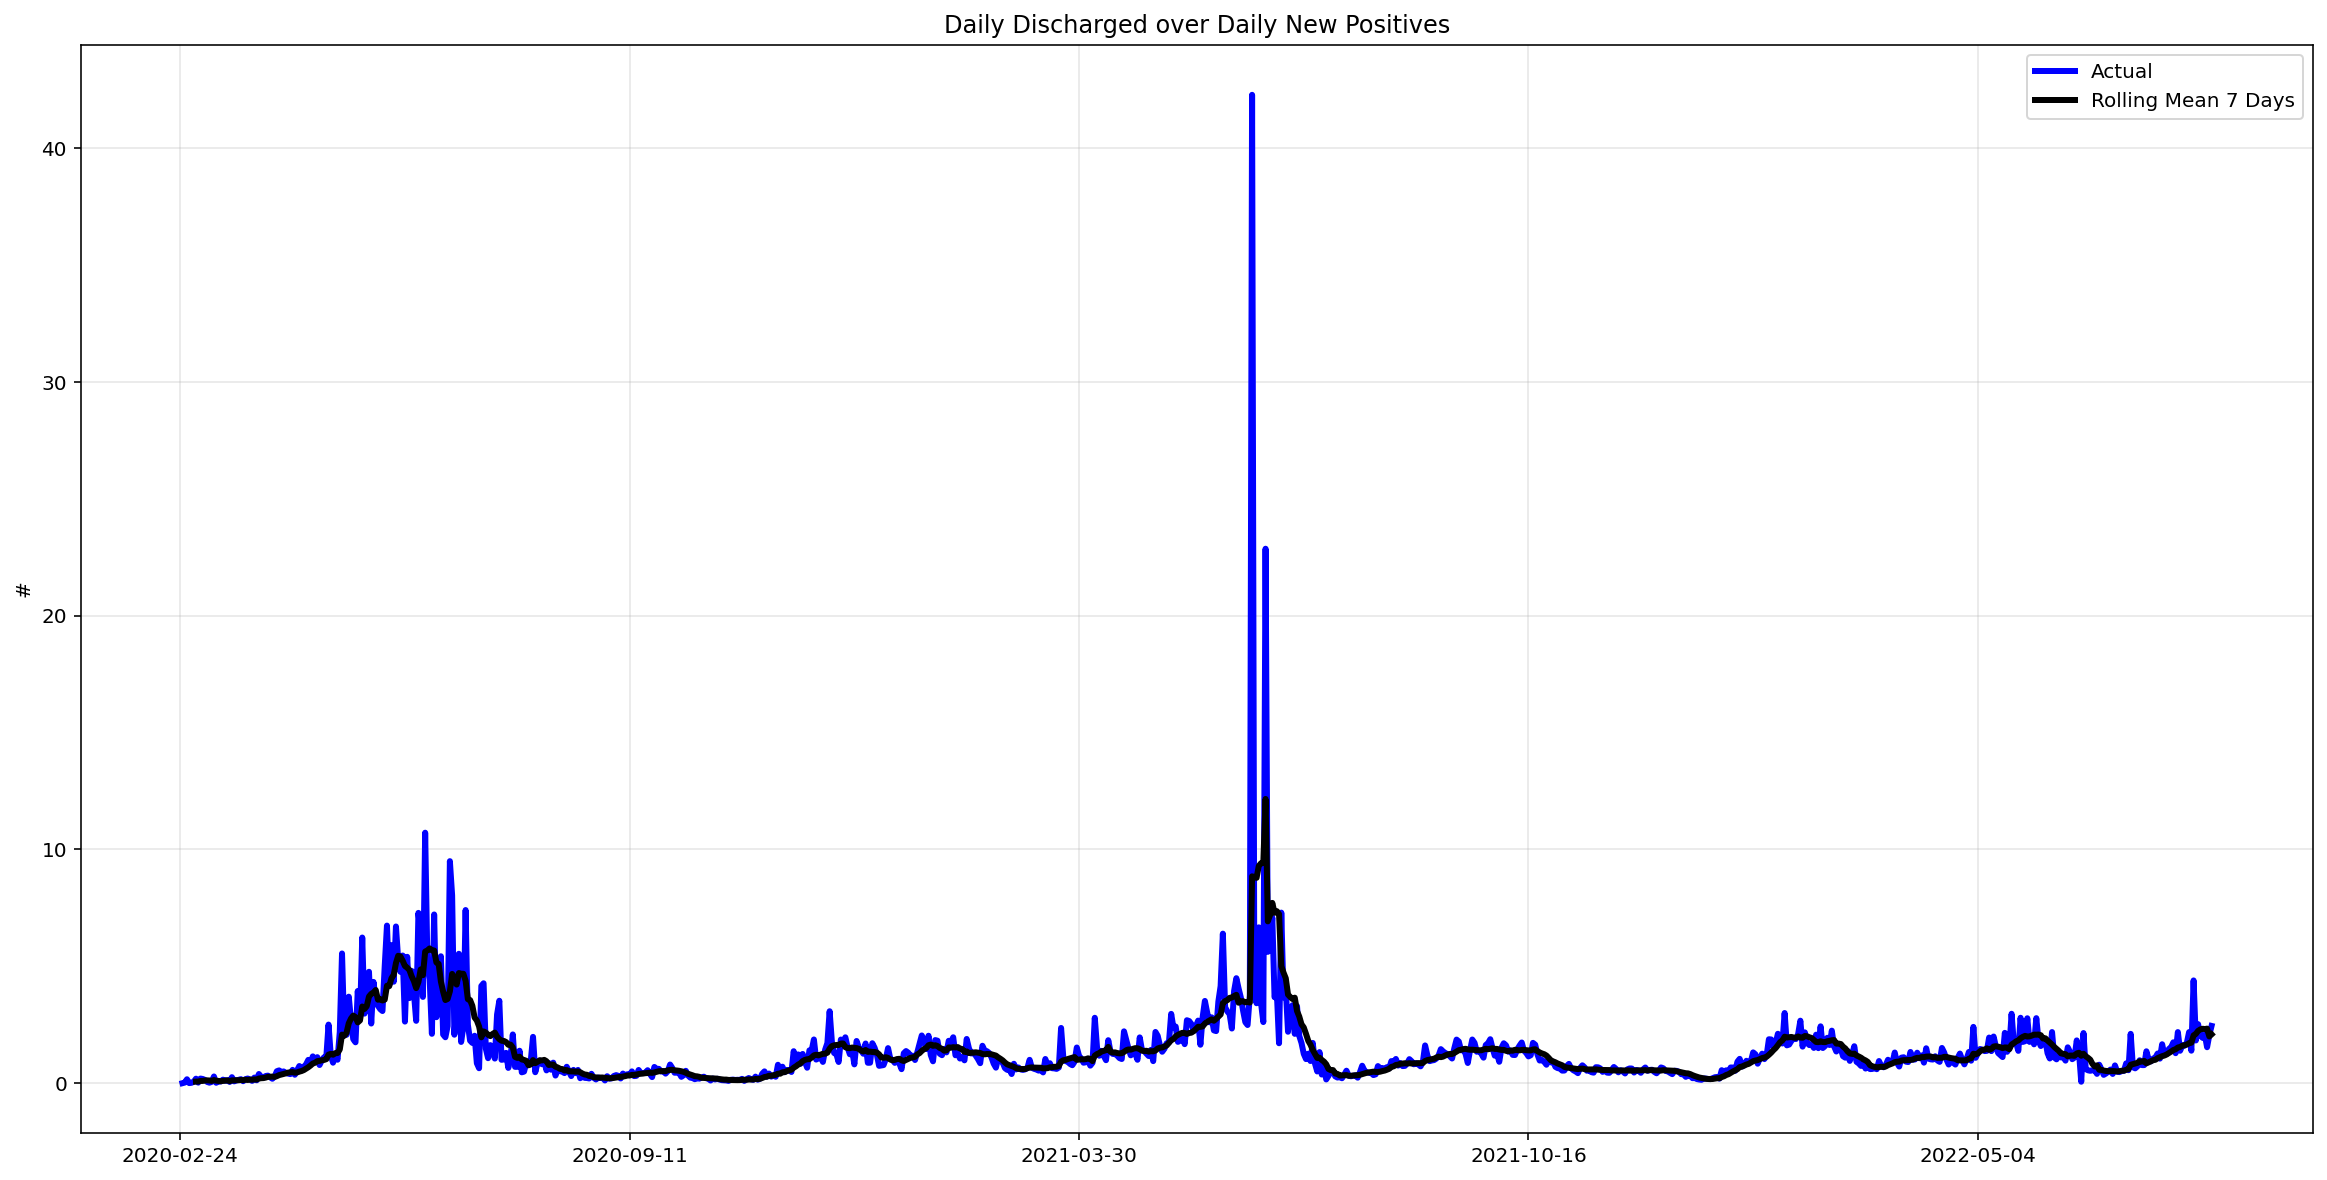

In [16]:
ti['g_over_p'] = (ti.guariti.diff() / ti.nuovi_positivi)

fig, ax = plt.subplots(figsize = (20,10))

ti.g_over_p.plot(ax = ax, linewidth = 3, label = 'Actual', c = 'b')
ti.g_over_p.rolling(7).mean().plot(ax = ax, linewidth = 3, label = 'Rolling Mean 7 Days', c = 'k')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlabel('')
_ = ax.set_ylabel('#')
_ = ax.set_title('Daily Discharged over Daily New Positives')

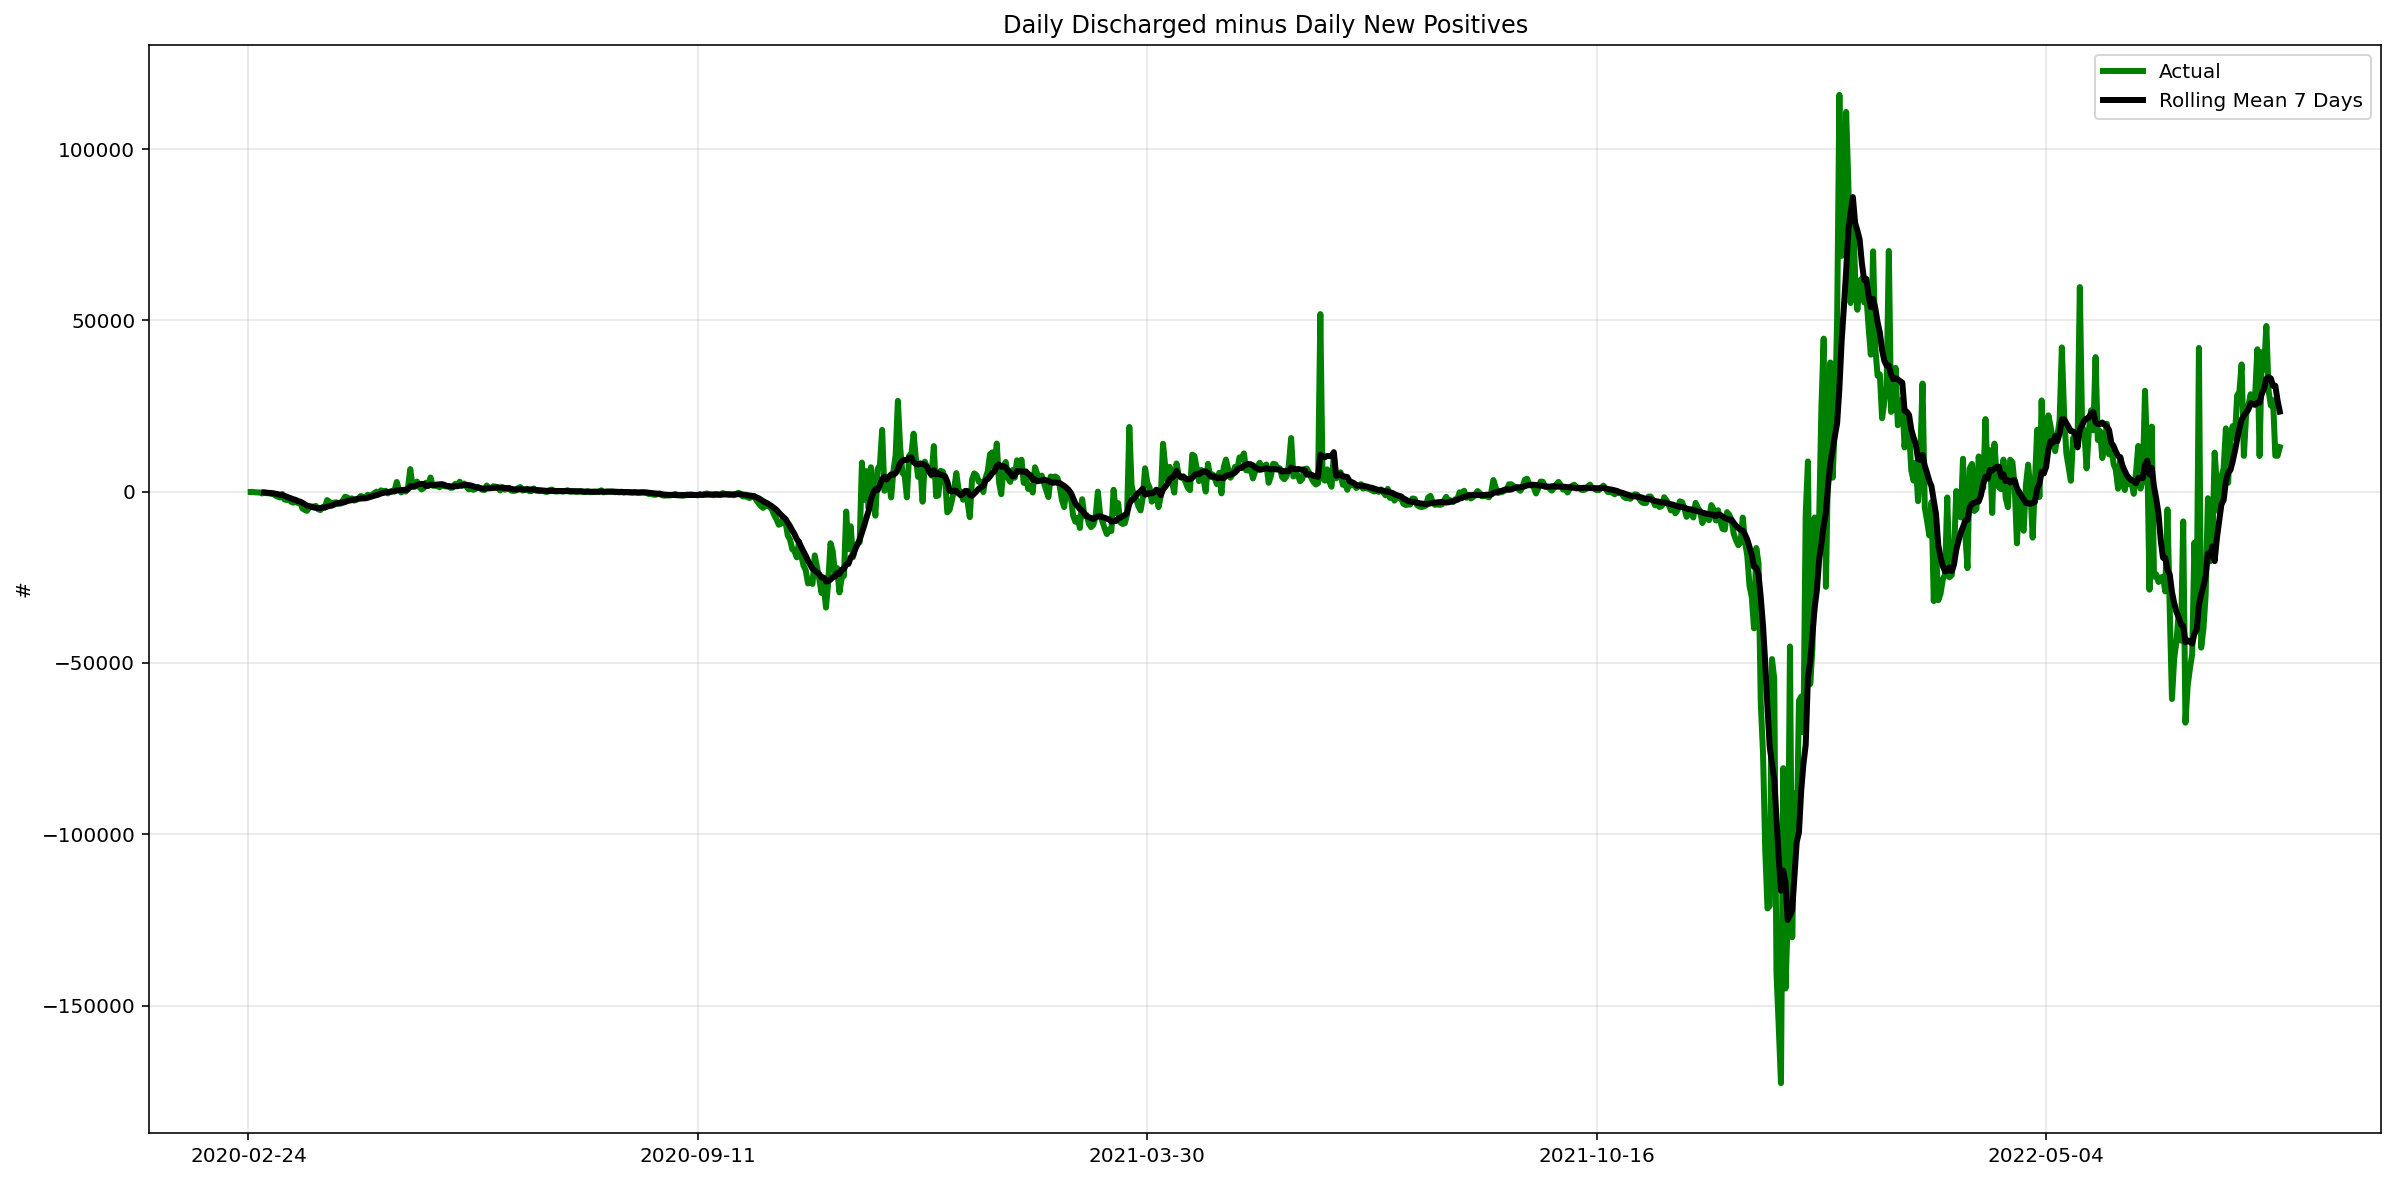

In [17]:
ti['g_minus_p'] = (ti.guariti.diff() - ti.nuovi_positivi)# * 100

fig, ax = plt.subplots(figsize = (20,10))

ti.g_minus_p.plot(ax = ax, linewidth = 3, label = 'Actual', c = 'g')
ti.g_minus_p.rolling(7).mean().plot(ax = ax, linewidth = 3, label = 'Rolling Mean 7 Days', c = 'k')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlabel('')
_ = ax.set_ylabel('#')
_ = ax.set_title('Daily Discharged minus Daily New Positives')

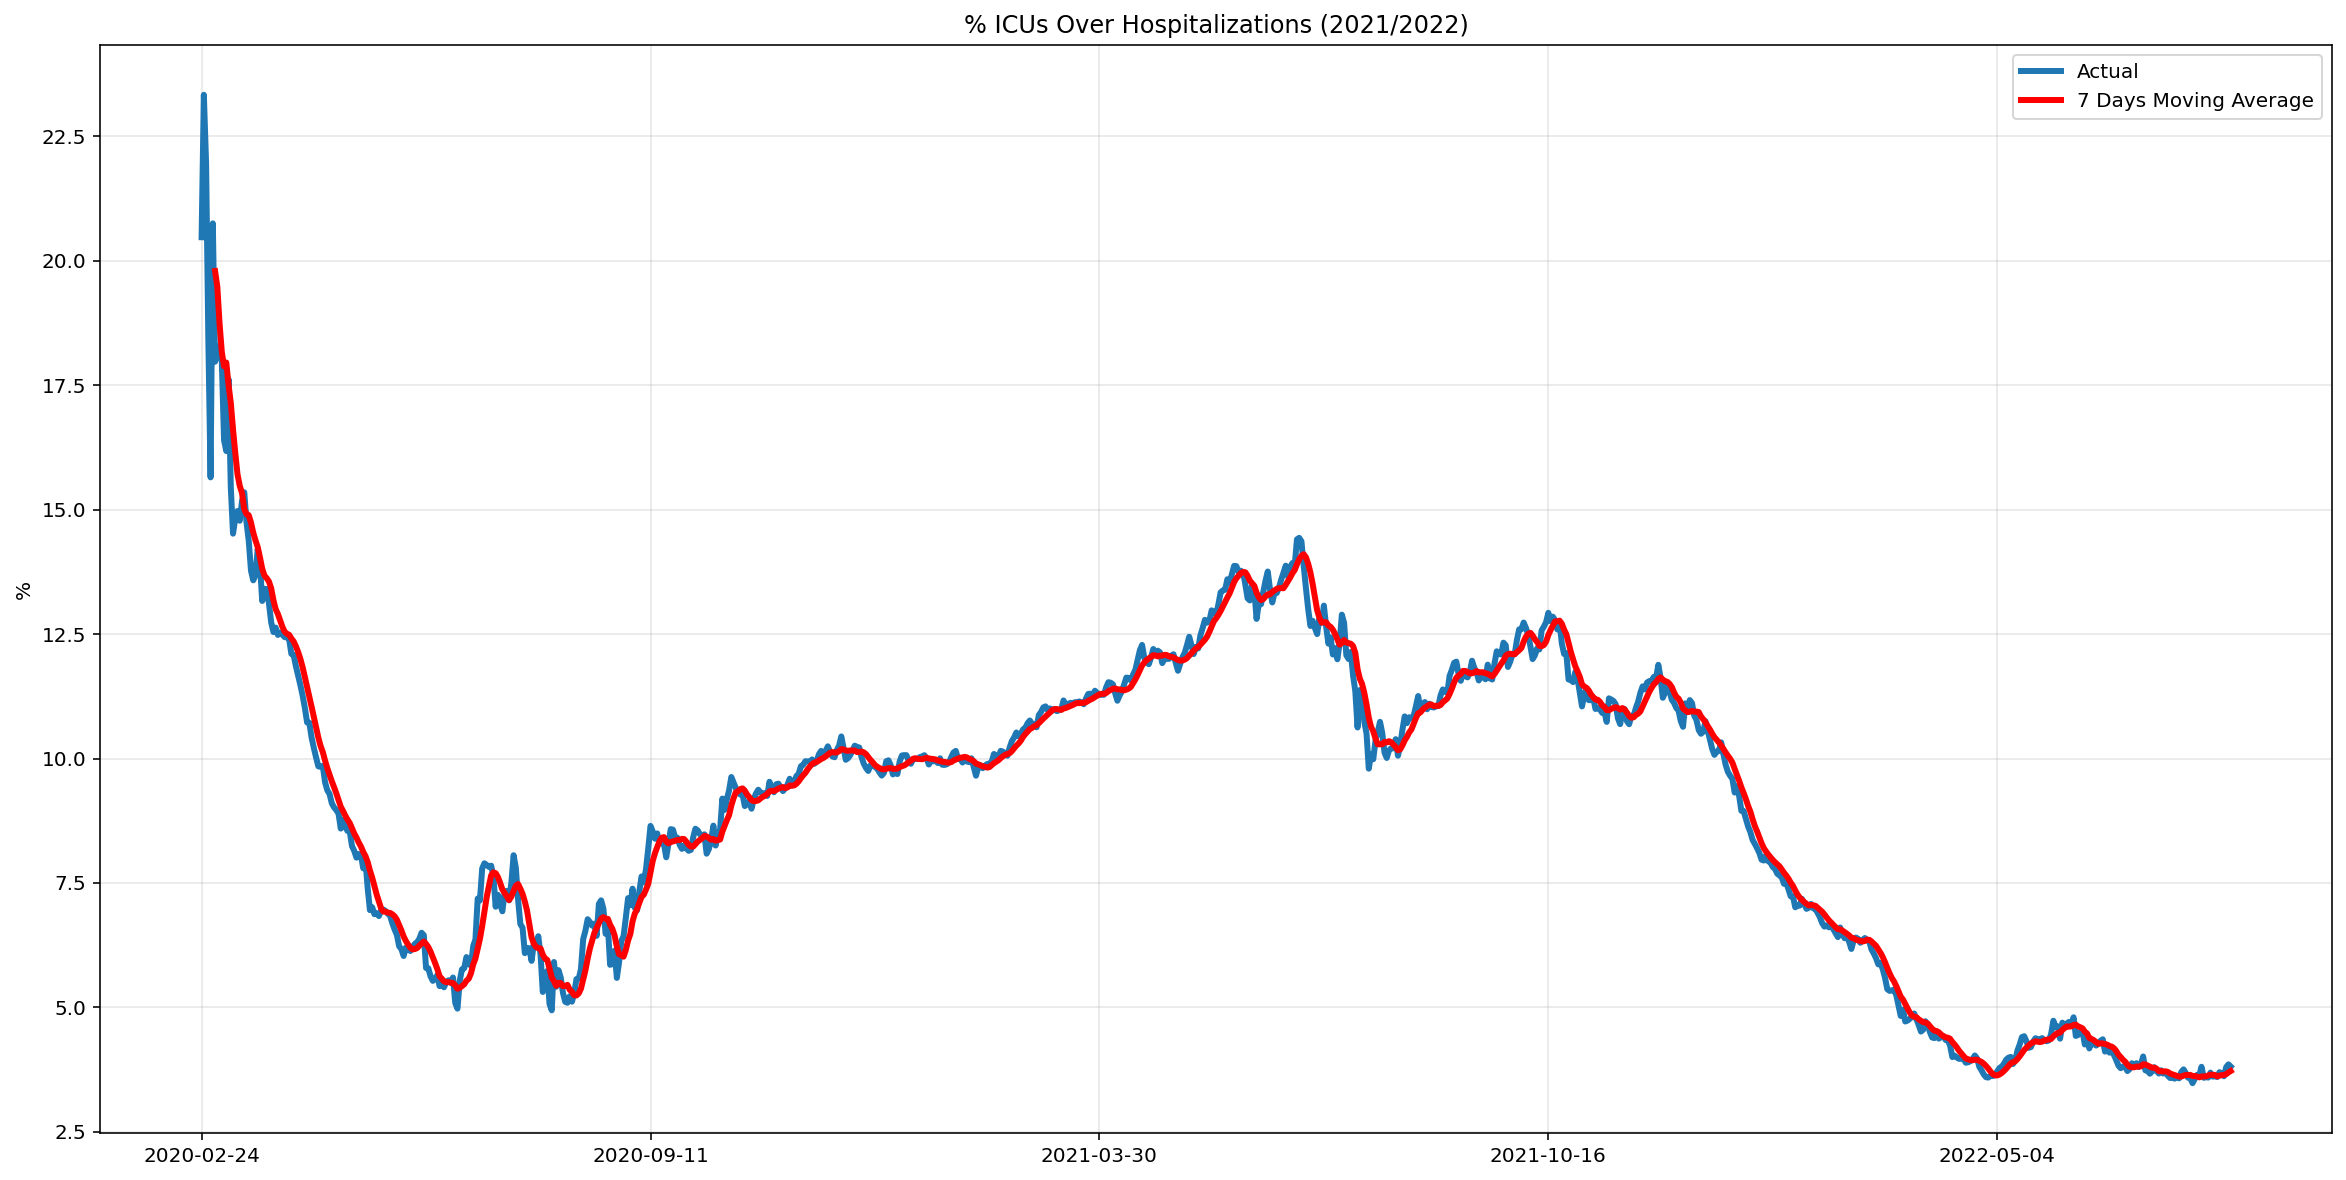

In [18]:
ti['ti_osp'] = (ti.terapia_intensiva / ti.ospedalizzati) * 100
ti['de_cas'] = (ti.deceduti.diff() / ti.nuovi_positivi) * 100
flim = ti.reset_index().query("data=='2021-01-30'").index[0]
fend = ti.reset_index()['ti_osp'].index[-1]

fig, ax = plt.subplots(figsize = (20,10))

ti.ti_osp.plot(ax = ax, linewidth = 3, label = 'Actual')
ti.ti_osp.rolling(7).mean().plot(ax = ax, linewidth = 3, c = 'r', label = '7 Days Moving Average')
_ = ax.legend()
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('%')
_ = ax.set_title('% ICUs Over Hospitalizations (2021/2022)')
# _ = ax.set_xlim(flim, fend)

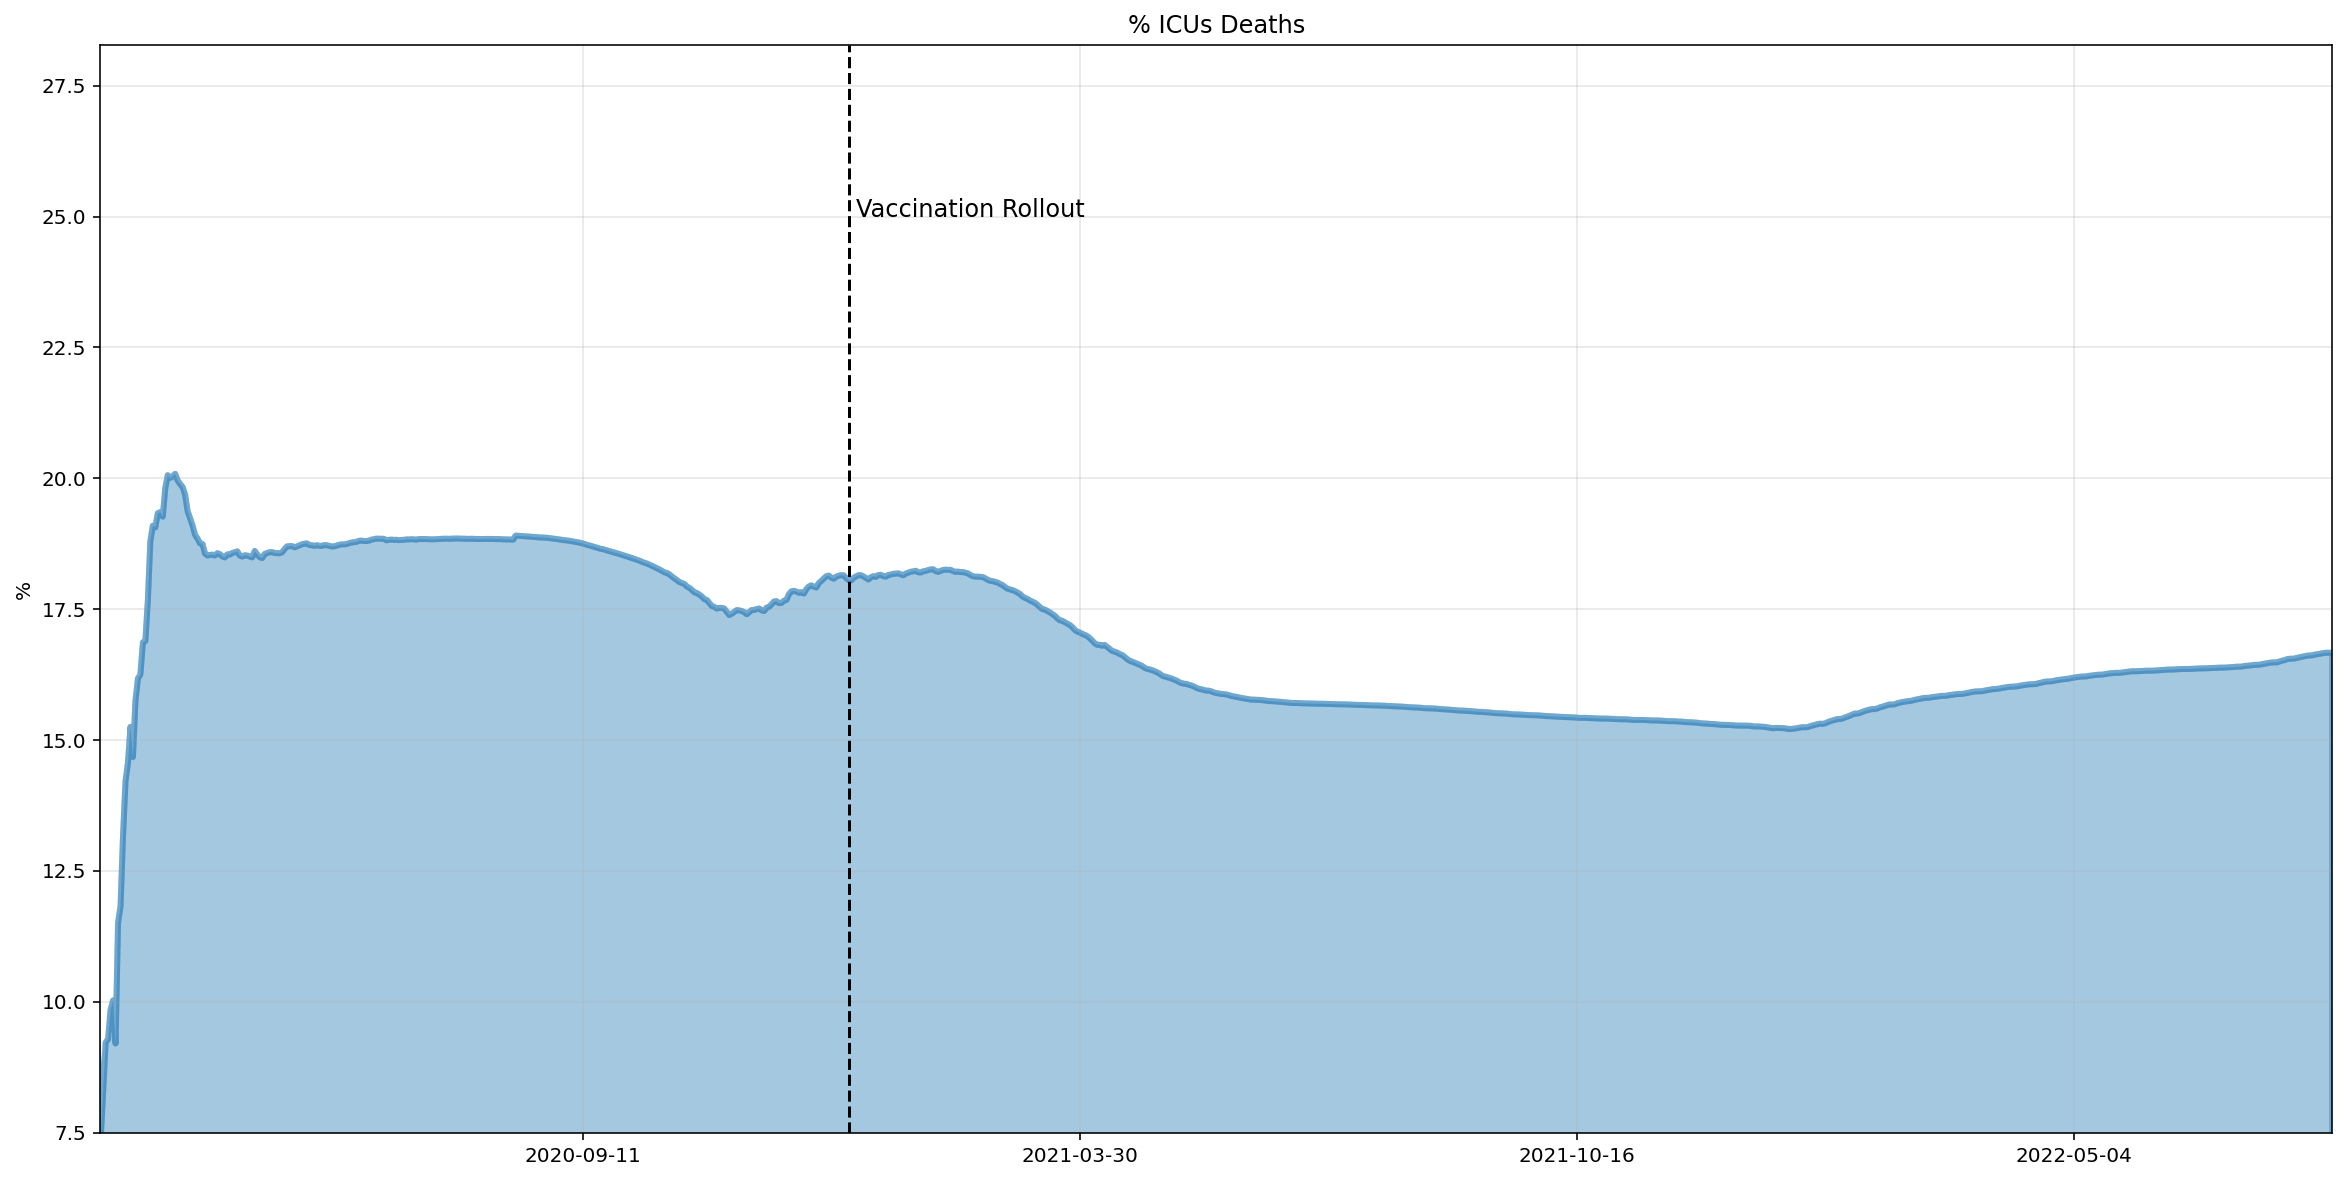

In [19]:
ti['ti_dec_ti'] = (ti.deceduti / ti.terapia_intensiva.cumsum()) * 100

vaccine_start = (pd.to_datetime('2020-12-27') - pd.to_datetime(ti.index[0])).days
trentaM = (pd.to_datetime('2021-07-26') - pd.to_datetime(ti.index[0])).days
ventiM = (pd.to_datetime('2021-05-22') - pd.to_datetime(ti.index[0])).days
fig, ax = plt.subplots(figsize = (20,10))

ti.ti_dec_ti.plot.area(ax = ax, linewidth = 3, alpha = 0.4, legend = False)
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('%')
_ = ax.set_title('% ICUs Deaths')
_ = ax.set_xlim(5.8, (pd.to_datetime(ti.index[-1]) - pd.to_datetime(ti.index[0])).days)
_ = ax.axvline(vaccine_start, c = 'k', linestyle = '--')
_ = ax.text(vaccine_start+3, 25, 'Vaccination Rollout', fontsize = 12)
_ = ax.set_ylim(7.5)

In [20]:
ti = ti.reset_index()
ti['year'] = pd.to_datetime(ti.reset_index().data).dt.year
ti = ti.set_index('data')
y20 = ti[ti.year == 2020]
y21 = ti[ti.year == 2021]
y22 = ti[ti.year == 2022]

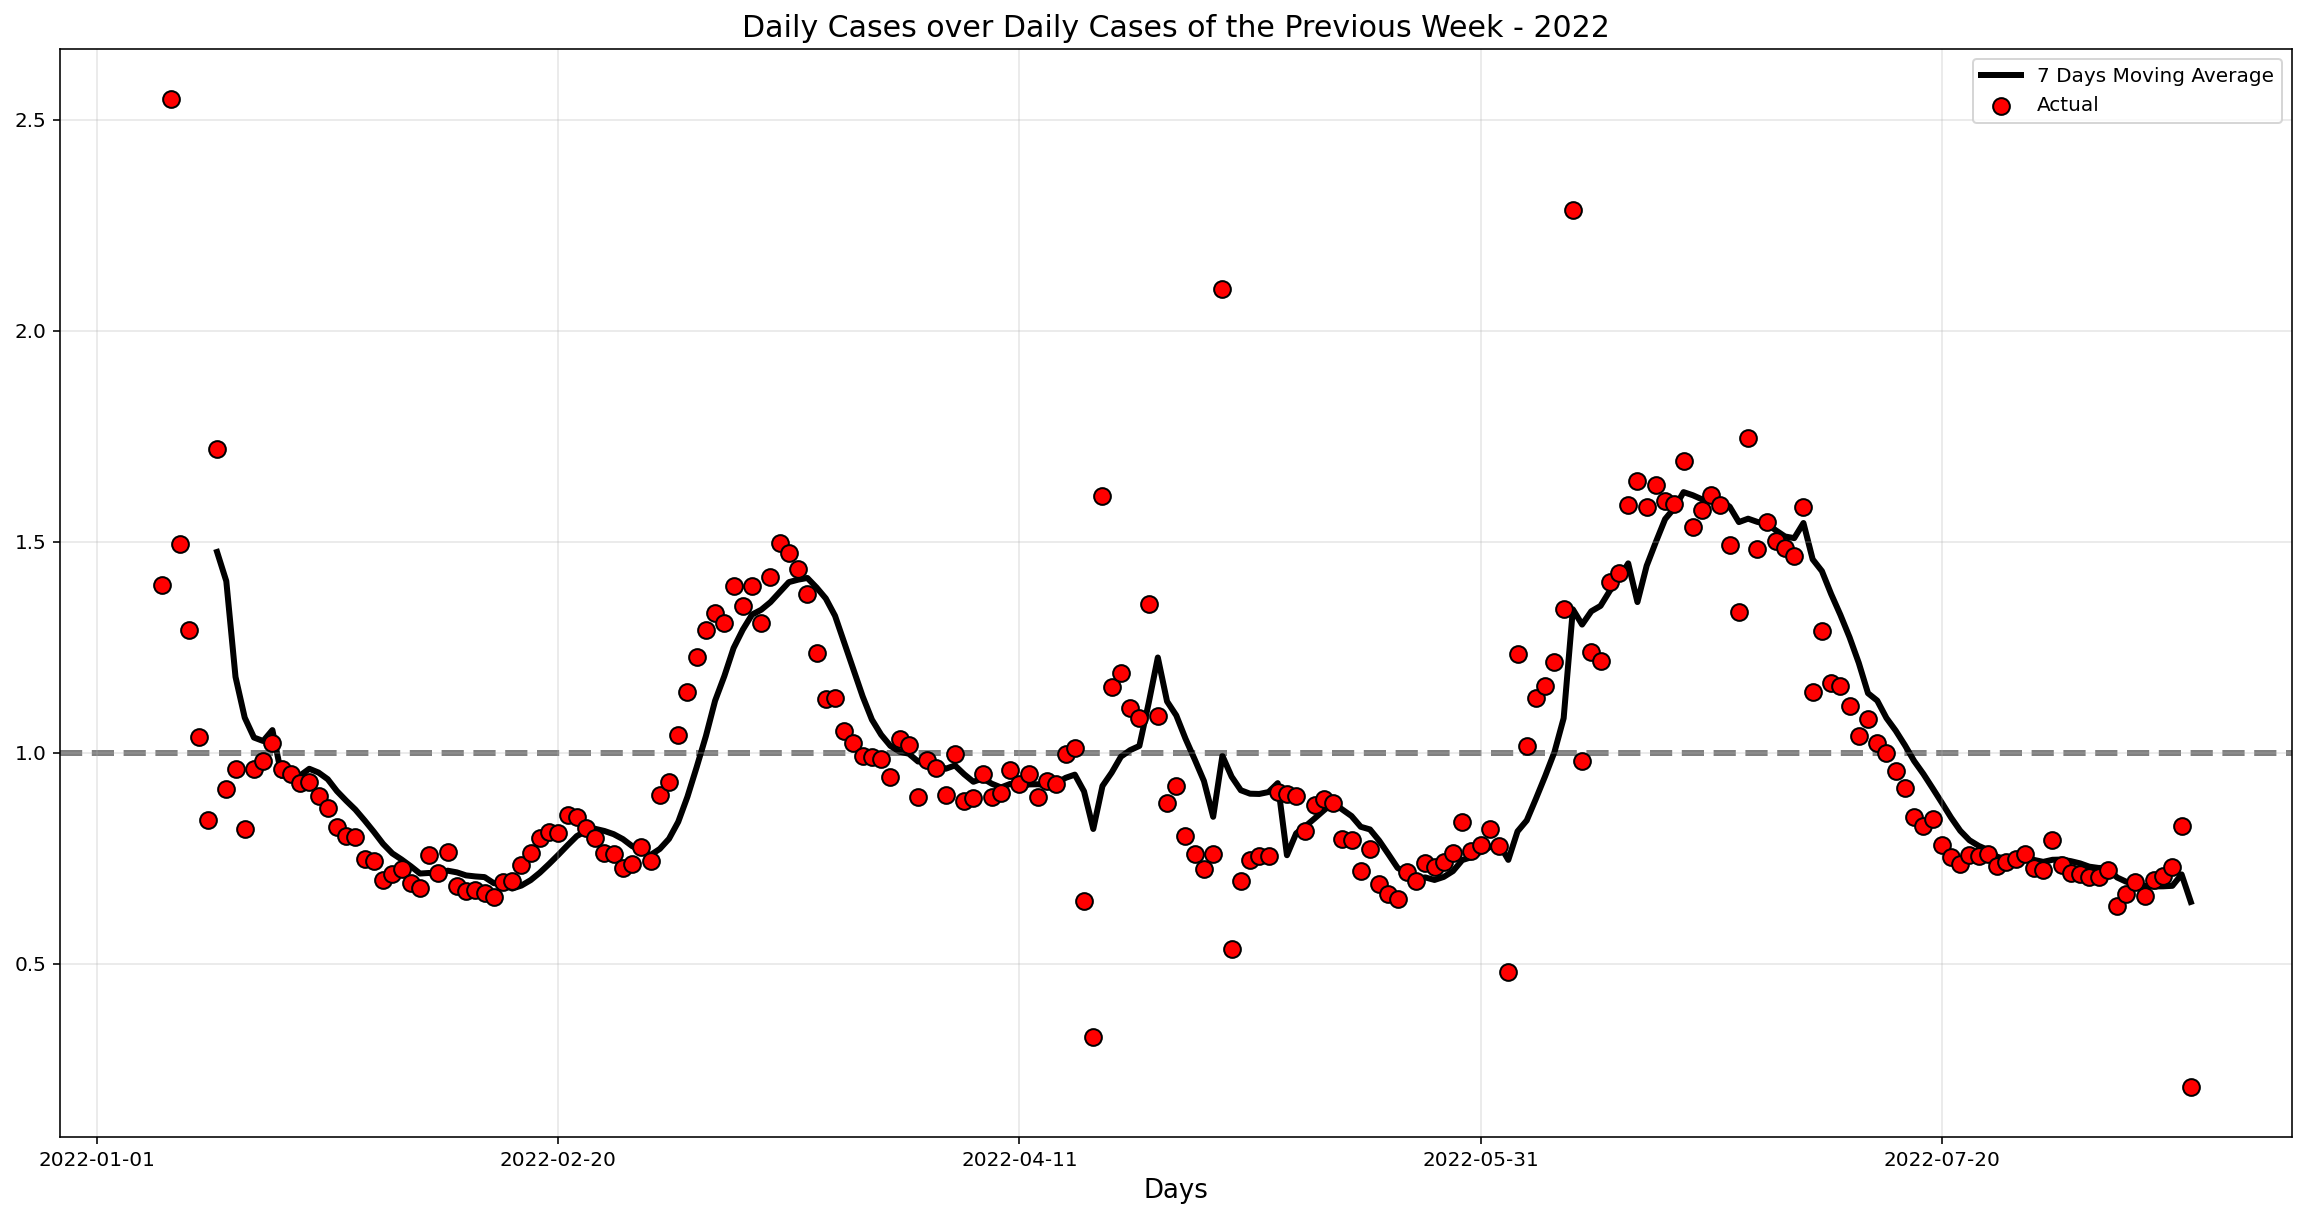

In [27]:
fig, ax = plt.subplots(figsize=(20,10))

week_var = y22.nuovi_positivi.div(y22.nuovi_positivi.shift(7))
week_var.rolling(7).mean().plot(ax=ax, linewidth=3, c="k", label="7 Days Moving Average", zorder=1)
ax.scatter(week_var.index, week_var, c="r", ec="k", s=70, label="Actual", zorder=2)
_ = ax.grid(alpha=.3)
_ = ax.legend()
_ = ax.set_xlabel("Days", fontsize=13)
_ = ax.set_title("Daily Cases over Daily Cases of the Previous Week - 2022", fontsize=15)
_ = ax.axhline(1, linewidth=3, linestyle="--", c="grey", zorder=0)

In [28]:
start_20 = y20.index[0]
start_21 = y21.index[0]
start_22 = y22.index[0]

y20['days_since_start'] = diff_dates(pd.to_datetime(start_20), pd.to_datetime(y20.index), days = True)
y21['days_since_start'] = diff_dates(pd.to_datetime(start_21), pd.to_datetime(y21.index), days = True)
y22['days_since_start'] = diff_dates(pd.to_datetime(start_22), pd.to_datetime(y22.index), days = True)

C:\Users\ttommasini\AppData\Local\Temp\ipykernel_22036\313257398.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y20['days_since_start'] = diff_dates(pd.to_datetime(start_20), pd.to_datetime(y20.index), days = True)
C:\Users\ttommasini\AppData\Local\Temp\ipykernel_22036\313257398.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y21['days_since_start'] = diff_dates(pd.to_datetime(start_21), pd.to_datetime(y21.index), days = True)
C:\Users\ttommasini\AppData\Local\Temp\ipykernel_22036\313257398.py:7: S

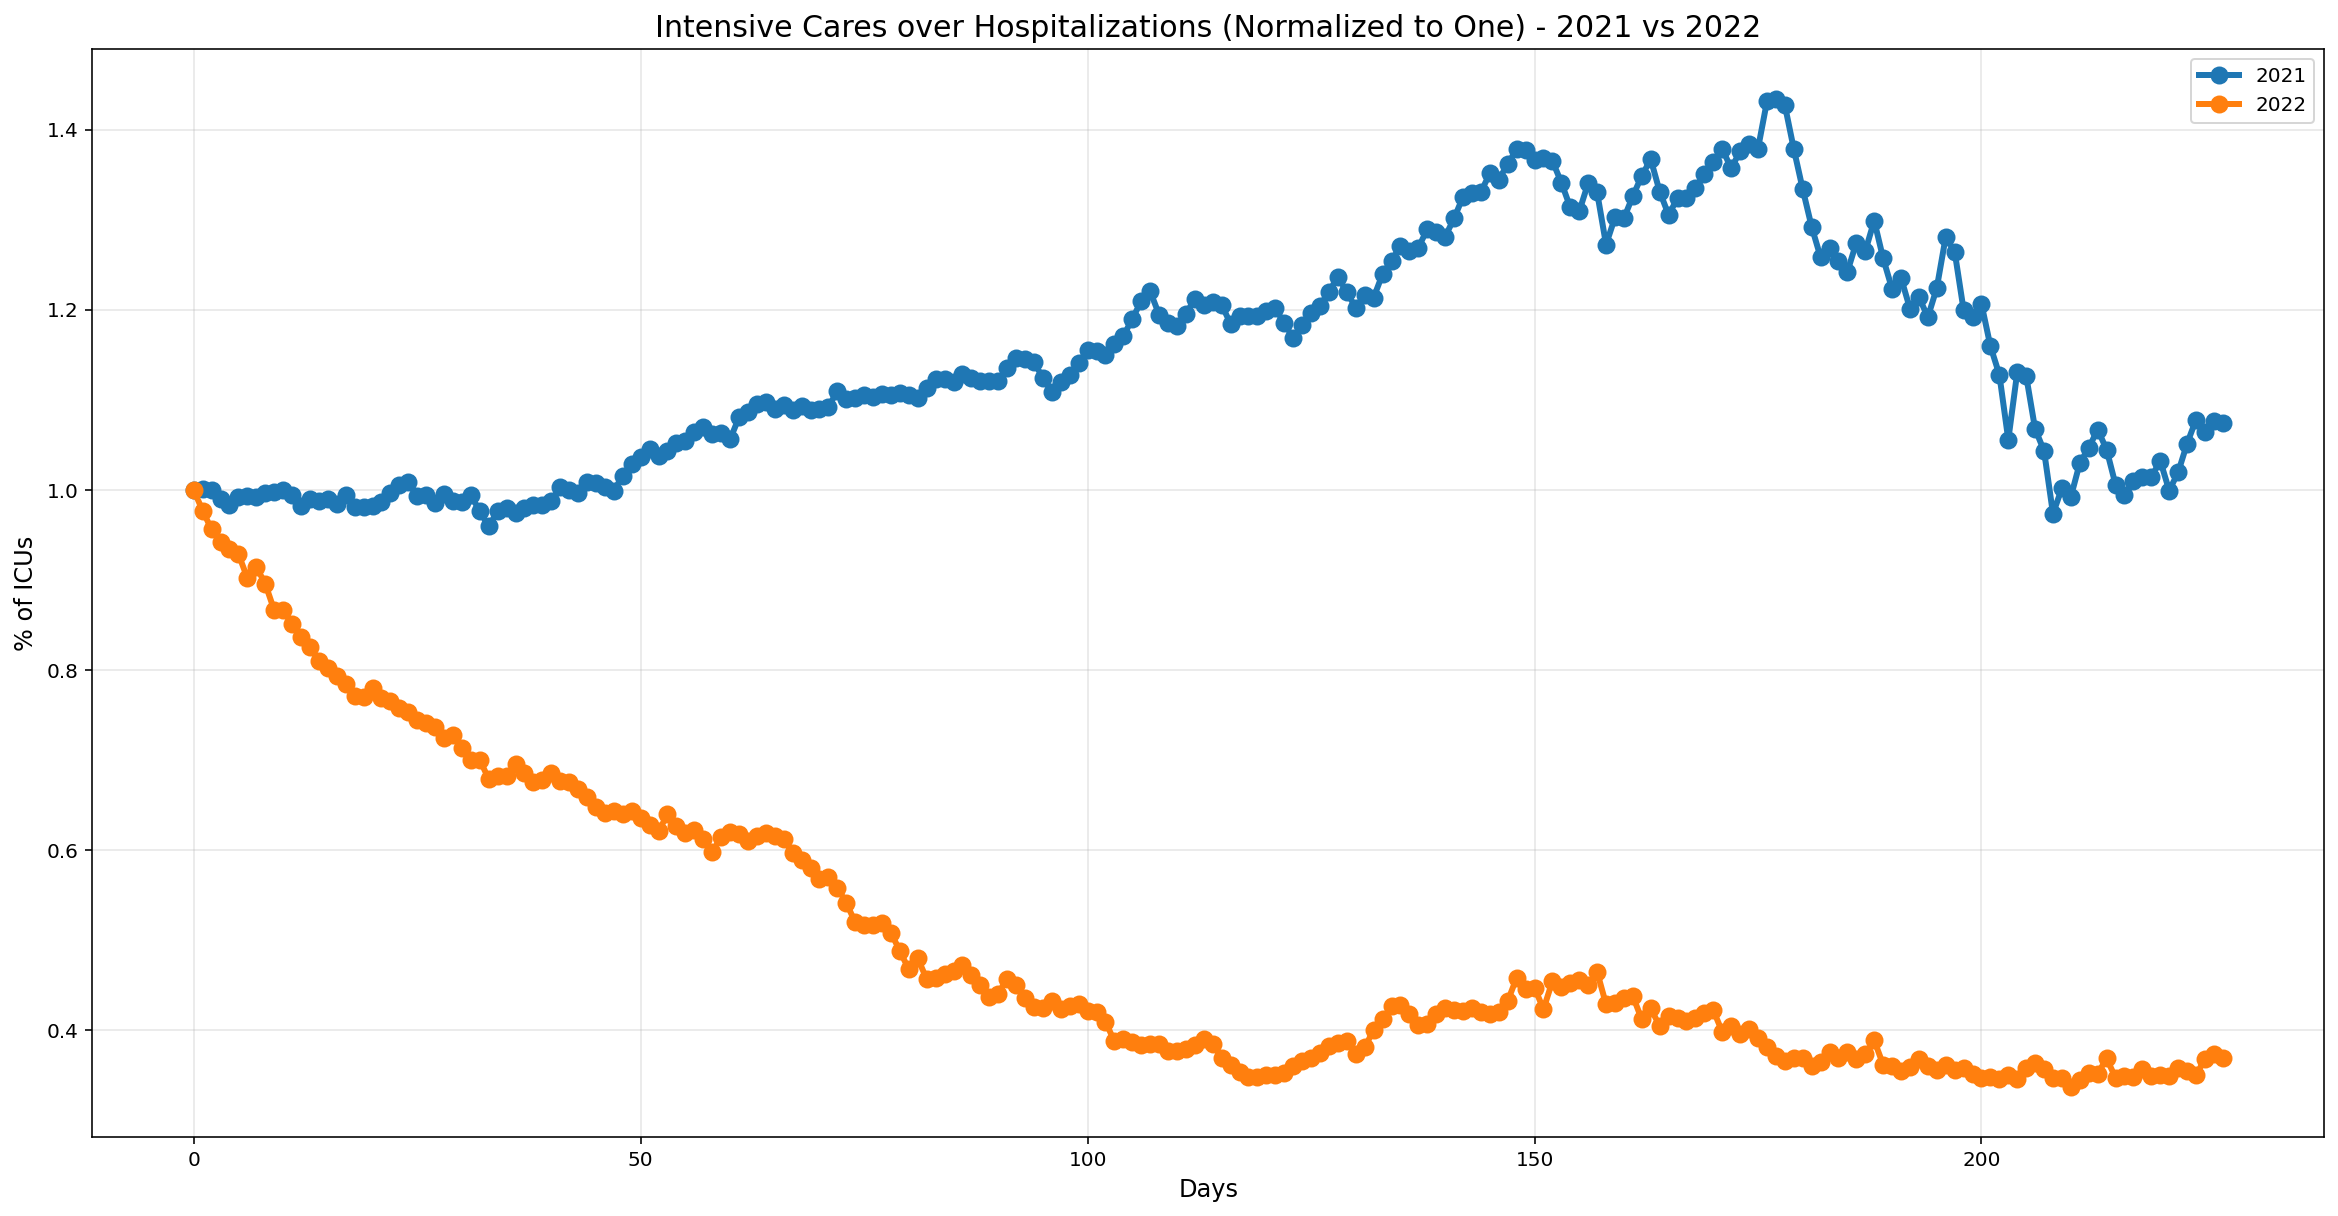

In [29]:
fig, ax = plt.subplots(figsize = (20,10))

y22_end = y22.reset_index().index[-1]
ax.plot(
    y21[:y22_end+1].days_since_start, 
    y21[:y22_end+1].ti_osp.div(y21[:y22_end+1].ti_osp[0]), 
    linewidth = 3, marker = 'o', label = '2021', markersize = 8
)
ax.plot(
    y22.days_since_start, 
    y22.ti_osp.div(y22.ti_osp[0]), 
    linewidth = 3, marker = 'o', label = '2022', markersize = 8
)
_ = ax.legend()
_ = ax.grid(alpha = .3)
_ = ax.set_title('Intensive Cares over Hospitalizations (Normalized to One) - 2021 vs 2022', fontsize=15)
_ = ax.set_xlabel('Days', fontsize=12)
_ = ax.set_ylabel('% of ICUs', fontsize=12)

In [30]:
y22_ = y22.reset_index()
y22_.data = pd.to_datetime(y22_.data)
# y22_= y22_.set_index("data")
y22_["deceduti_rm"] = y22_["diff_deceduti"].rolling(7).mean()
y22_["casi_rm"] = y22_["totale_casi"].diff().rolling(7).mean()
y22_["week"] = y22_.data.dt.isocalendar().week
y22_ = y22_.iloc[9:].reset_index(drop=True)

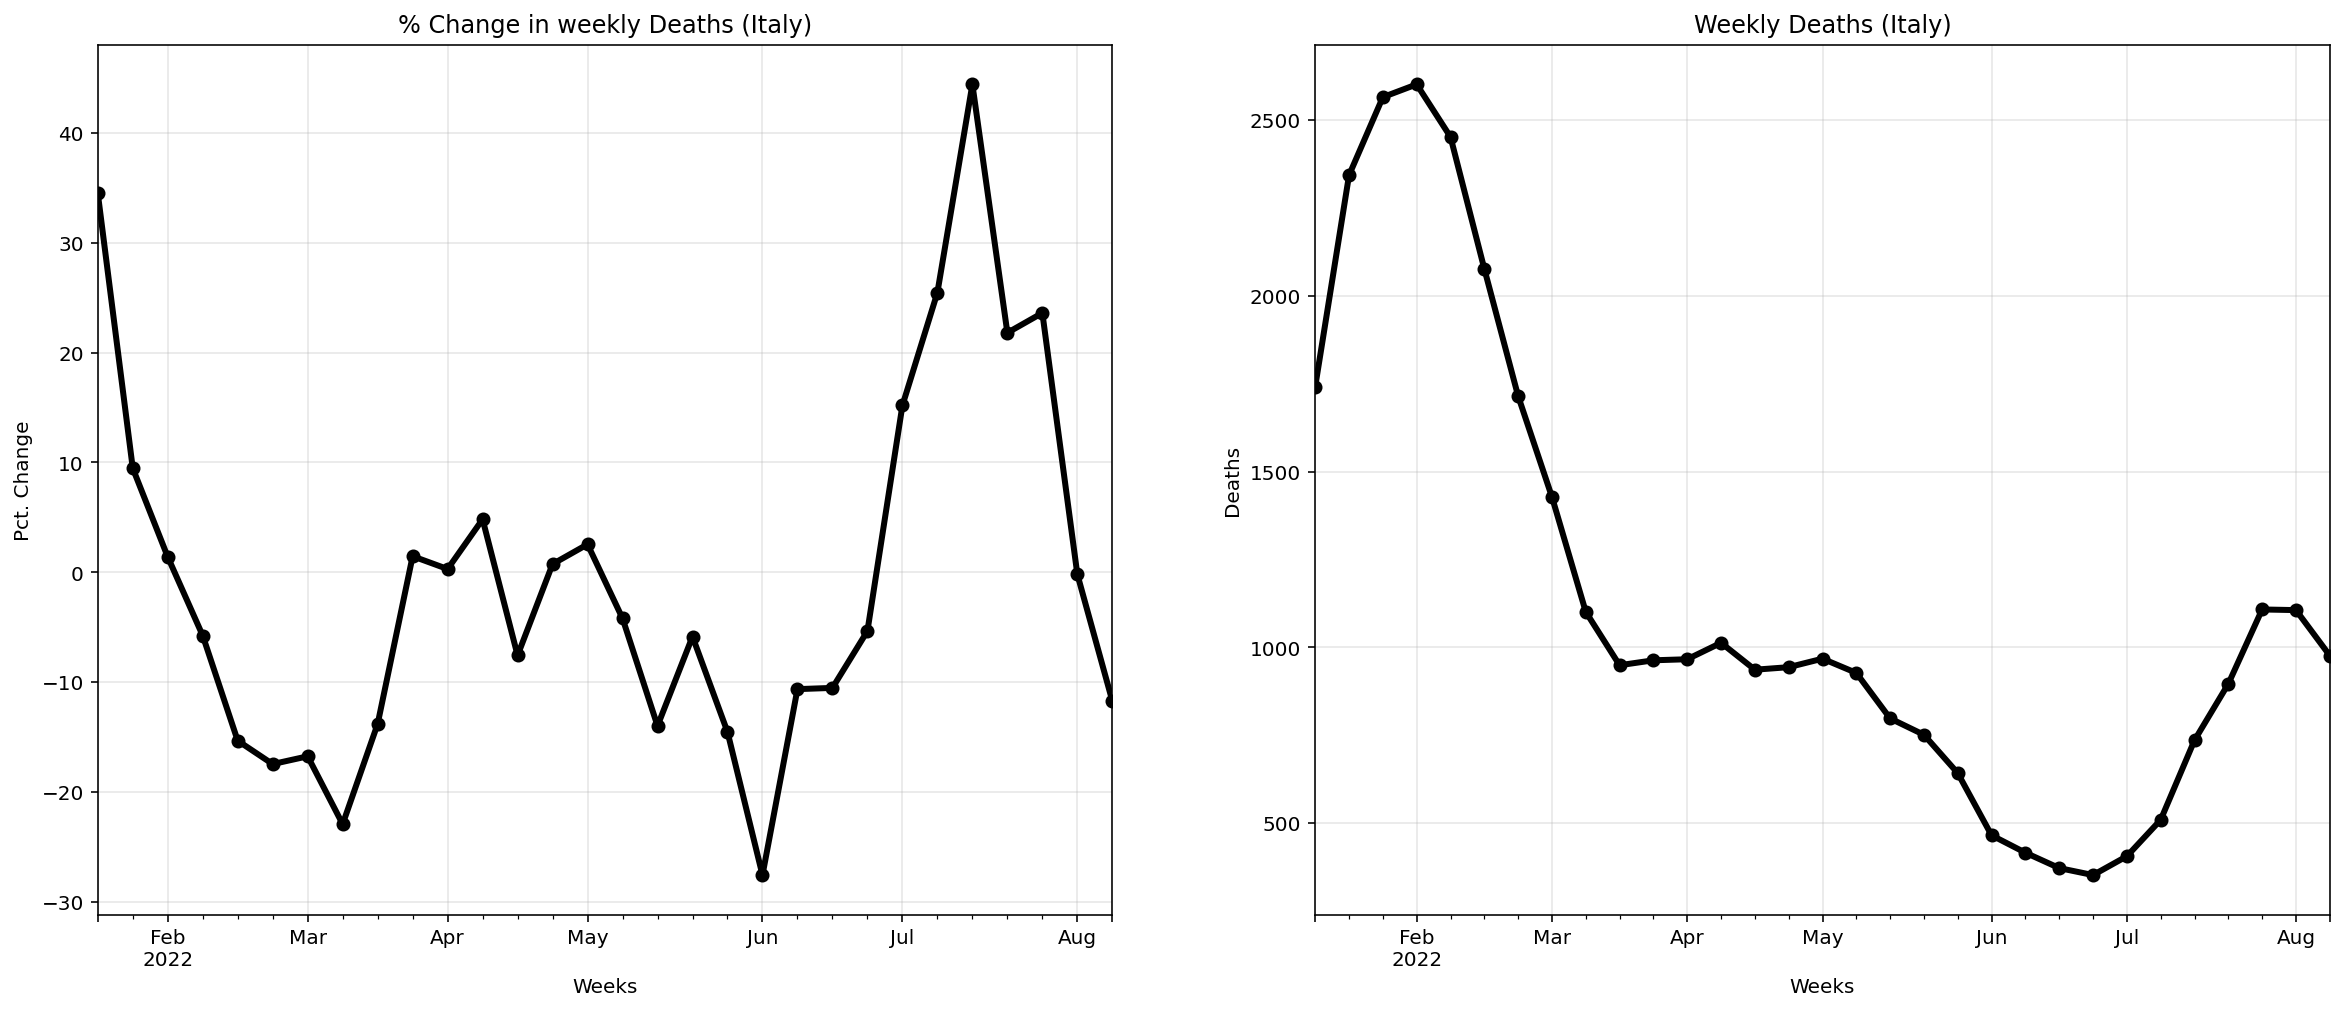

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
(y22_.resample("W", on="data").deceduti_rm.sum().pct_change()[:-1]*100).plot(ax=ax[0], c="k", marker="o", linewidth=3)
y22_.resample("W", on="data").deceduti_rm.sum()[:-1].plot(ax=ax[1], marker="o", linewidth=3, c="k")
_ = ax[0].set_xlim(ax[0].get_xlim()[0]+1, ax[0].get_xlim()[1])
_ = ax[0].grid(alpha=.3)
_ = ax[0].set_ylabel("Pct. Change")
_ = ax[0].set_title("% Change in weekly Deaths (Italy)")
_ = ax[0].set_xlabel("Weeks")
_ = ax[1].grid(alpha=.3)
_ = ax[1].set_title("Weekly Deaths (Italy)")
_ = ax[1].set_ylabel("Deaths")
_ = ax[1].set_xlabel("Weeks")
fig.savefig("pct_deaths.png", facecolor="white")

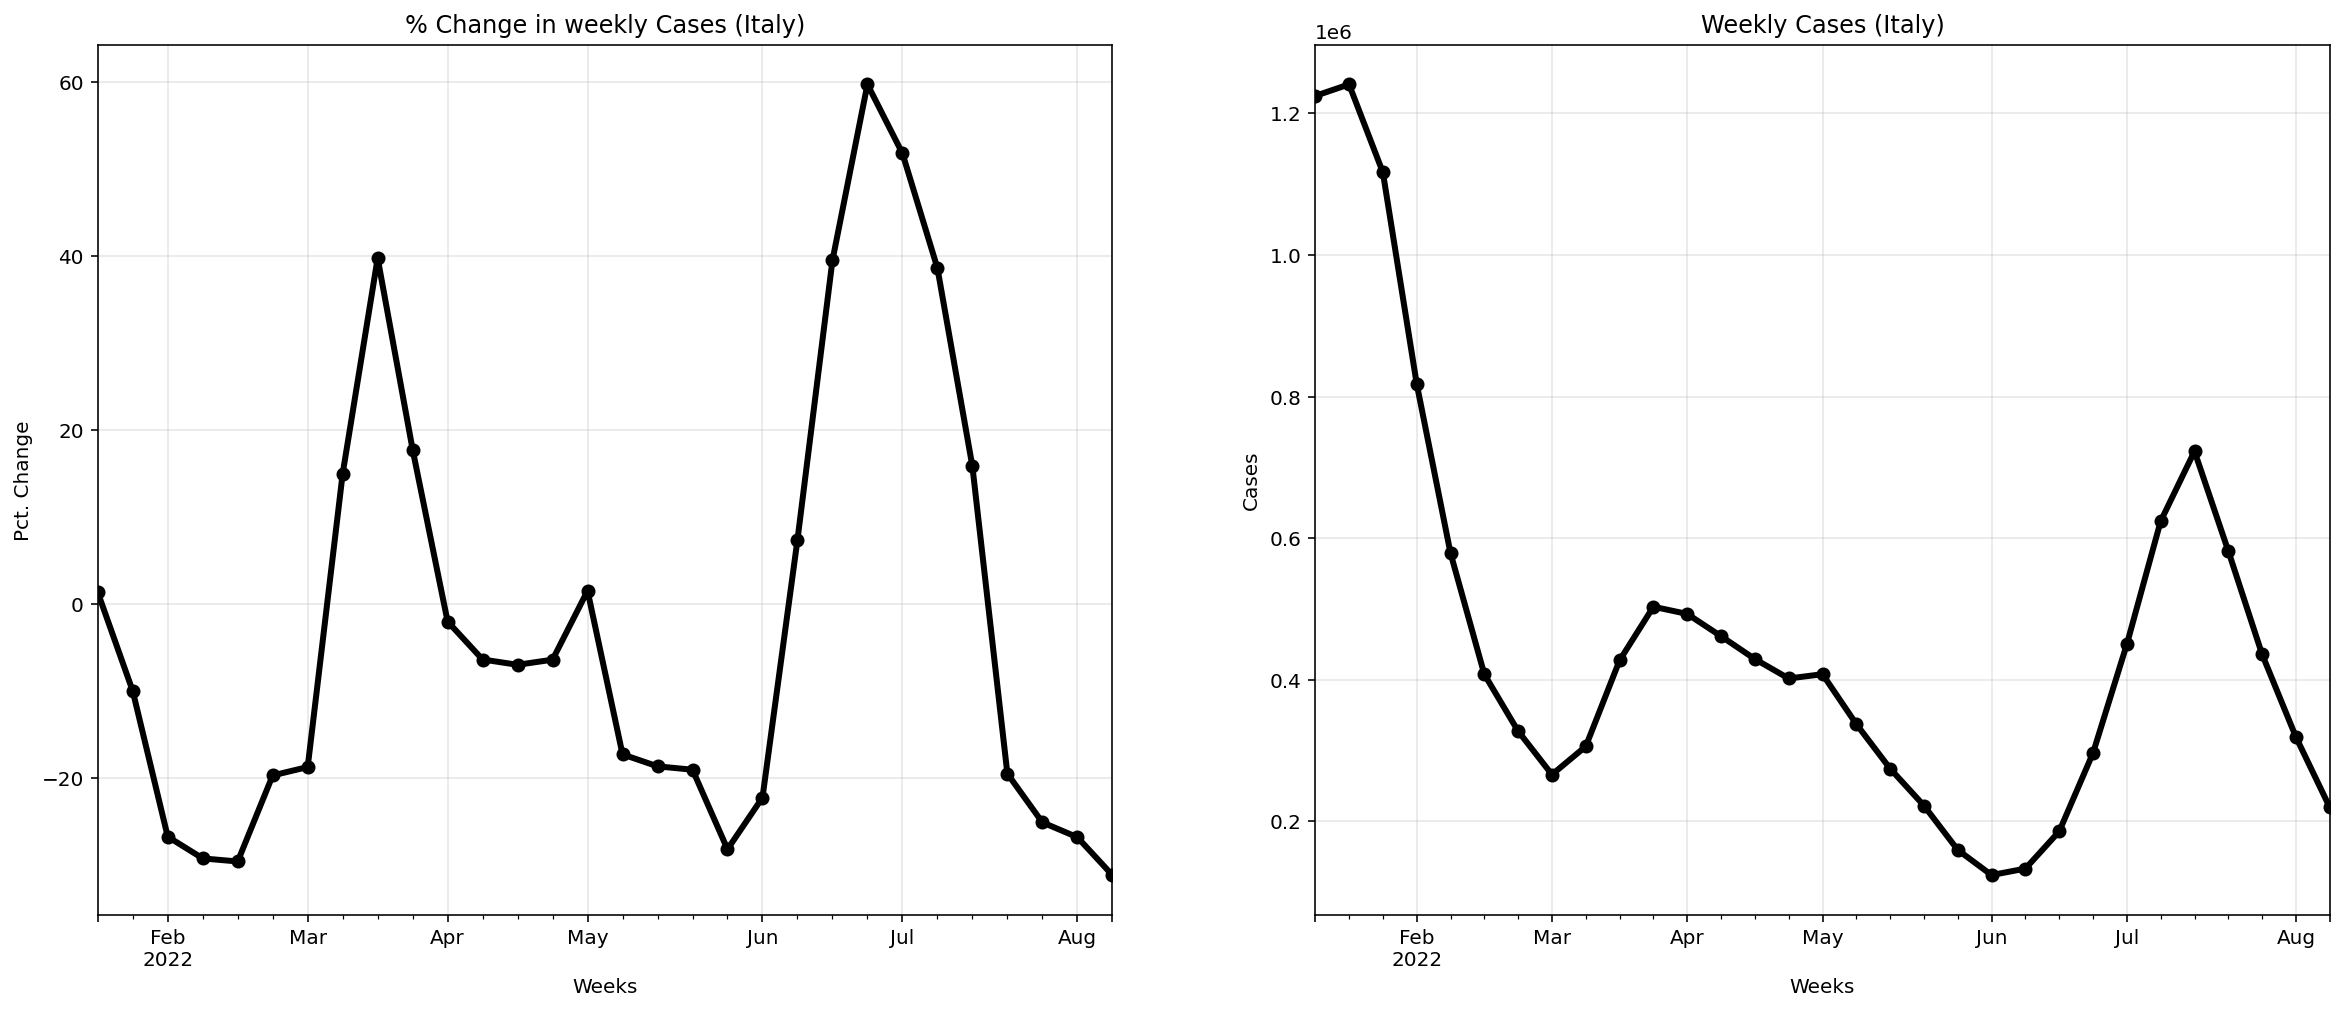

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
(y22_.resample("W", on="data").casi_rm.sum().pct_change()[:-1]*100).plot(ax=ax[0], c="k", marker="o", linewidth=3)
y22_.resample("W", on="data").casi_rm.sum()[:-1].plot(ax=ax[1], marker="o", linewidth=3, c="k")
_ = ax[0].set_xlim(ax[0].get_xlim()[0]+1, ax[0].get_xlim()[1])
_ = ax[0].grid(alpha=.3)
_ = ax[0].set_ylabel("Pct. Change")
_ = ax[0].set_title("% Change in weekly Cases (Italy)")
_ = ax[0].set_xlabel("Weeks")
_ = ax[1].grid(alpha=.3)
_ = ax[1].set_title("Weekly Cases (Italy)")
_ = ax[1].set_ylabel("Cases")
_ = ax[1].set_xlabel("Weeks")
fig.savefig("pct_cases.png", facecolor="white")

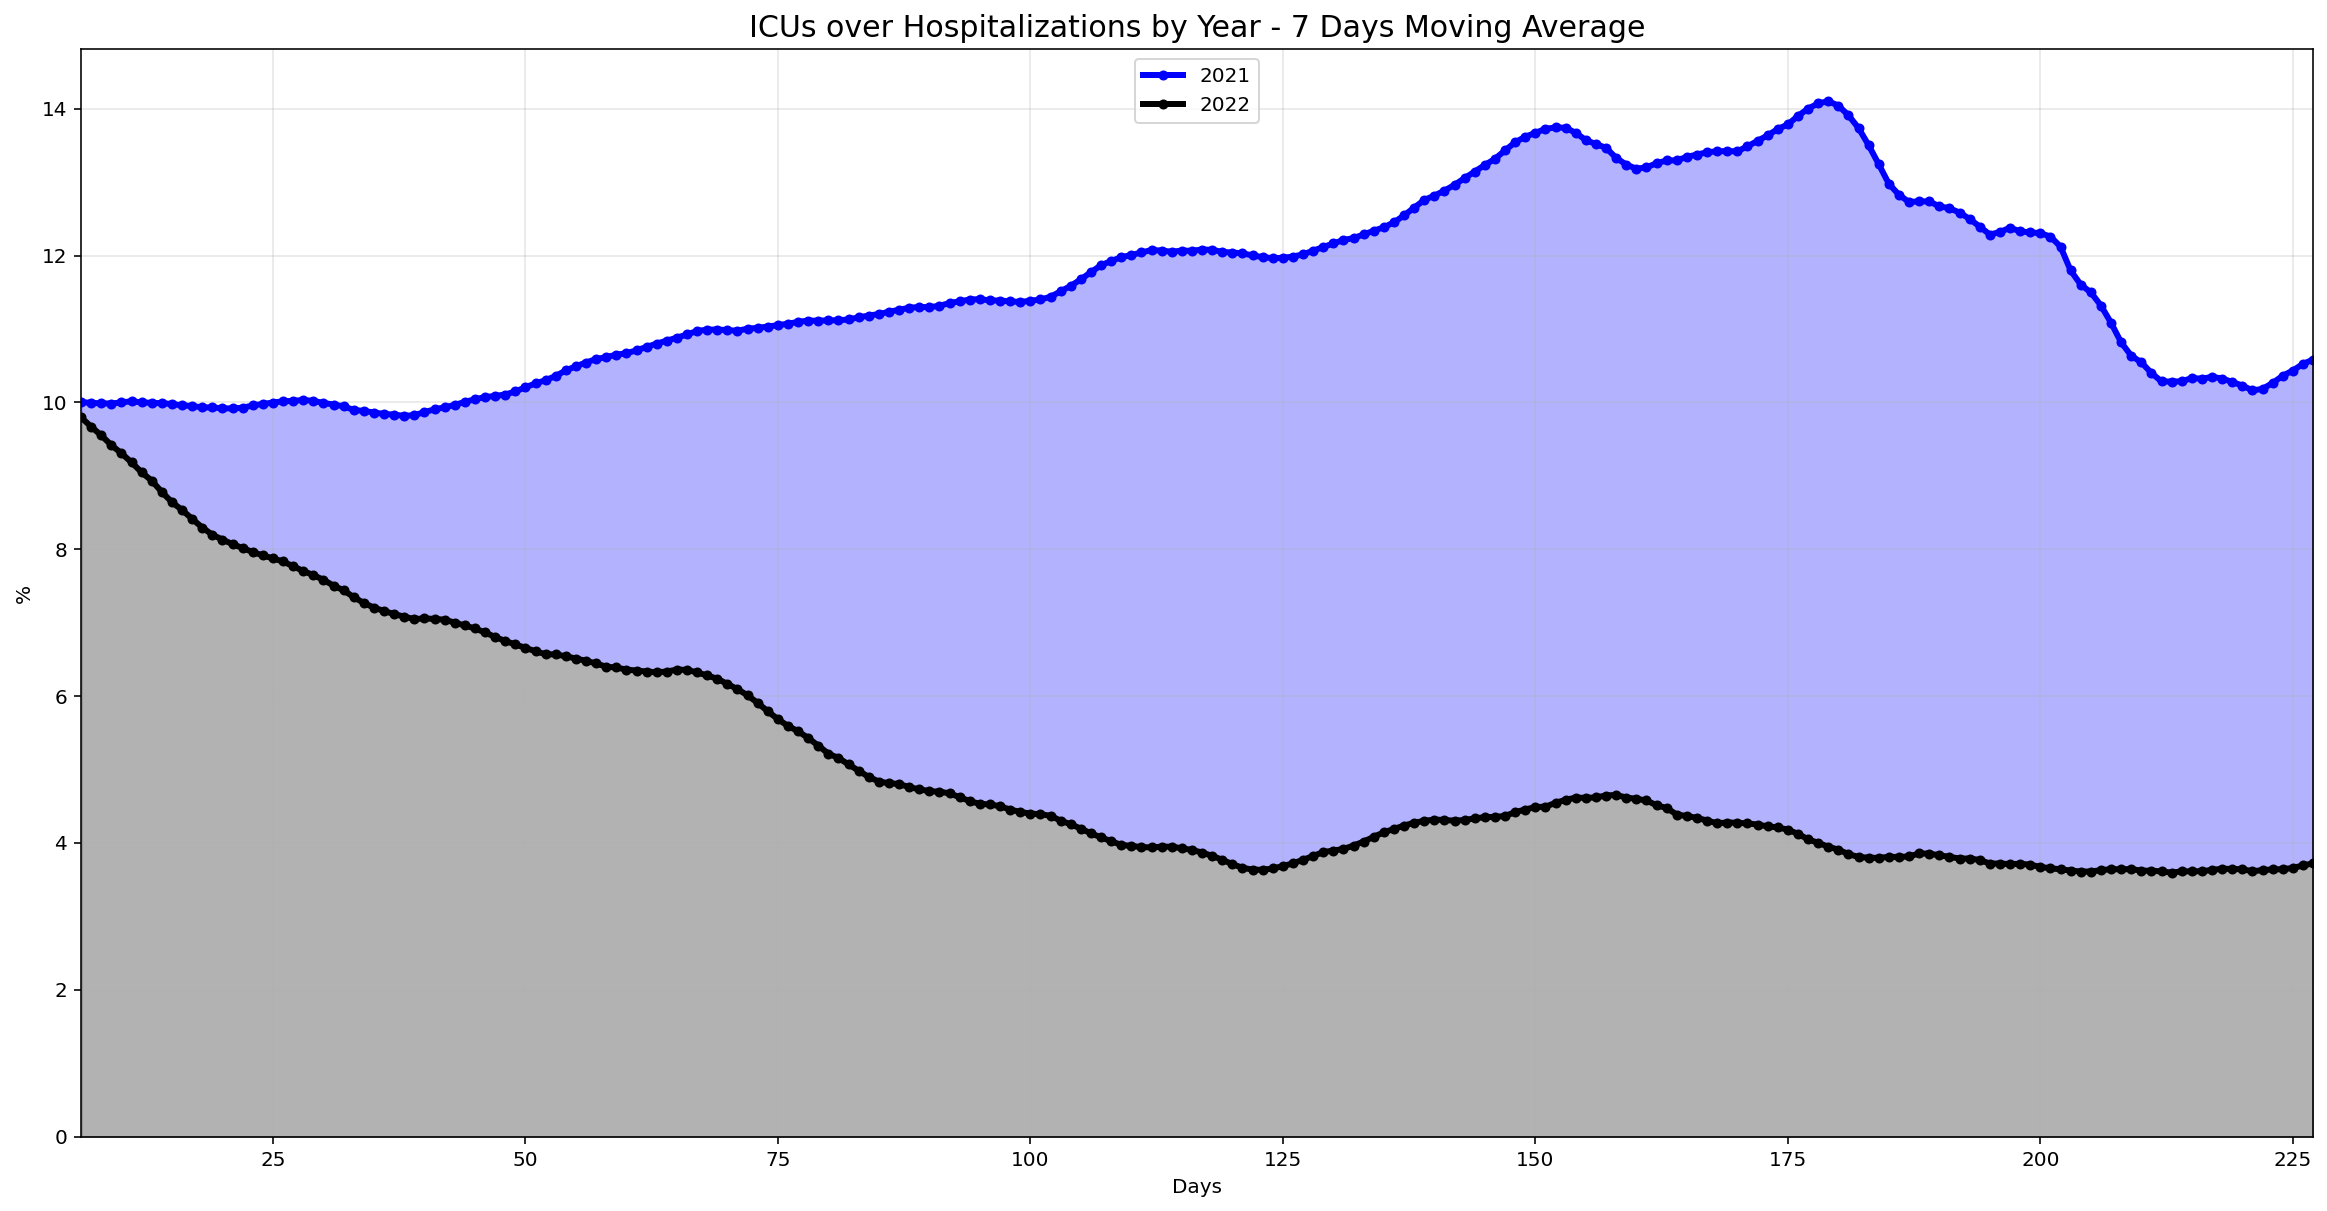

In [33]:
fig, ax = plt.subplots(figsize = (20,10))

y22_end = y22.reset_index().index[-1]
ax.plot(
    y21[:y22_end+1].days_since_start, 
    y21[:y22_end+1].ti_osp.rolling(7).mean(),  
    linewidth = 3, marker = '.', c="b",
    label = '2021', markersize = 8
)
ax.plot(
    y22.days_since_start, 
    y22.ti_osp.rolling(7).mean(),
    linewidth = 3, marker = '.', c="k",
    label = '2022', markersize = 8
)
ax.fill_between(
    y22.days_since_start, 
    y21[:y22_end+1].ti_osp.rolling(7).mean(),
    y22.ti_osp.rolling(7).mean(), color="b",
    alpha=.3
)
ax.fill_between(
    y22.days_since_start, 
    y22.ti_osp.rolling(7).mean(), color="k",
    alpha=.3
)
_ = ax.set_ylim(0)
_ = ax.set_xlim(y22.days_since_start[6], len(y22.days_since_start)-1)
_ = ax.legend(loc="upper center")
_ = ax.grid(alpha = .3)
_ = ax.set_title("ICUs over Hospitalizations by Year - 7 Days Moving Average", fontsize=15)
_ = ax.set_ylabel("%")
_ = ax.set_xlabel("Days")
fig.savefig("icu_h_perc.png", facecolor="white")

C:\Users\ttommasini\AppData\Local\Temp\ipykernel_22036\2633516822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y22["drate"] = (
C:\Users\ttommasini\AppData\Local\Temp\ipykernel_22036\2633516822.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y21["drate"] = (


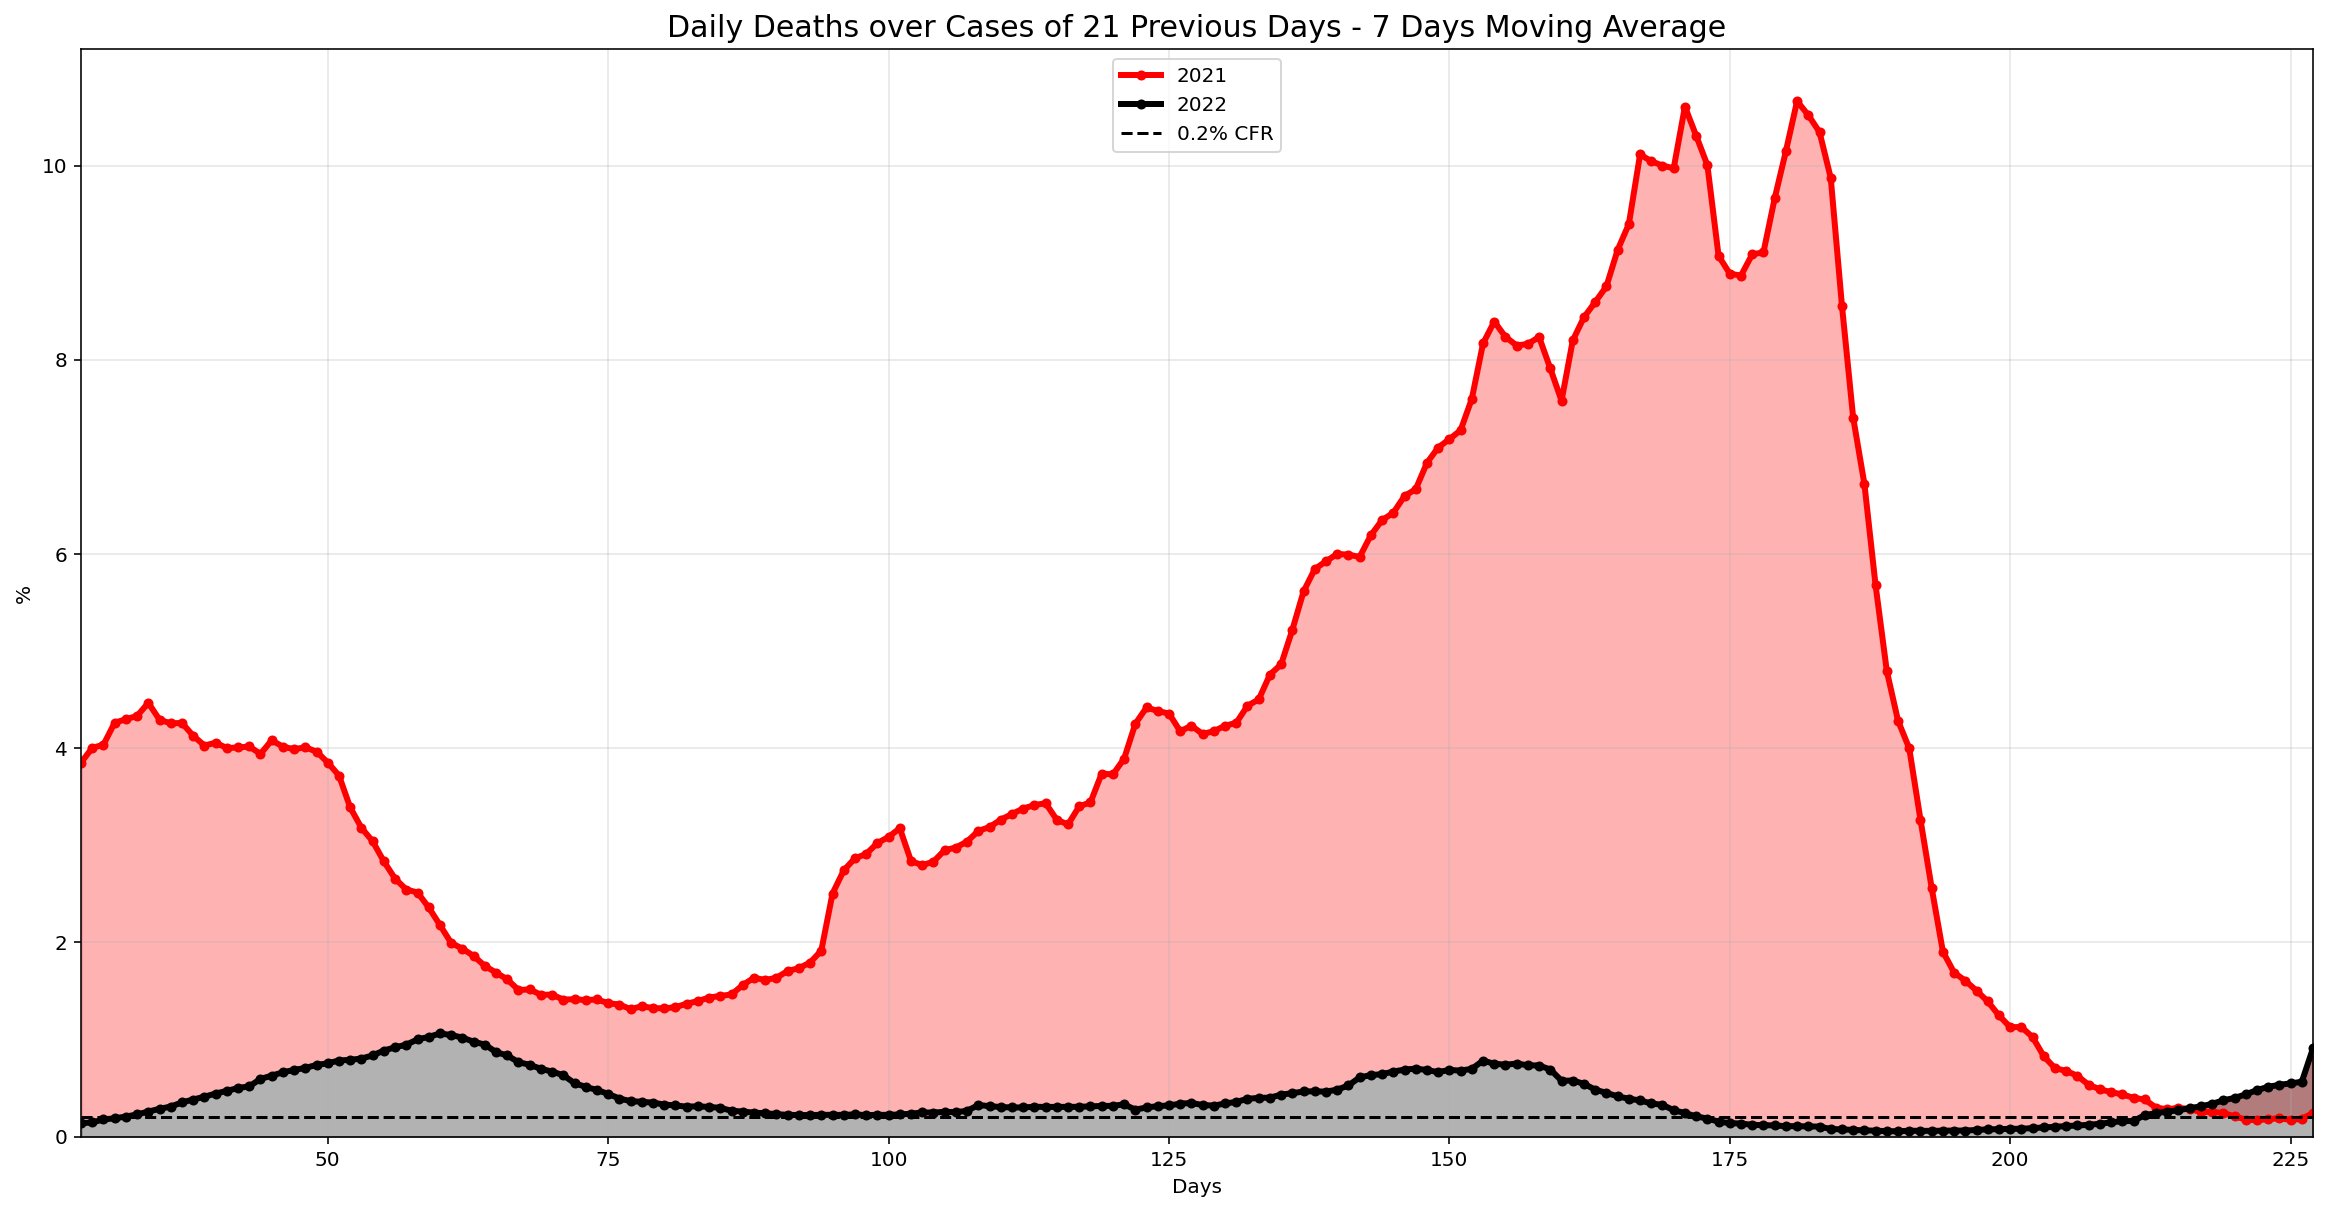

In [34]:
fig, ax = plt.subplots(figsize = (20,10))

y22_end = y22.reset_index().index[-1]
y22["drate"] = (
    y22.deceduti.diff()[y22.deceduti.diff()>0].shift(21) / 
    y22.nuovi_positivi[y22.deceduti.diff()>0] * 100
)
y21["drate"] = (
    y21.deceduti.diff()[y21.deceduti.diff()>0].shift(21) / 
    y21.nuovi_positivi[y21.deceduti.diff()>0] * 100
)

ax.plot(
    y21[:y22_end+1].days_since_start, 
    y21[:y22_end+1].drate.rolling(7).mean(),  
    linewidth = 3, marker = '.', c="r",
    label = '2021', markersize = 8
)
ax.plot(
    y22.days_since_start, 
    y22.drate.rolling(7).mean(),
    linewidth = 3, marker = '.', c="k",
    label = '2022', markersize = 8
)
ax.fill_between(
    y22.days_since_start, 
    y21[:y22_end+1].drate.rolling(7).mean(),
    y22.drate.rolling(7).mean(), color="r",
    alpha=.3
)
ax.fill_between(
    y22.days_since_start, 
    y22.drate.rolling(7).mean(), color="k",
    alpha=.3
)
_ = ax.set_ylim(0)
_ = ax.set_xlim(y22.days_since_start[28], len(y22.days_since_start)-1)
_ = ax.axhline(.2, c="k", linestyle="--", label="0.2% CFR")
_ = ax.legend(loc="upper center")
_ = ax.grid(alpha = .3)
_ = ax.set_title("Daily Deaths over Cases of 21 Previous Days - 7 Days Moving Average", fontsize=15)
_ = ax.set_ylabel("%")
_ = ax.set_xlabel("Days")
fig.savefig("dd_perc.png", facecolor="white")

In [35]:
y21 = y21.reset_index()
y21['day'] = pd.to_datetime(y21.data).dt.day
y21['month'] = pd.to_datetime(y21.data).dt.month

In [36]:
y22 = y22.reset_index()
y22['day'] = pd.to_datetime(y22.data).dt.day
y22['month'] = pd.to_datetime(y22.data).dt.month

In [37]:
bymonth = pd.pivot_table(y21, index = 'day', columns = 'month', values = 'ti_osp')
bymonth_22 = pd.pivot_table(y21, index = 'day', columns = 'month', values = 'ti_osp')

In [38]:
bymonth_mean = pd.pivot_table(y21, index = 'day', columns = 'month', values = 'ti_osp').mean(axis = 1)
bymonth_std = pd.pivot_table(y21, index = 'day', columns = 'month', values = 'ti_osp').std(axis = 1)

In [39]:
bymonth_mean.index = np.arange(len(bymonth_mean.index))
bymonth_std.index = np.arange(len(bymonth_std.index))

In [40]:
bymonth_mean_22 = pd.pivot_table(y22, index = 'day', columns = 'month', values = 'ti_osp').iloc[:, :2]
bymonth_std_22 = pd.pivot_table(y22, index = 'day', columns = 'month', values = 'ti_osp').iloc[:, :2]
bymonth_mean_22[2] = bymonth_mean_22[2].interpolate(method = 'spline', order = 2)
bymonth_std_22[2] = bymonth_std_22[2].interpolate(method = 'spline', order = 2)

In [41]:
bymonth_mean_22 = bymonth_mean_22.mean(axis = 1)
bymonth_std_22 = bymonth_std_22.mean(axis = 1)

In [42]:
bymonth_mean_22.index = np.arange(len(bymonth_mean_22.index))
bymonth_std_22.index = np.arange(len(bymonth_std_22.index))

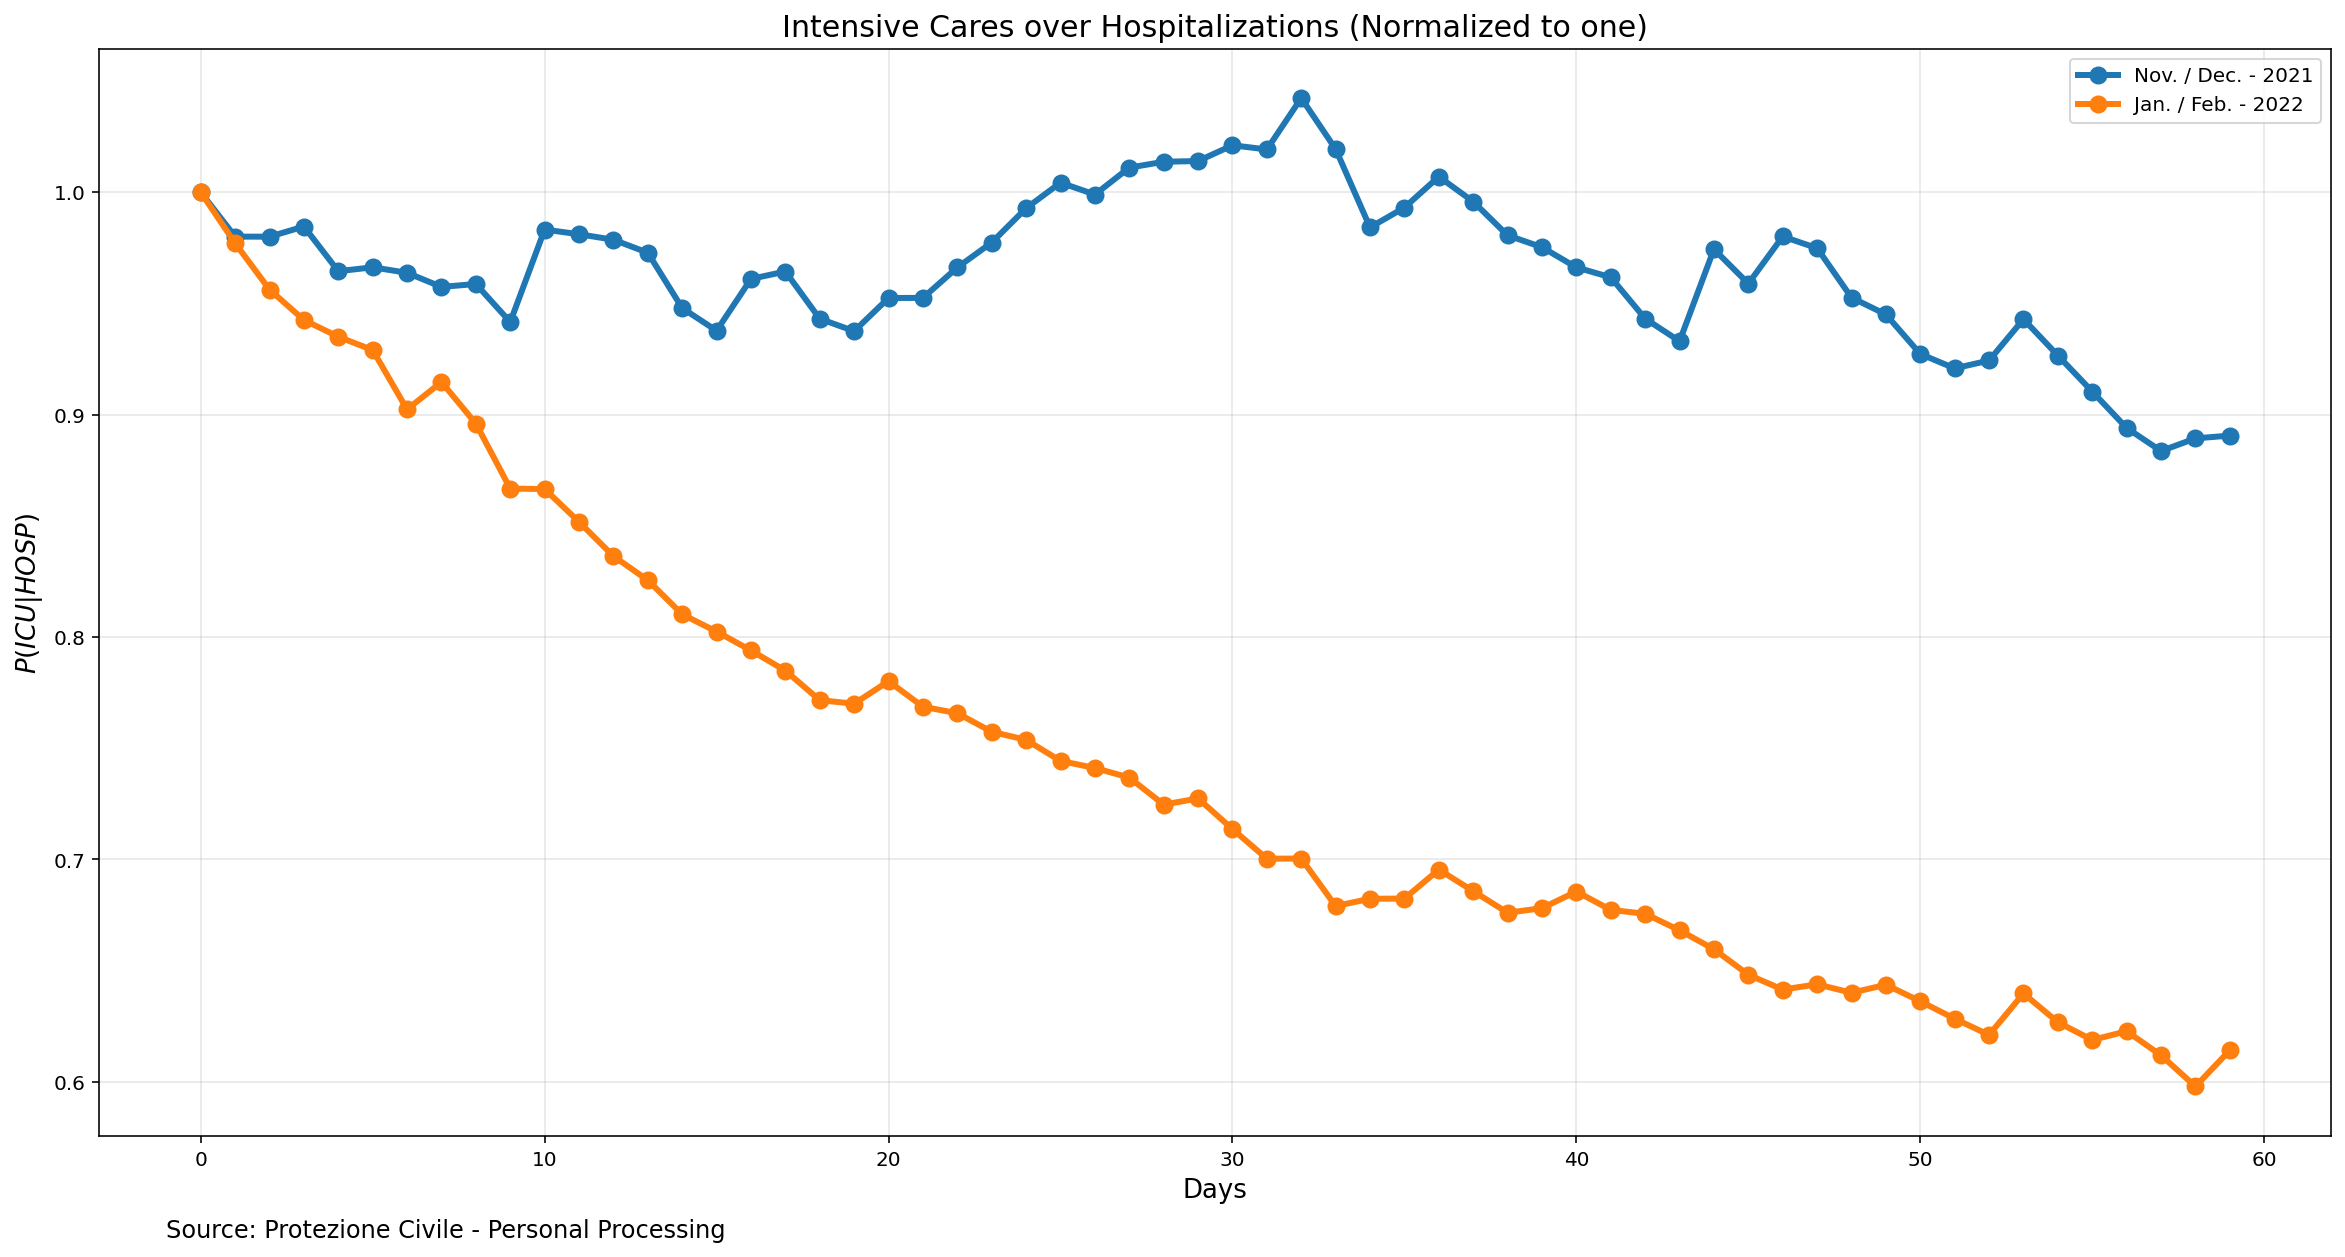

In [43]:
fig, ax = plt.subplots(figsize = (20,10))

y22_end = y22.reset_index().index[-1]

ax.plot(
    np.arange(60), 
    y21.ti_osp.div(y21.ti_osp[365-60])[-60:], 
    linewidth = 3, marker = 'o',
    label = 'Nov. / Dec. - 2021', markersize = 8
)

ax.plot(
    np.arange(60), 
    y22.ti_osp.div(y22.ti_osp[0])[:60], 
    linewidth = 3, marker = 'o',
    label = 'Jan. / Feb. - 2022', markersize = 8
)
_ = ax.legend()
_ = ax.grid(alpha = .3)
_ = ax.text(-1, 0.53, 'Source: Protezione Civile - Personal Processing', fontsize = 12)
_ = ax.set_xlabel('Days', fontsize = 13)
_ = ax.set_ylabel('$P(ICU|HOSP)$', fontsize = 13)
_ = ax.set_title('Intensive Cares over Hospitalizations (Normalized to one)', fontsize = 15)

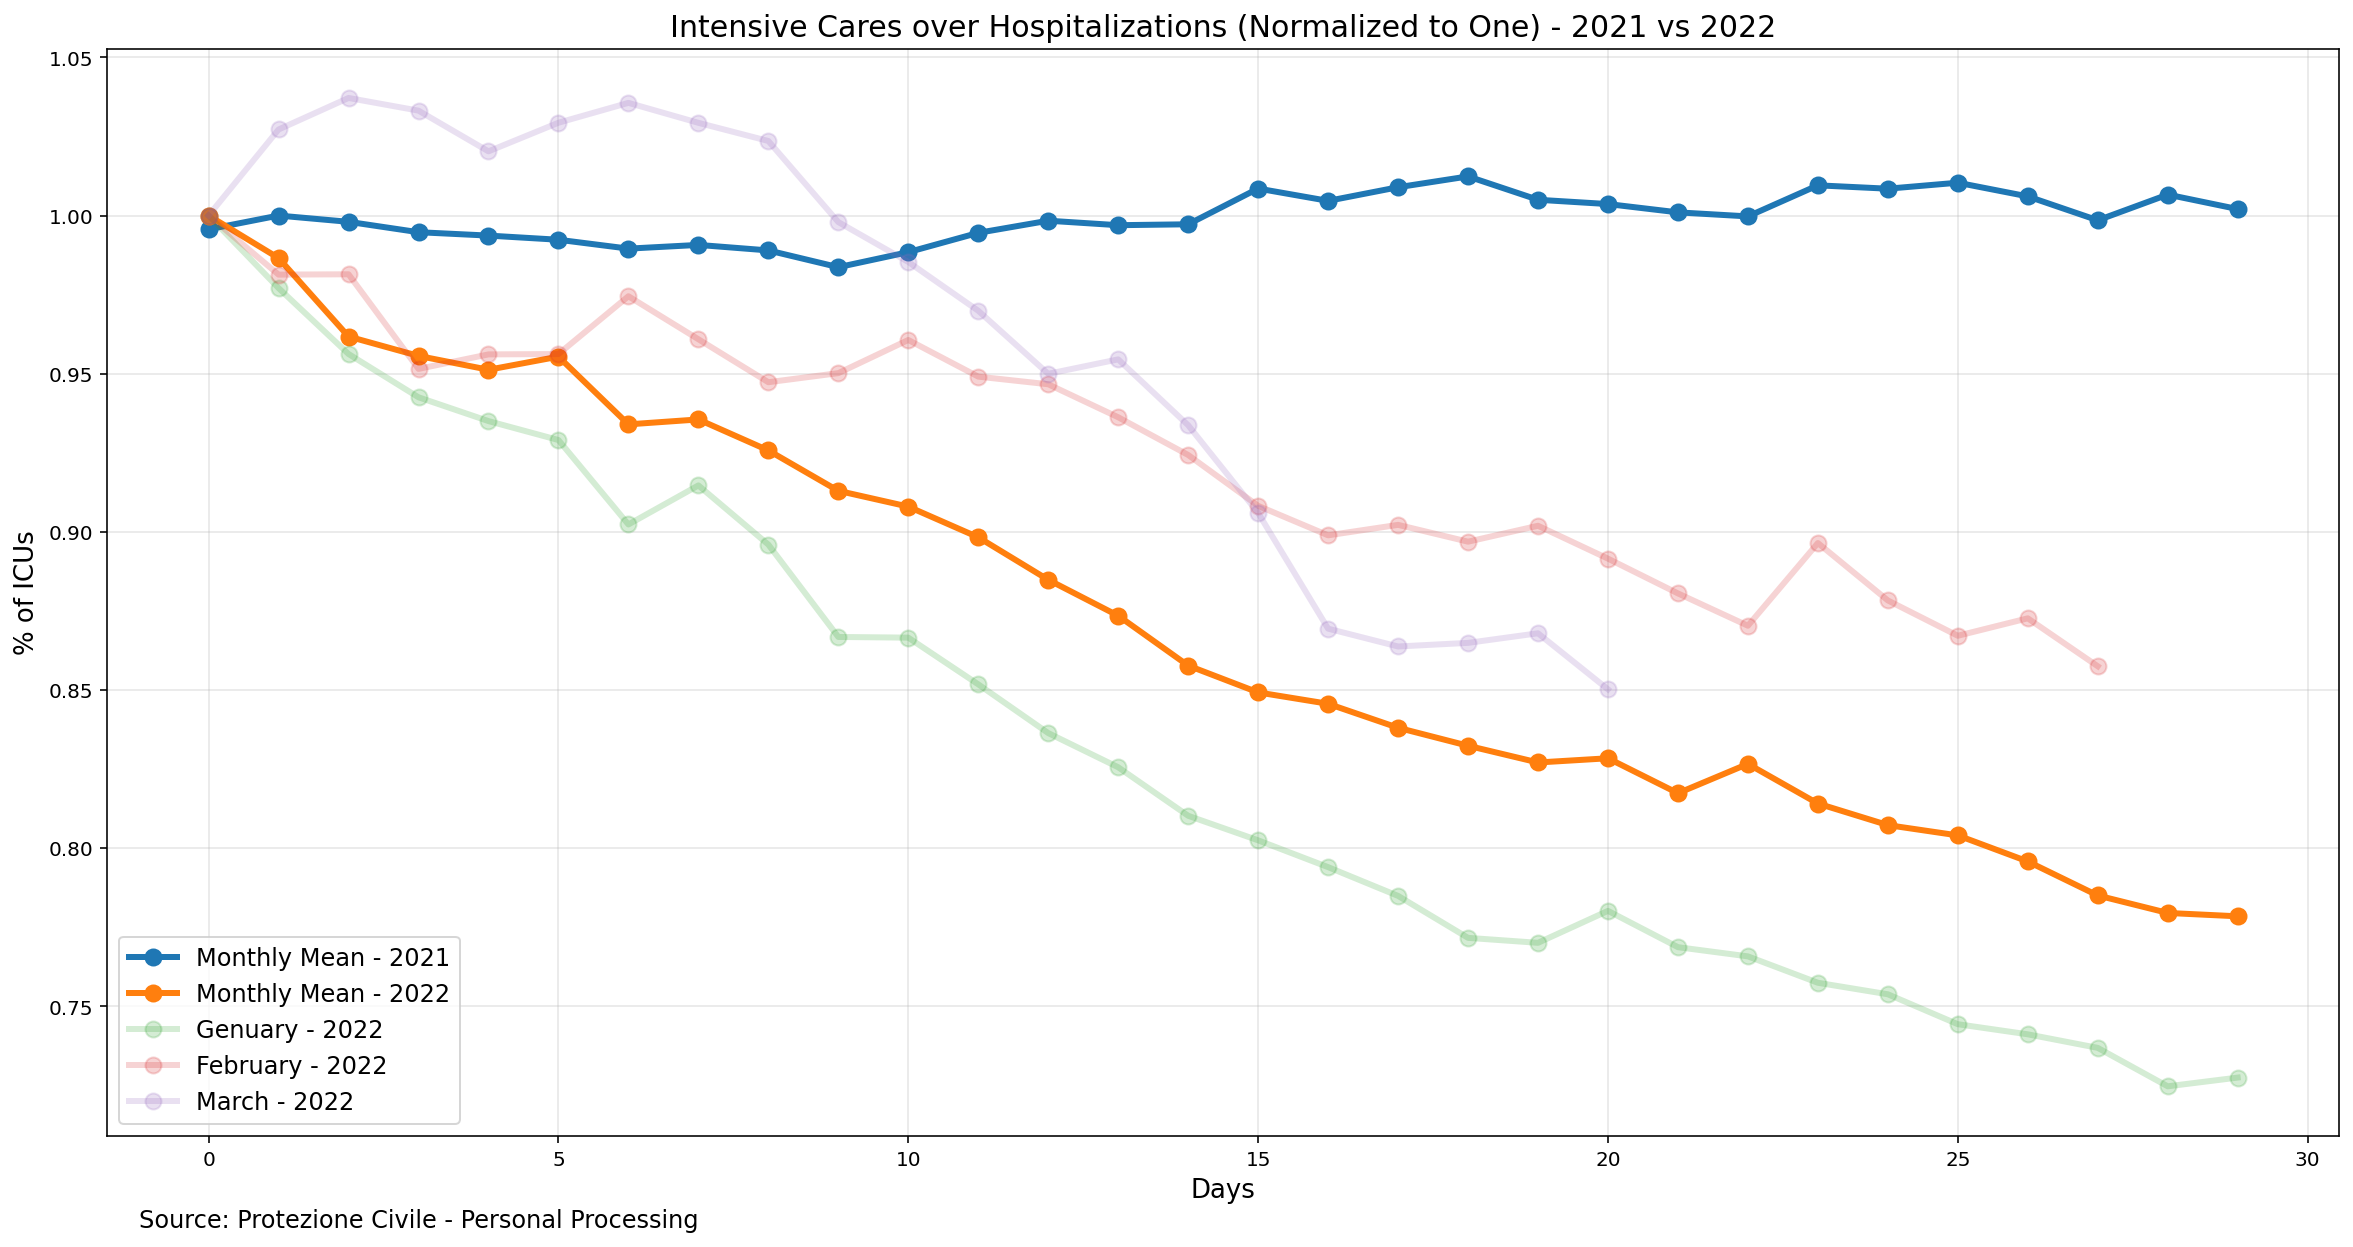

In [44]:
fig, ax = plt.subplots(figsize = (20,10))

y22_end = y22.reset_index().index[-1]
ax.plot(
    bymonth_mean.reset_index(drop=True).index[:-1], 
    bymonth_mean.reset_index(drop=True).div(bymonth_mean[1])[:-1], 
    linewidth = 3, marker = 'o', label = 'Monthly Mean - 2021', markersize = 8
)

ax.plot(
    bymonth_mean_22.index[:-1], 
    bymonth_mean_22.div(bymonth_mean_22[0])[:-1], 
    linewidth = 3, marker = 'o', label = 'Monthly Mean - 2022', markersize = 8
)

ax.plot(
    y22.days_since_start[:30], 
    y22.ti_osp.div(y22.ti_osp[0])[:30], 
    linewidth = 3, marker = 'o', alpha = .2,
    label = 'Genuary - 2022', markersize = 8
)

ax.plot(
    y22.days_since_start[:28], 
    y22.ti_osp.div(y22.ti_osp[30])[30:58], 
    linewidth = 3, marker = 'o', alpha = .2,
    label = 'February - 2022', markersize = 8
)

ax.plot(
    y22.days_since_start[:21], 
    y22.ti_osp.div(y22.ti_osp[58])[58:79], 
    linewidth = 3, marker = 'o', alpha = .2,
    label = 'March - 2022', markersize = 8
)

_ = ax.legend(fontsize = 12)
_ = ax.grid(alpha = .3)
_ = ax.set_title('Intensive Cares over Hospitalizations (Normalized to One) - 2021 vs 2022', fontsize = 15)
_ = ax.set_xlabel('Days', fontsize = 13)
_ = ax.set_ylabel('% of ICUs', fontsize = 13)
_ = ax.text(-1, 0.68, 'Source: Protezione Civile - Personal Processing', fontsize = 12)

In [45]:
bymonth_mean = pd.pivot_table(y21, index = 'day', columns = 'month', values = 'ti_osp').mean(axis = 1)
bymonth_std = pd.pivot_table(y21, index = 'day', columns = 'month', values = 'ti_osp').std(axis = 1)

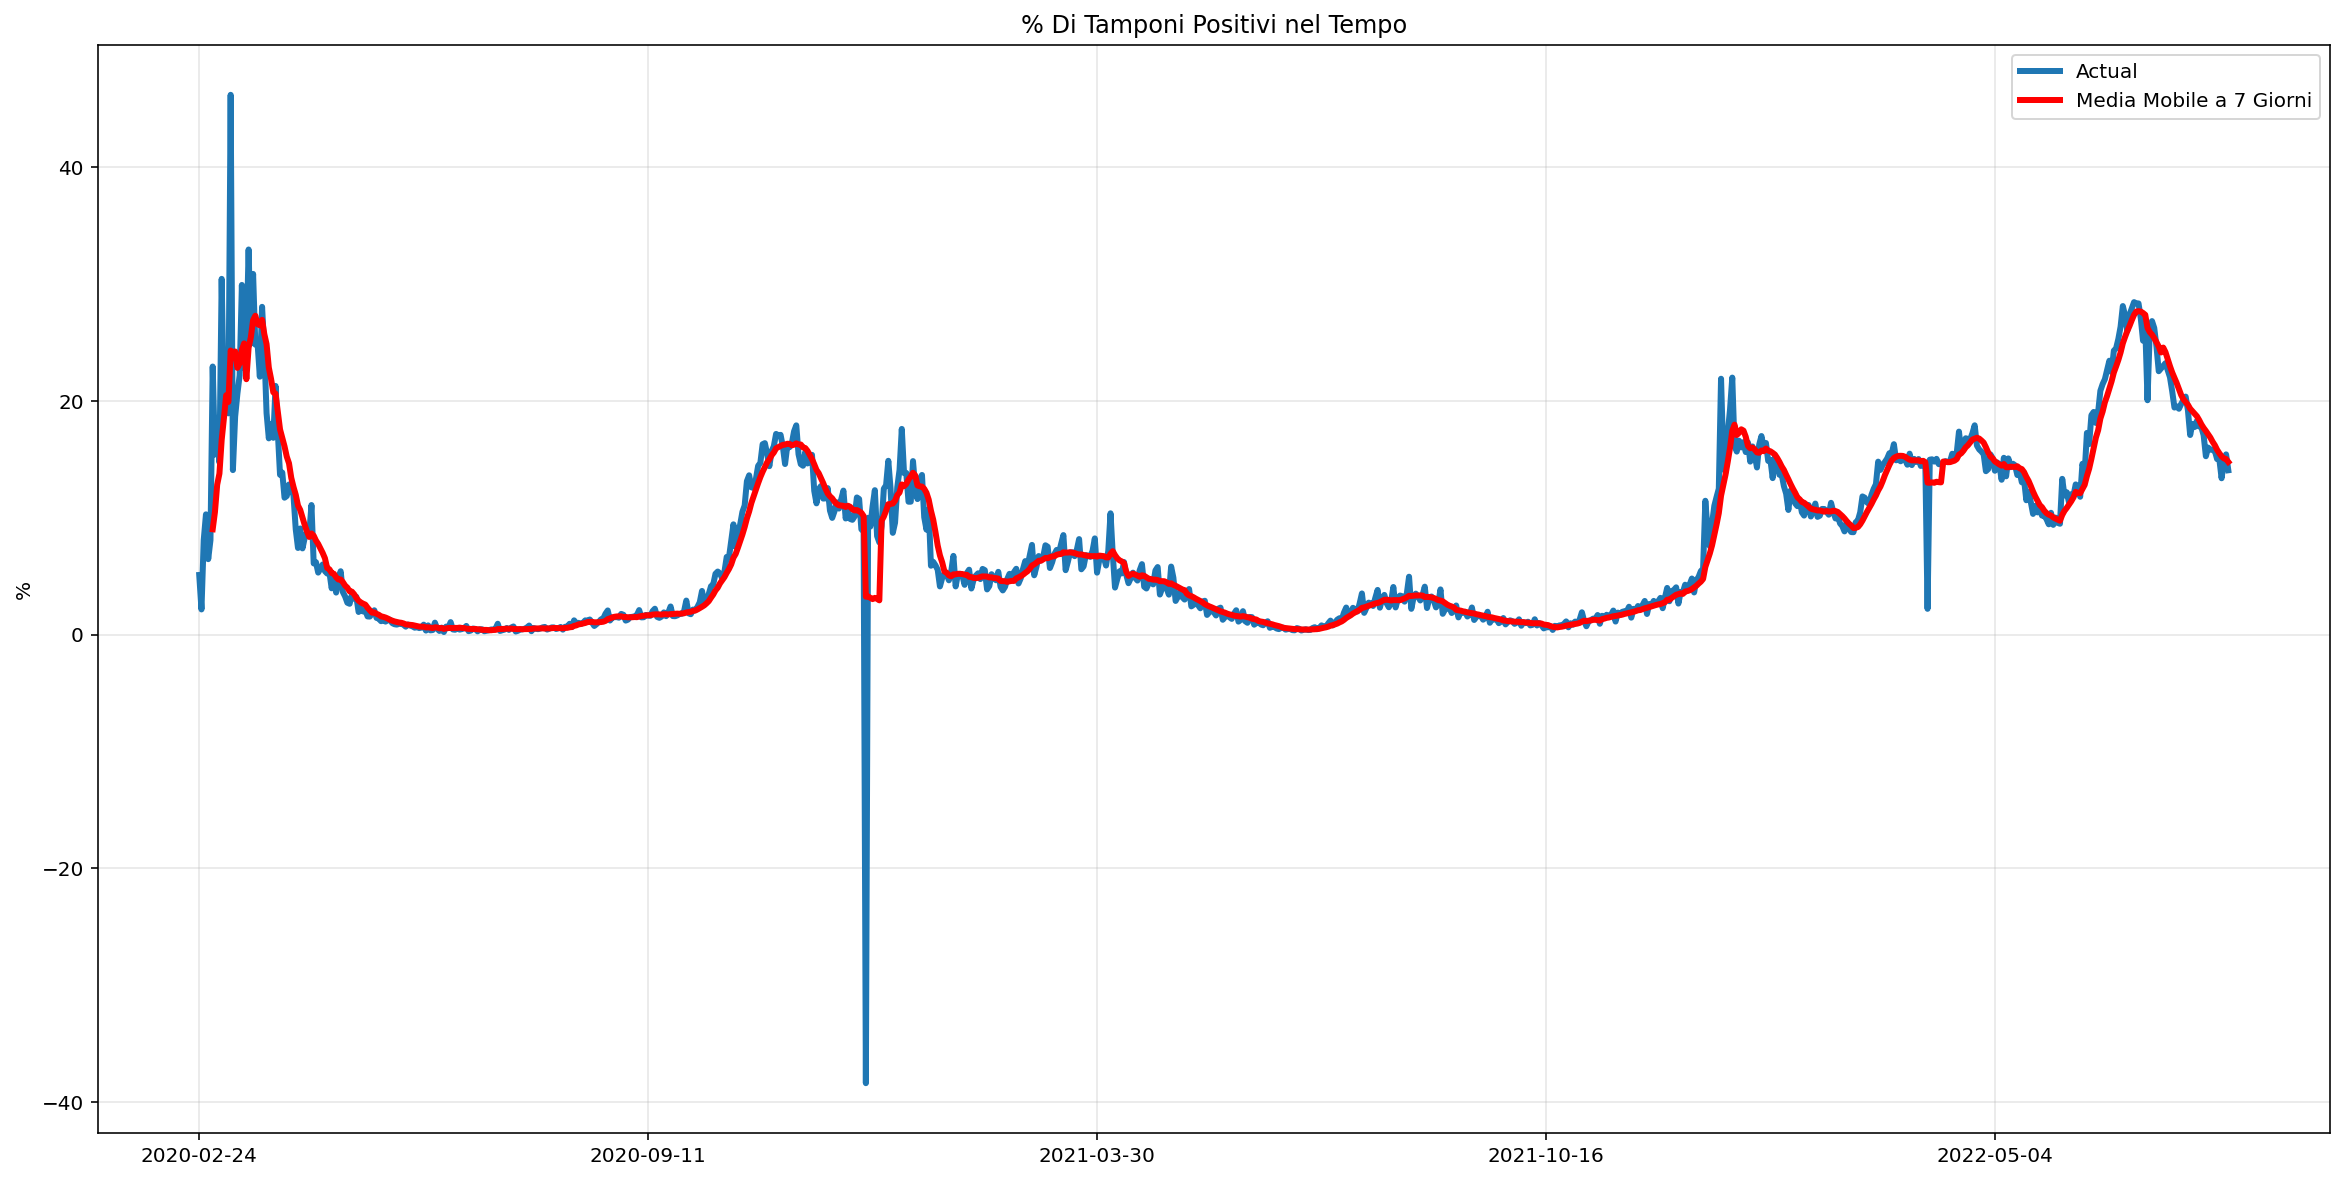

In [46]:
ti['pos_perc'] = (ti.nuovi_positivi / ti.diff_tamponi) * 100

fig, ax = plt.subplots(figsize = (20,10))

ti.pos_perc.plot(ax = ax, linewidth = 3, label = 'Actual')
ti.pos_perc.rolling(7).mean().plot(ax = ax, linewidth = 3, c = 'r', label = 'Media Mobile a 7 Giorni')
_ = ax.legend()
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('%')
_ = ax.set_title('% Di Tamponi Positivi nel Tempo')

In [47]:
ti['pos_perc_firstder'] = ti.pos_perc.diff()

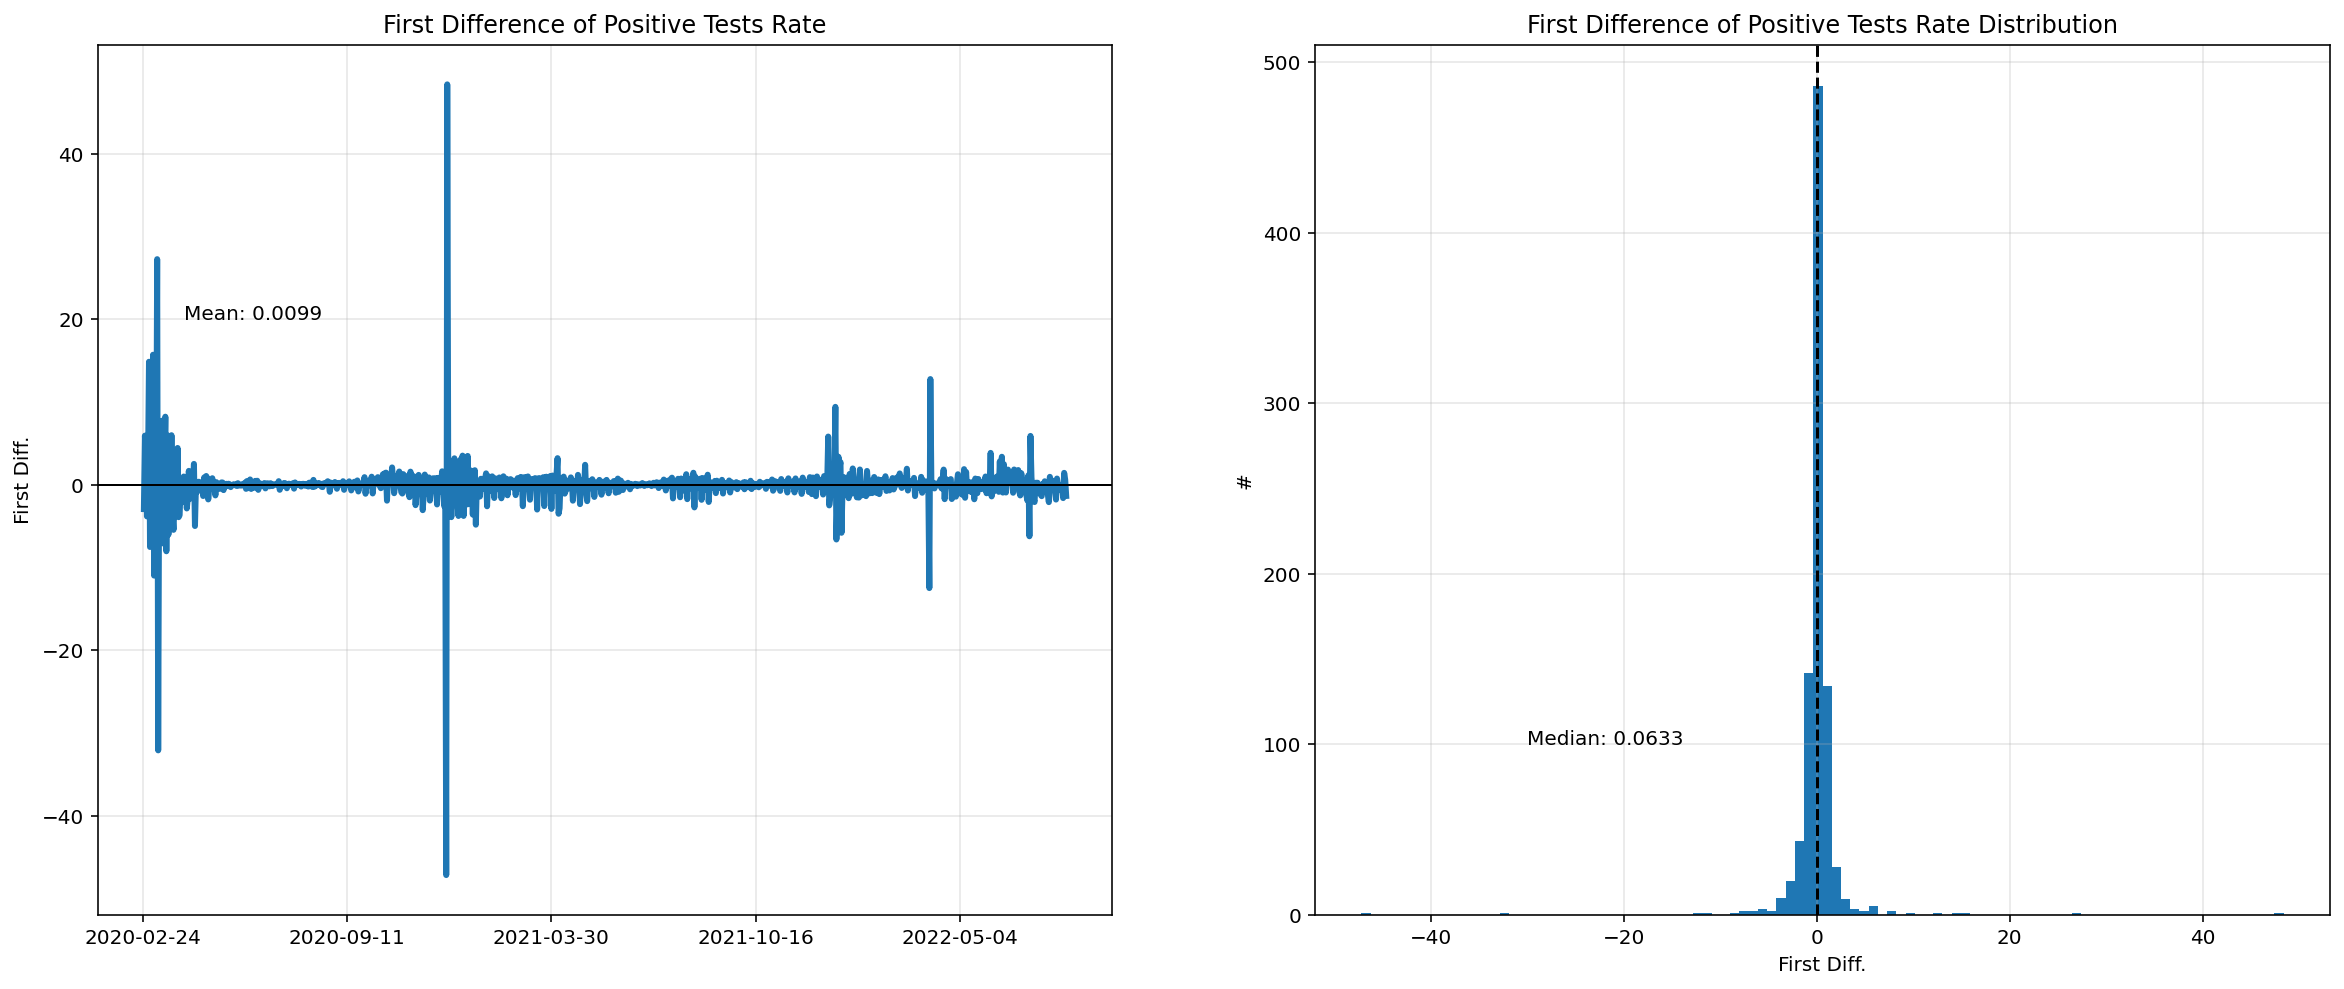

In [48]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ti.pos_perc_firstder.plot(ax = ax[0], linewidth = 3)
ti.pos_perc_firstder.hist(ax = ax[1], bins = 100)
_ = ax[0].axhline(ti.pos_perc_firstder.mean(), c = 'k', linewidth = 1)
_ = ax[1].axvline(ti.pos_perc_firstder.median(), c = 'k', linestyle = '--')
_ = ax[0].set_xlabel('')
_ = ax[0].text(40, 20, f'Mean: {round(ti.pos_perc_firstder.mean(),4)}')
_ = ax[1].text(-30, 100, f'Median: {round(ti.pos_perc_firstder.median(),4)}')

for n, _ in enumerate(ax):
    _ = ax[n].grid(alpha=.3)
    _ = ax[n].set_title(['First Difference of Positive Tests Rate', 'First Difference of Positive Tests Rate Distribution'][n])
    _ = ax[n].set_ylabel(['First Diff.', '#'][n])
    _ = ax[n].set_xlabel(['', 'First Diff.'][n])

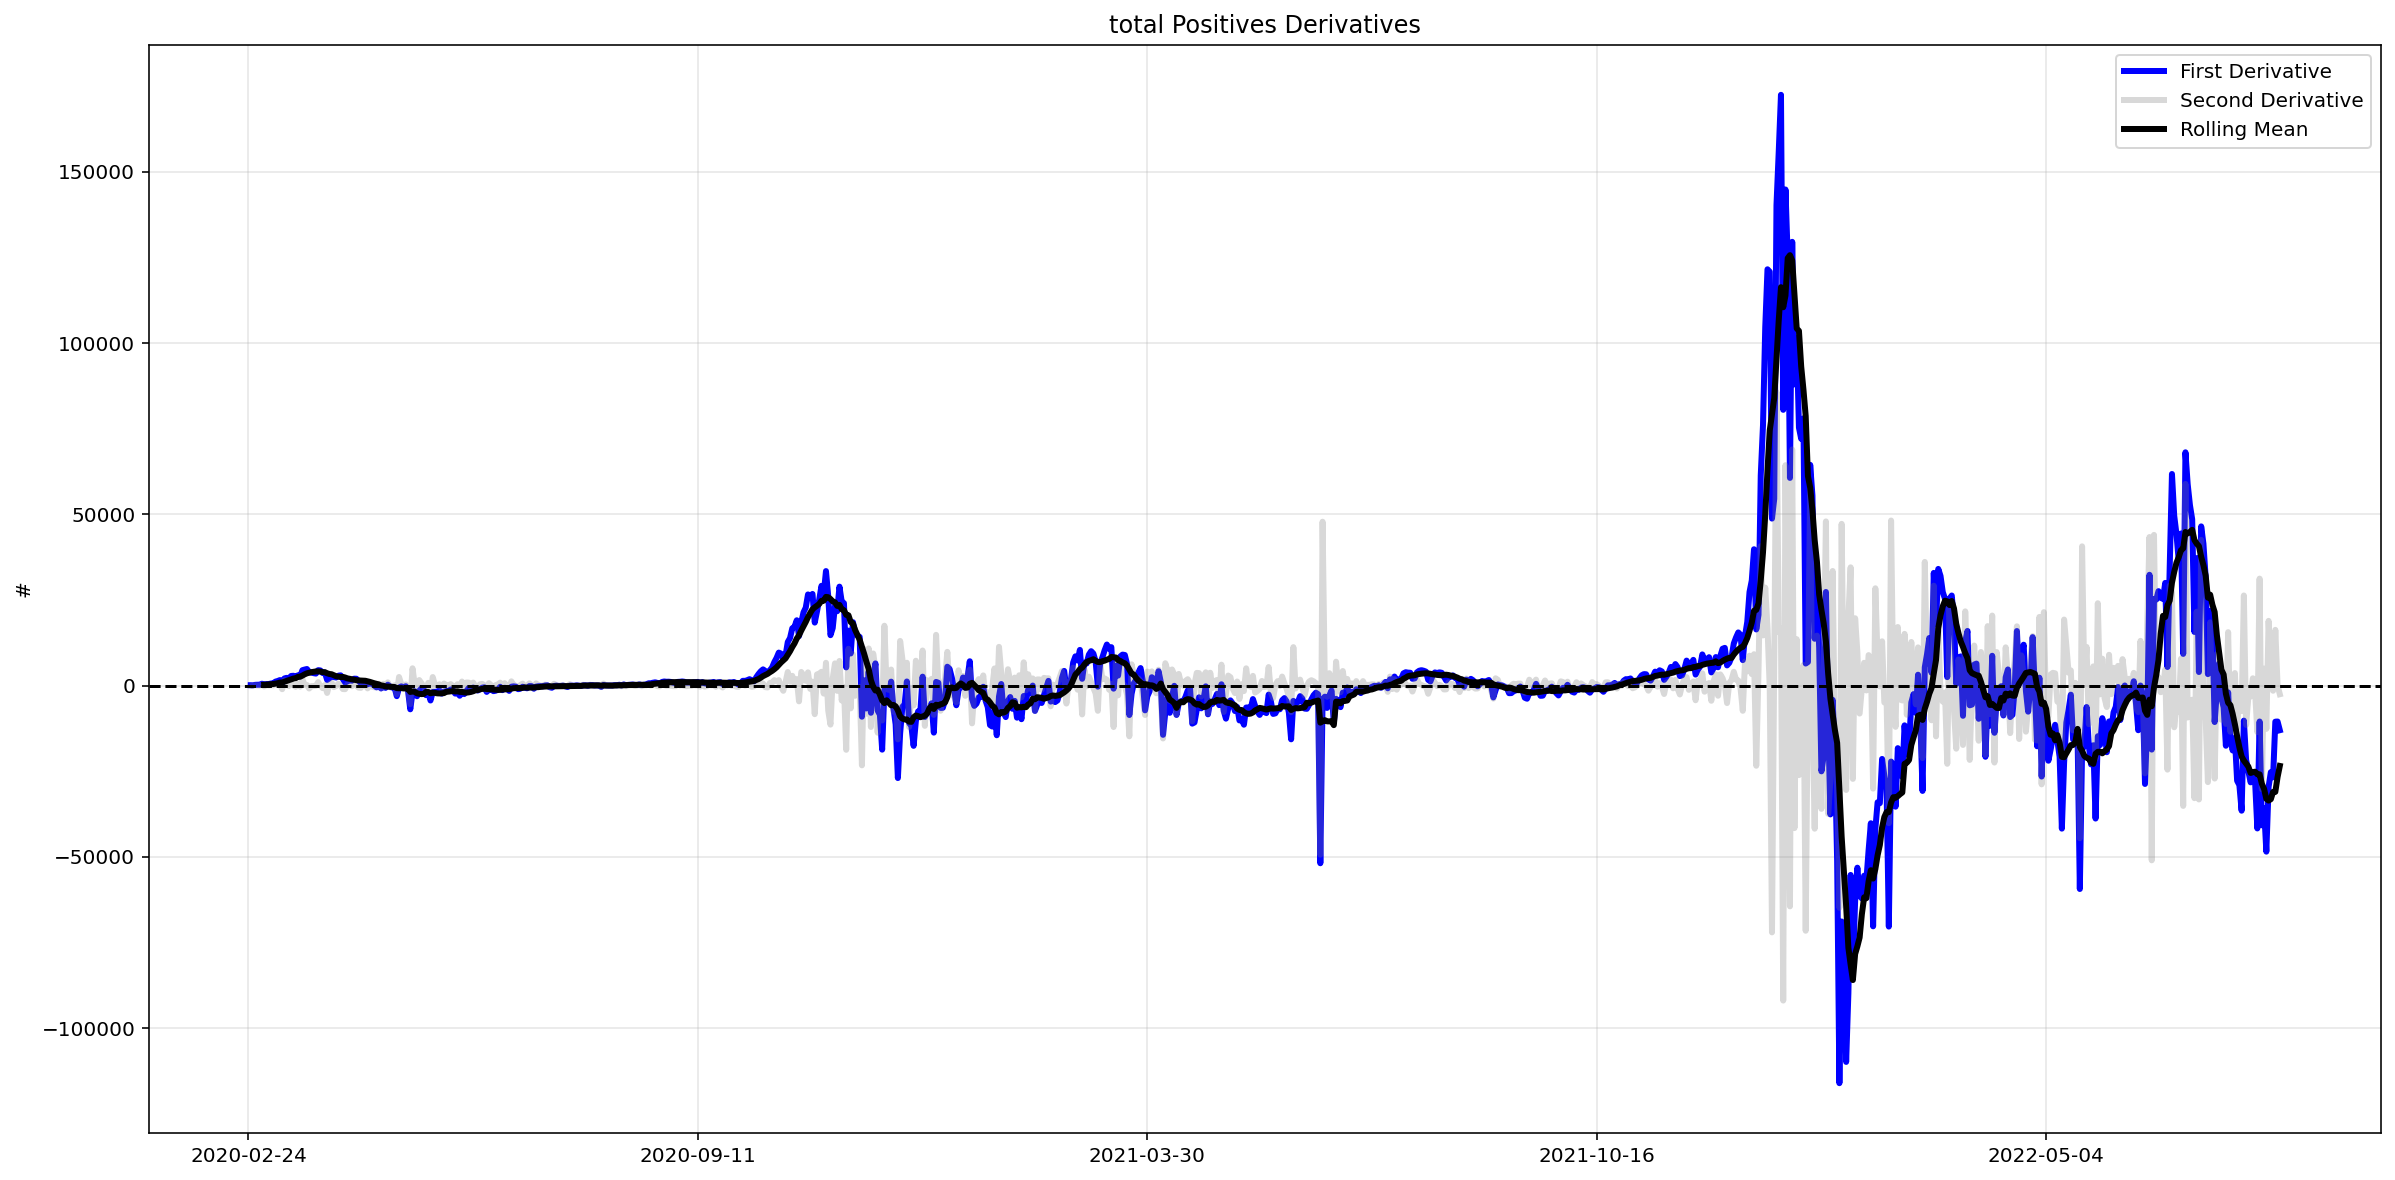

In [49]:
d_pos = ti.totale_positivi.diff()
d2_pos = d_pos.diff()
ti['d_pos'] = d_pos

fig, ax = plt.subplots(figsize=(20,10))

d_pos.plot(ax=ax, linewidth=3, label = 'First Derivative', c = 'b')
d2_pos.plot(ax=ax, linewidth=3, c='grey', label = 'Second Derivative', alpha = .3)
d_pos.rolling(7).mean().plot(ax=ax, linewidth=3, c = 'k', label = 'Rolling Mean')
_ = ax.legend()
_ = ax.axhline(0, c='k', linestyle='--')
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('#')
_ = ax.set_title('total Positives Derivatives')

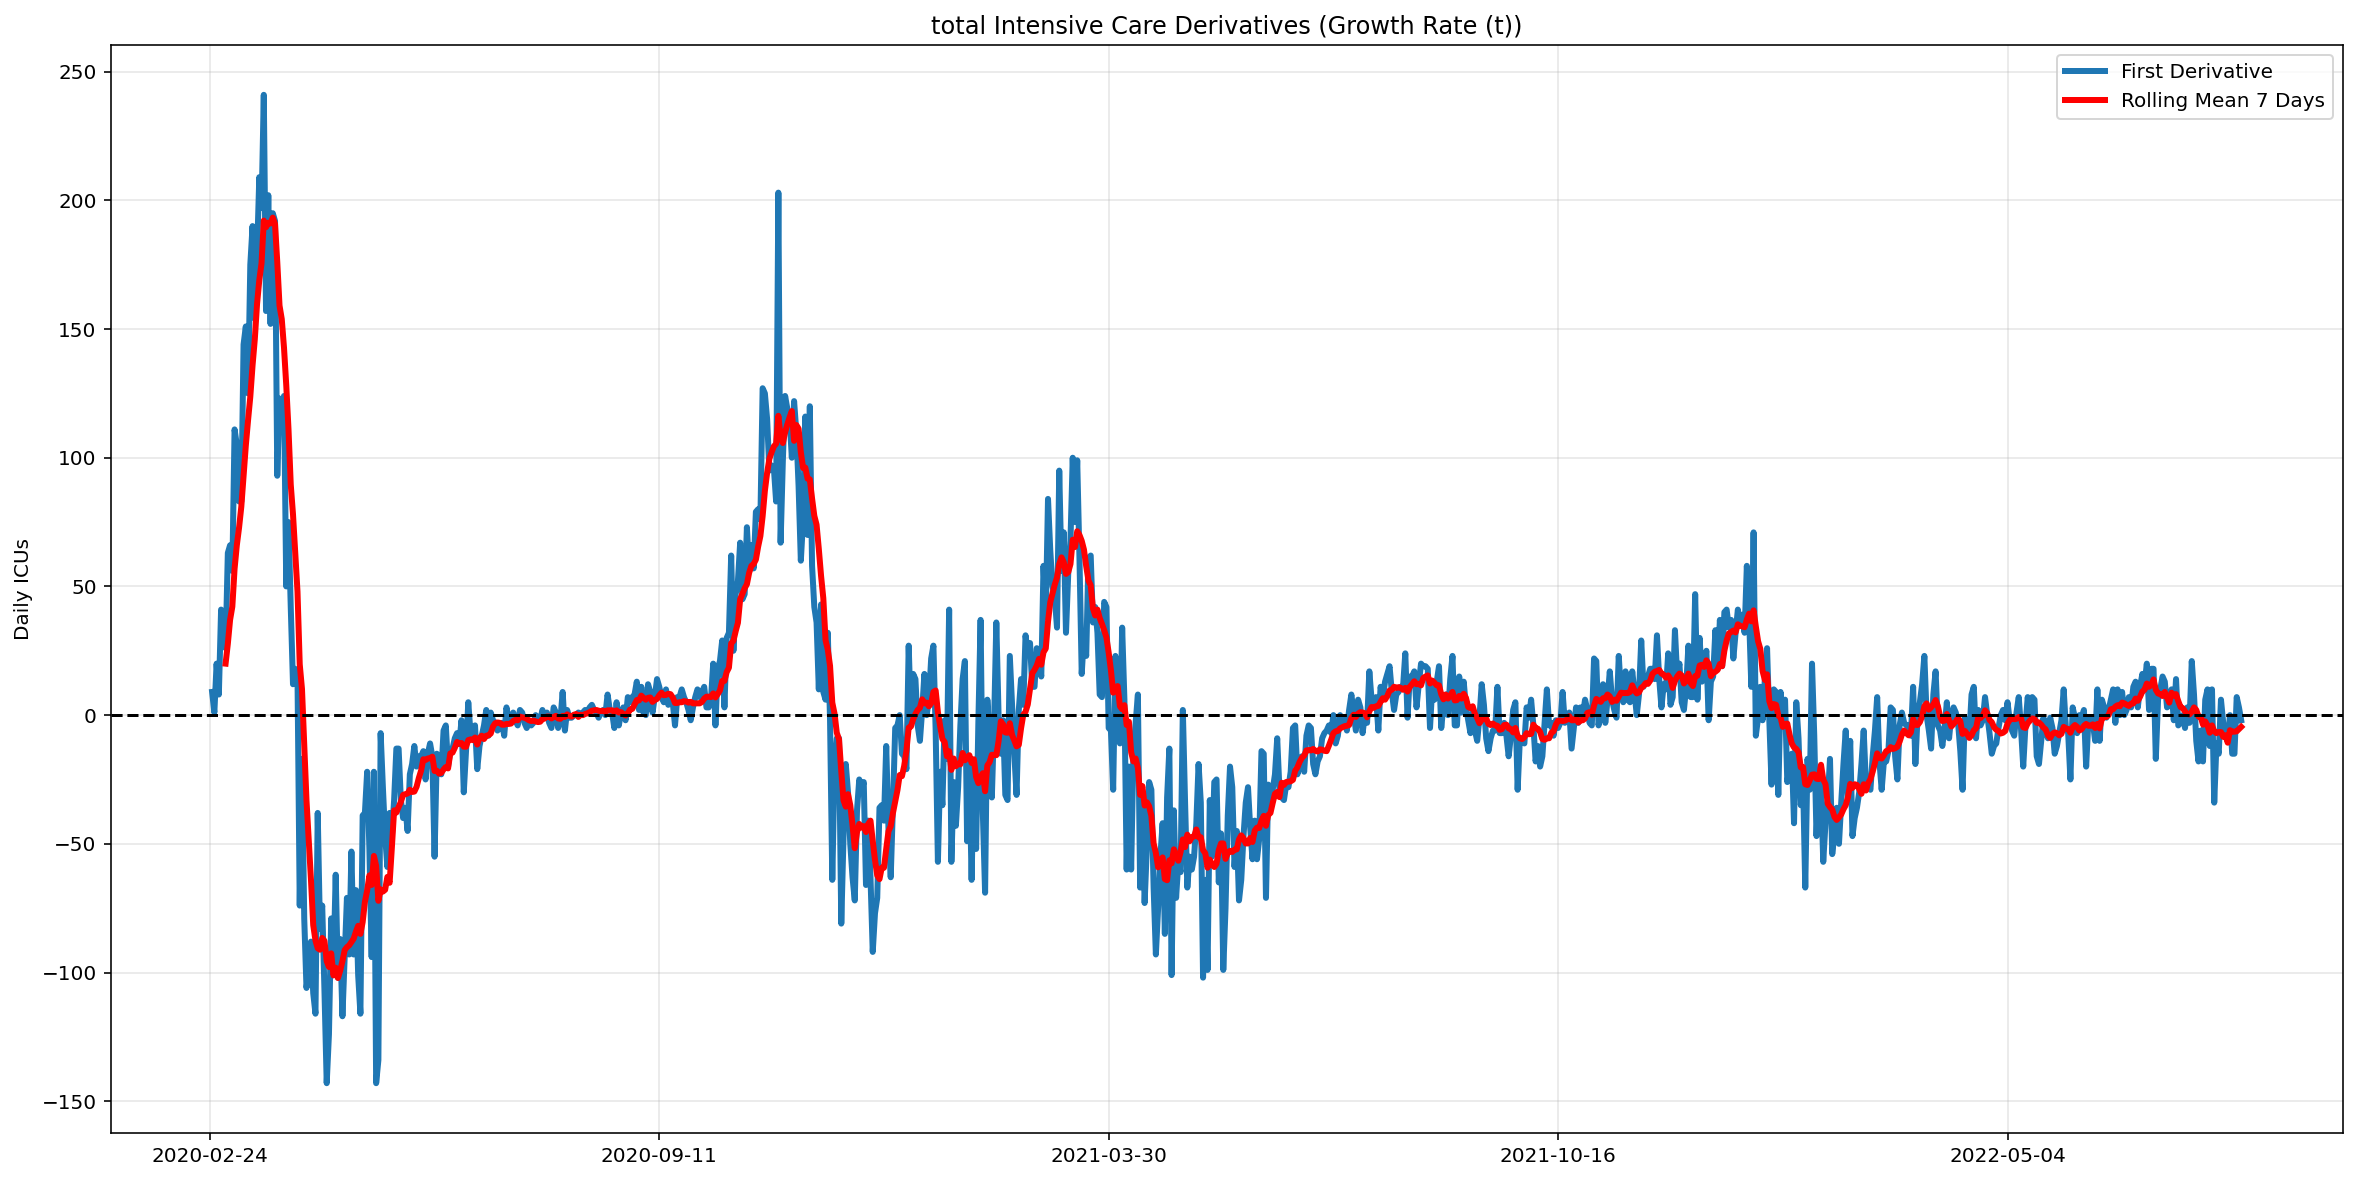

In [50]:
d_ti = ti.terapia_intensiva.diff()
d2_ti = d_ti.diff()
ti['d_pos'] = d_pos

fig, ax = plt.subplots(figsize=(20,10))

d_ti.plot(ax=ax, linewidth=3, label = 'First Derivative')
d_ti.rolling(7).mean().plot(ax=ax, linewidth=3, c='r', label = 'Rolling Mean 7 Days')
_ = ax.legend()
_ = ax.axhline(0, c='k', linestyle='--')
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Daily ICUs')
_ = ax.set_title('total Intensive Care Derivatives (Growth Rate (t))')

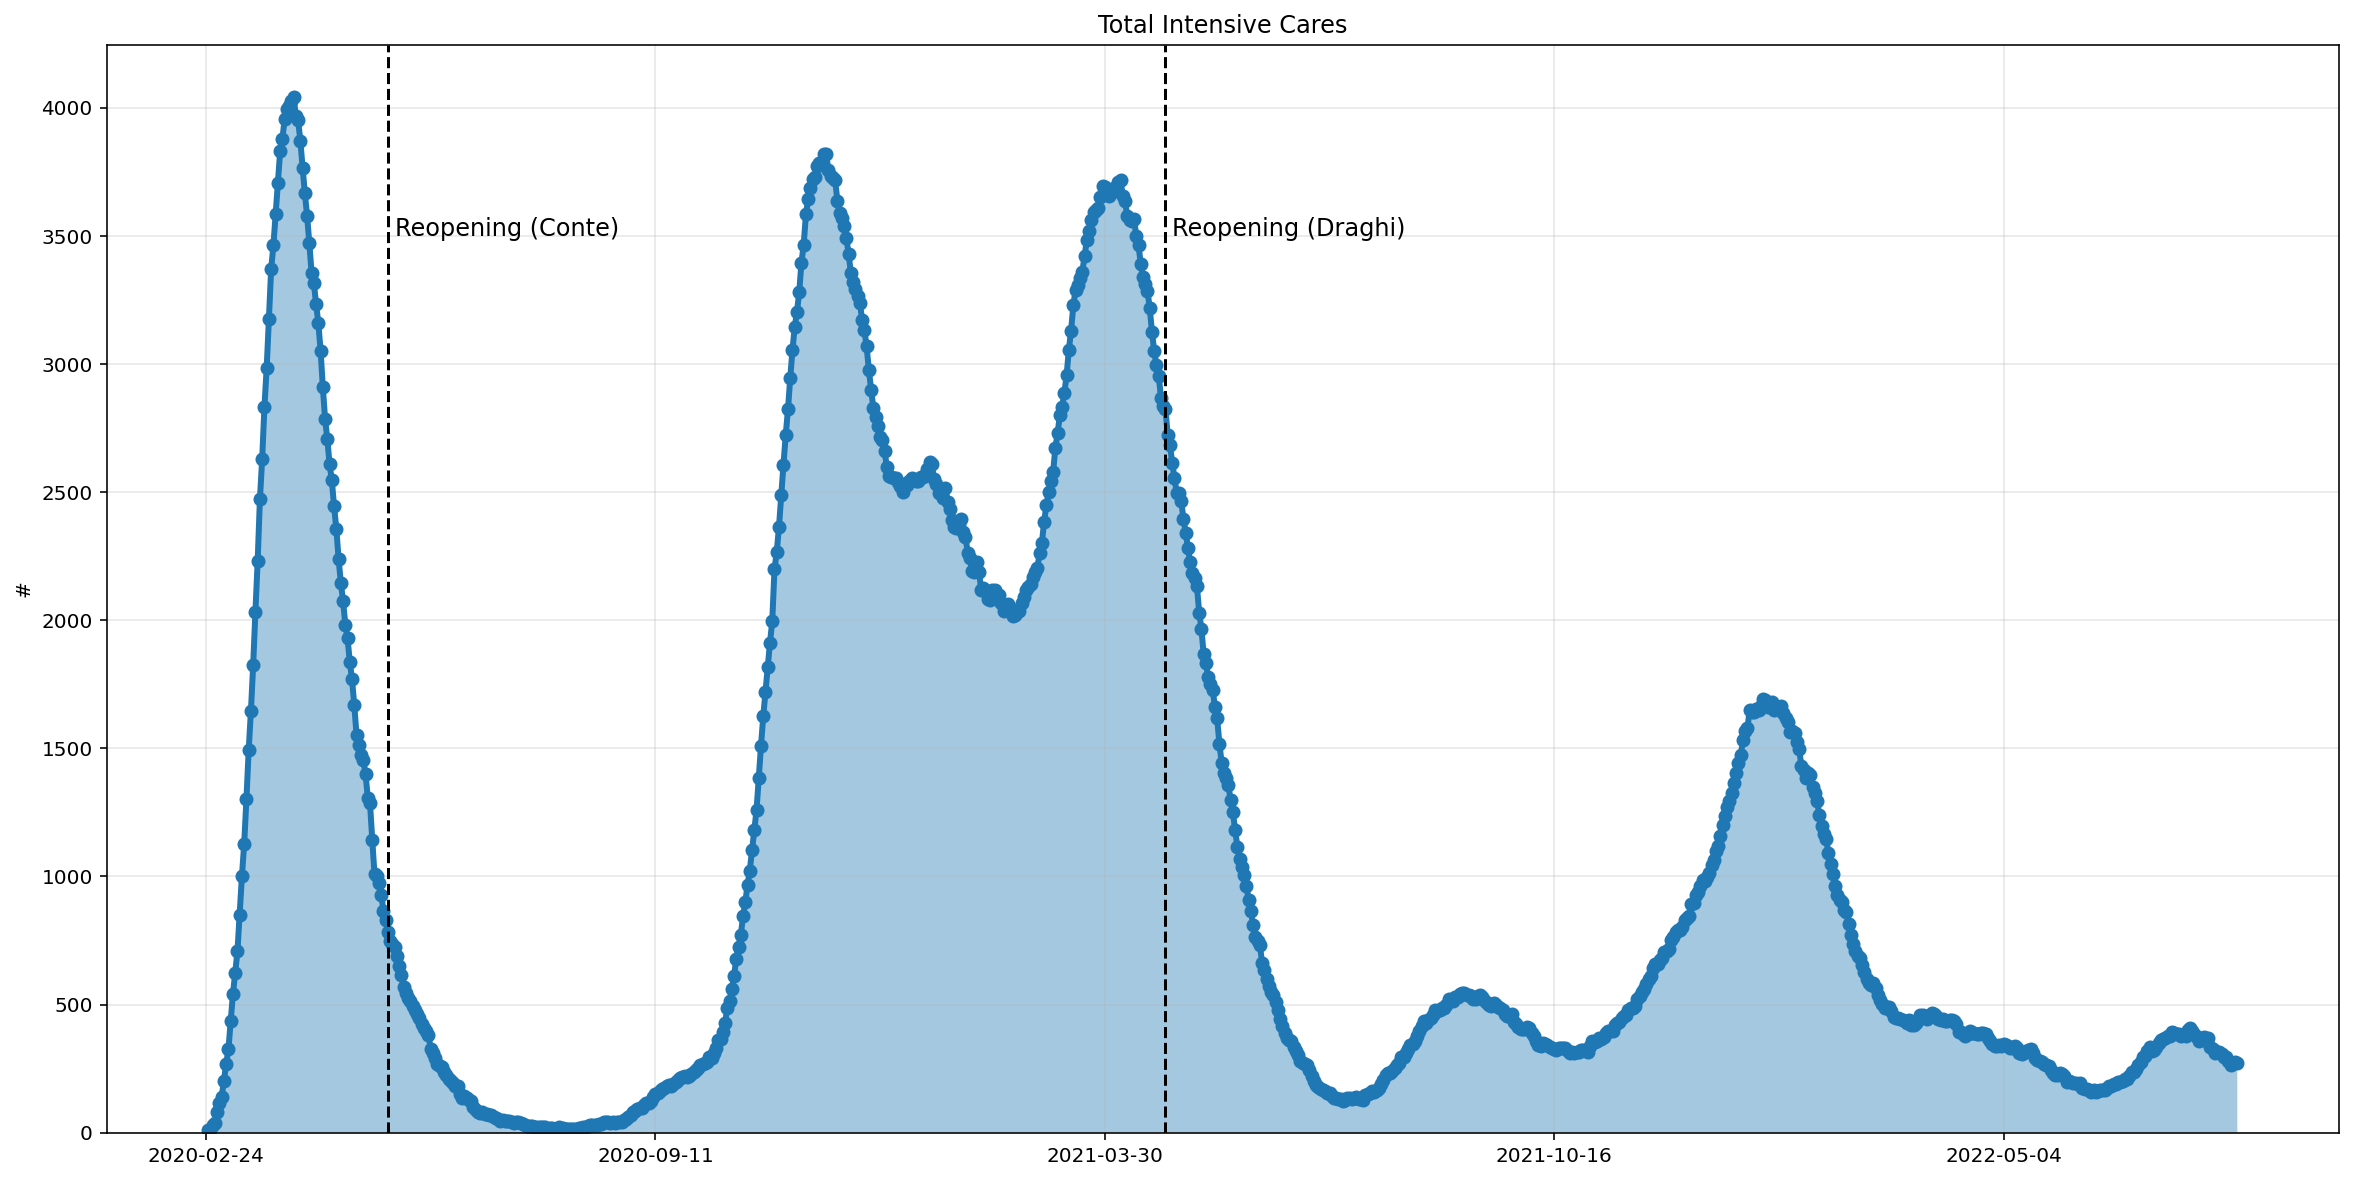

In [51]:
fig, ax = plt.subplots(figsize=(20,10))

draghi_reop = (pd.to_datetime('2021-04-26') - pd.to_datetime(d_ti.index[0])).days
conte_reop = (pd.to_datetime('2020-05-15') - pd.to_datetime(d_ti.index[0])).days
d_ti.cumsum().plot(ax=ax, linewidth = 3, marker = 'o')
_ = ax.fill_between(d_ti.cumsum().index, d_ti.cumsum(), alpha = .4)
_ = ax.grid(alpha = .3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('#')
_ = ax.set_title('Total Intensive Cares')
_ = ax.axvline(draghi_reop, c = 'k', linestyle = '--')
_ = ax.axvline(conte_reop, c = 'k', linestyle = '--')
_ = ax.text(draghi_reop+3, 3500, 'Reopening (Draghi)', fontsize = 12)
_ = ax.text(conte_reop+3, 3500, 'Reopening (Conte)', fontsize = 12)
_ = ax.set_ylim(0)

Nowdays excess of deaths respect to the same period of 2020 is crearly explained by this plot: the first re-opening was made with about 750 ICU patients, while the second re-opening was made with almost 3000 ICU patients. By now, the number of ICU patients is more than double last year. 

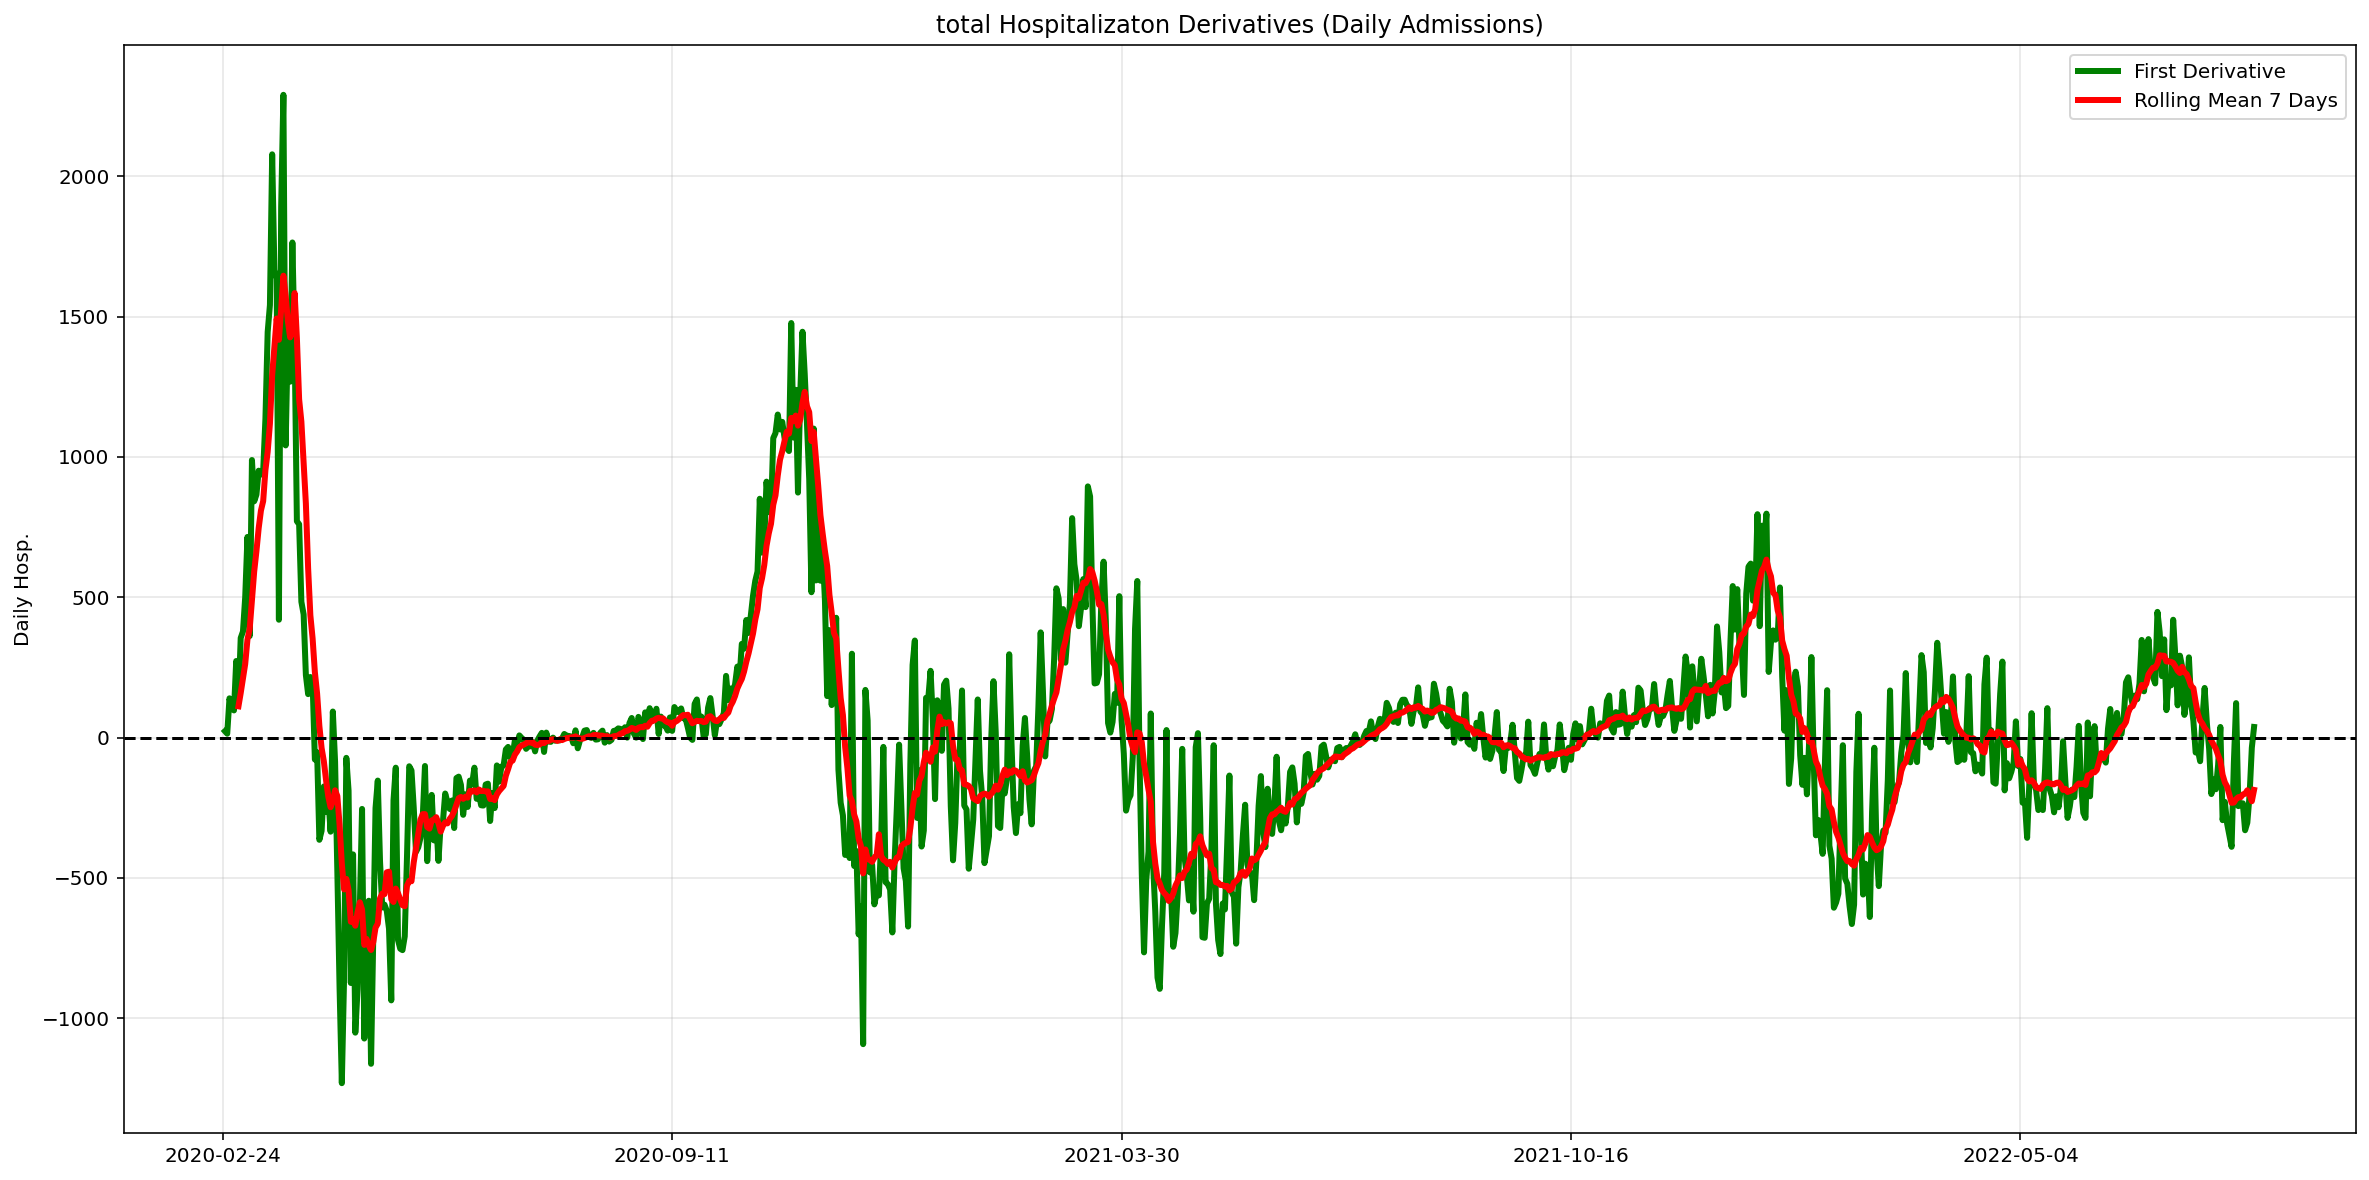

In [52]:
d_osp = ti.ospedalizzati.diff()
d2_osp = d_osp.diff()

fig, ax = plt.subplots(figsize=(20,10))

d_osp.plot(ax=ax, linewidth=3, label = 'First Derivative', c = 'green')
d_osp.rolling(7).mean().plot(ax=ax, linewidth=3, c='r', label = 'Rolling Mean 7 Days')
_ = ax.legend()
_ = ax.axhline(0, c='k', linestyle='--')
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Daily Hosp.')
_ = ax.set_title('total Hospitalizaton Derivatives (Daily Admissions)')

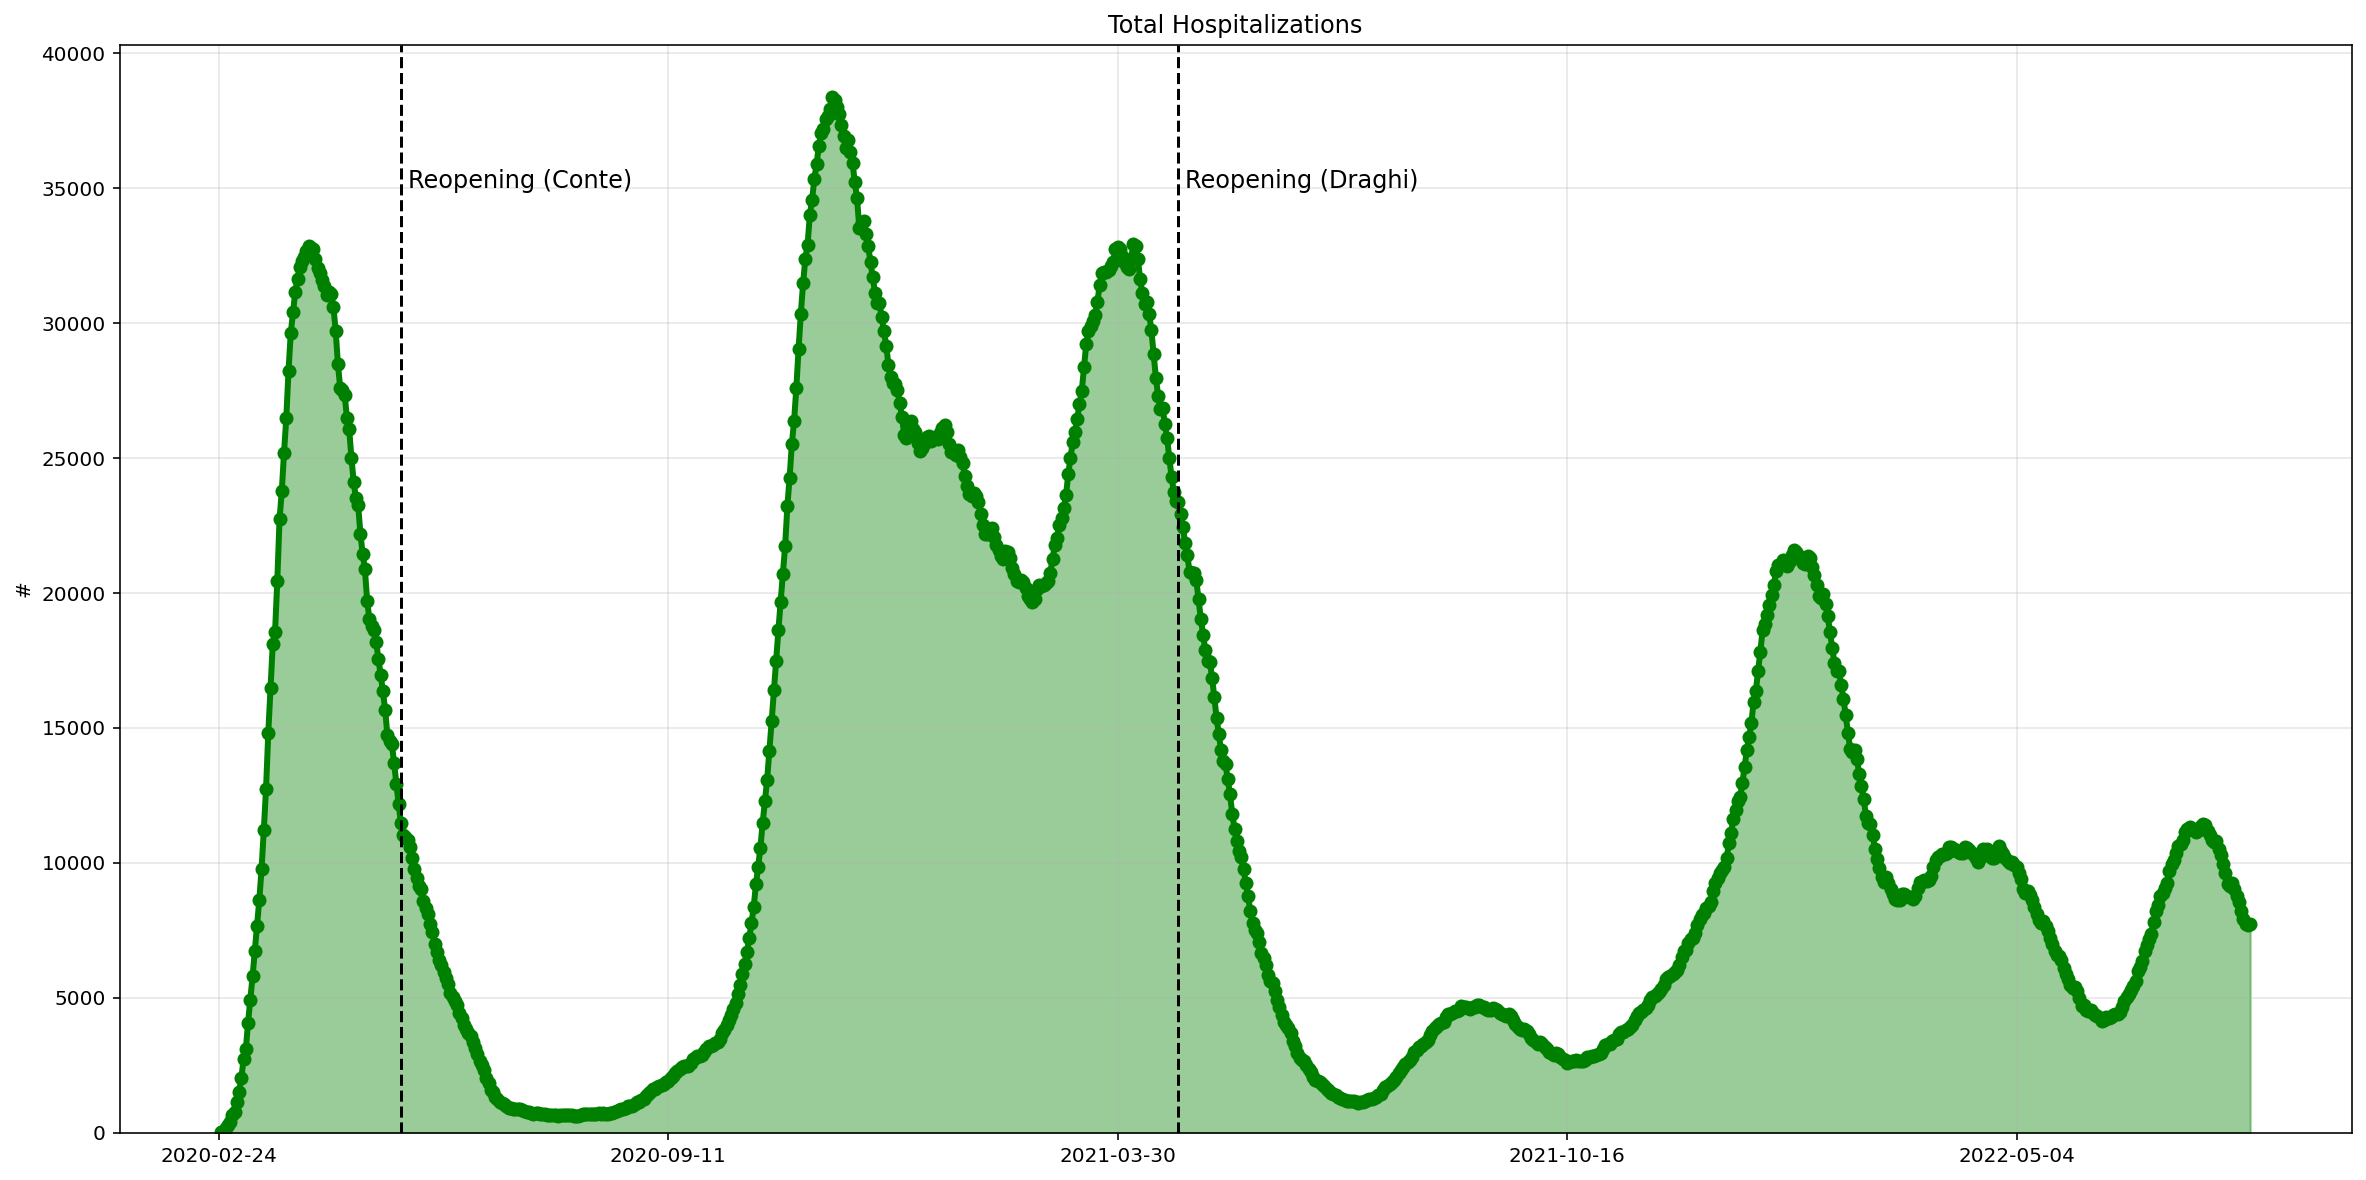

In [53]:
fig, ax = plt.subplots(figsize=(20,10))

draghi_reop = (pd.to_datetime('2021-04-26') - pd.to_datetime(d_ti.index[0])).days
conte_reop = (pd.to_datetime('2020-05-15') - pd.to_datetime(d_ti.index[0])).days
d_osp.cumsum().plot(ax=ax, linewidth = 3, marker = 'o', c = 'g')
_ = ax.fill_between(d_osp.cumsum().index, d_osp.cumsum(), alpha = .4, color = 'g')
_ = ax.grid(alpha = .3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('#')
_ = ax.set_title('Total Hospitalizations')
_ = ax.axvline(draghi_reop, c = 'k', linestyle = '--')
_ = ax.axvline(conte_reop, c = 'k', linestyle = '--')
_ = ax.text(draghi_reop+3, 35000, 'Reopening (Draghi)', fontsize = 12)
_ = ax.text(conte_reop+3, 35000, 'Reopening (Conte)', fontsize = 12)
_ = ax.set_ylim(0)

In [54]:
def std_scal(x):
    return pd.Series((x - np.mean(x)) / np.std(x))

def minmax(x):
    return pd.Series((x - x.min()) / (x.max() - x.min()))

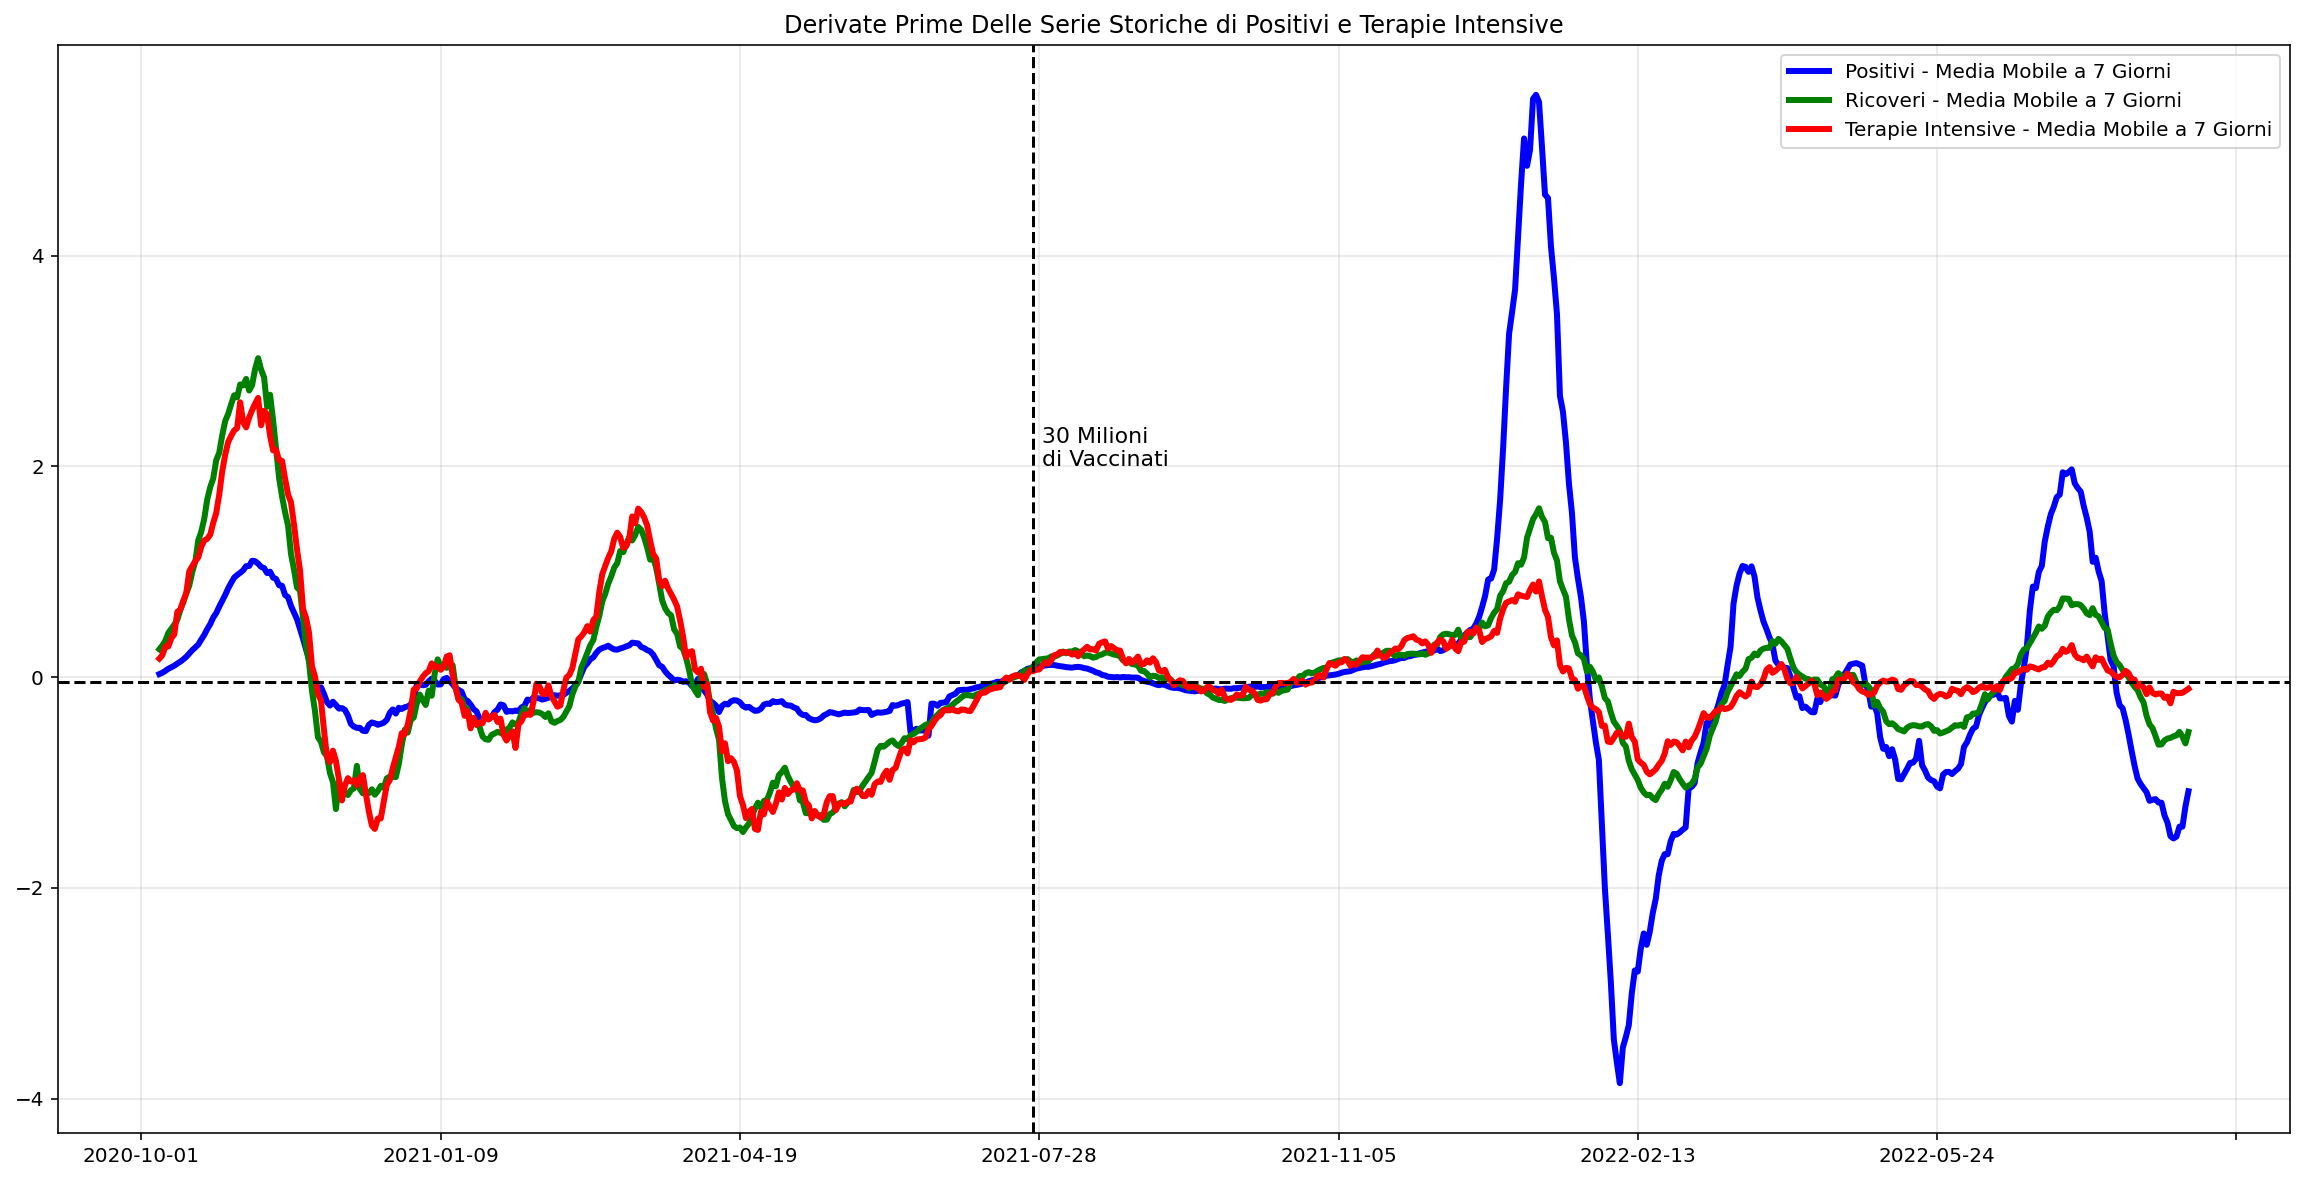

In [55]:
d_ti = ti.terapia_intensiva.diff()
d_osp = ti.ricoverati.diff()
d_deac = ti.deceduti.diff()
d2_ti = d_ti.diff()
std_zero = (0 - np.mean(d_pos)) / np.std(d_pos)

fig, ax = plt.subplots(figsize=(20,10))

std_scal(d_pos)[220:].rolling(7).mean().plot(ax=ax, linewidth=3, c = 'b', label = 'Positivi - Media Mobile a 7 Giorni')
std_scal(d_osp)[220:].rolling(7).mean().plot(ax=ax, linewidth=3, c = 'g', label = 'Ricoveri - Media Mobile a 7 Giorni')
std_scal(d_ti)[220:].rolling(7).mean().plot(ax=ax, linewidth=3, c = 'r', label = 'Terapie Intensive - Media Mobile a 7 Giorni')
_ = ax.legend()
_ = ax.axhline(std_zero, c='k', linestyle='--')
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('')
_ = ax.set_title('Derivate Prime Delle Serie Storiche di Positivi e Terapie Intensive')
_ = ax.axvline(trentaM-220, c = 'k', linestyle = '--')
_ = ax.text(trentaM-220+3, 2, '30 Milioni \ndi Vaccinati', fontsize = 11)

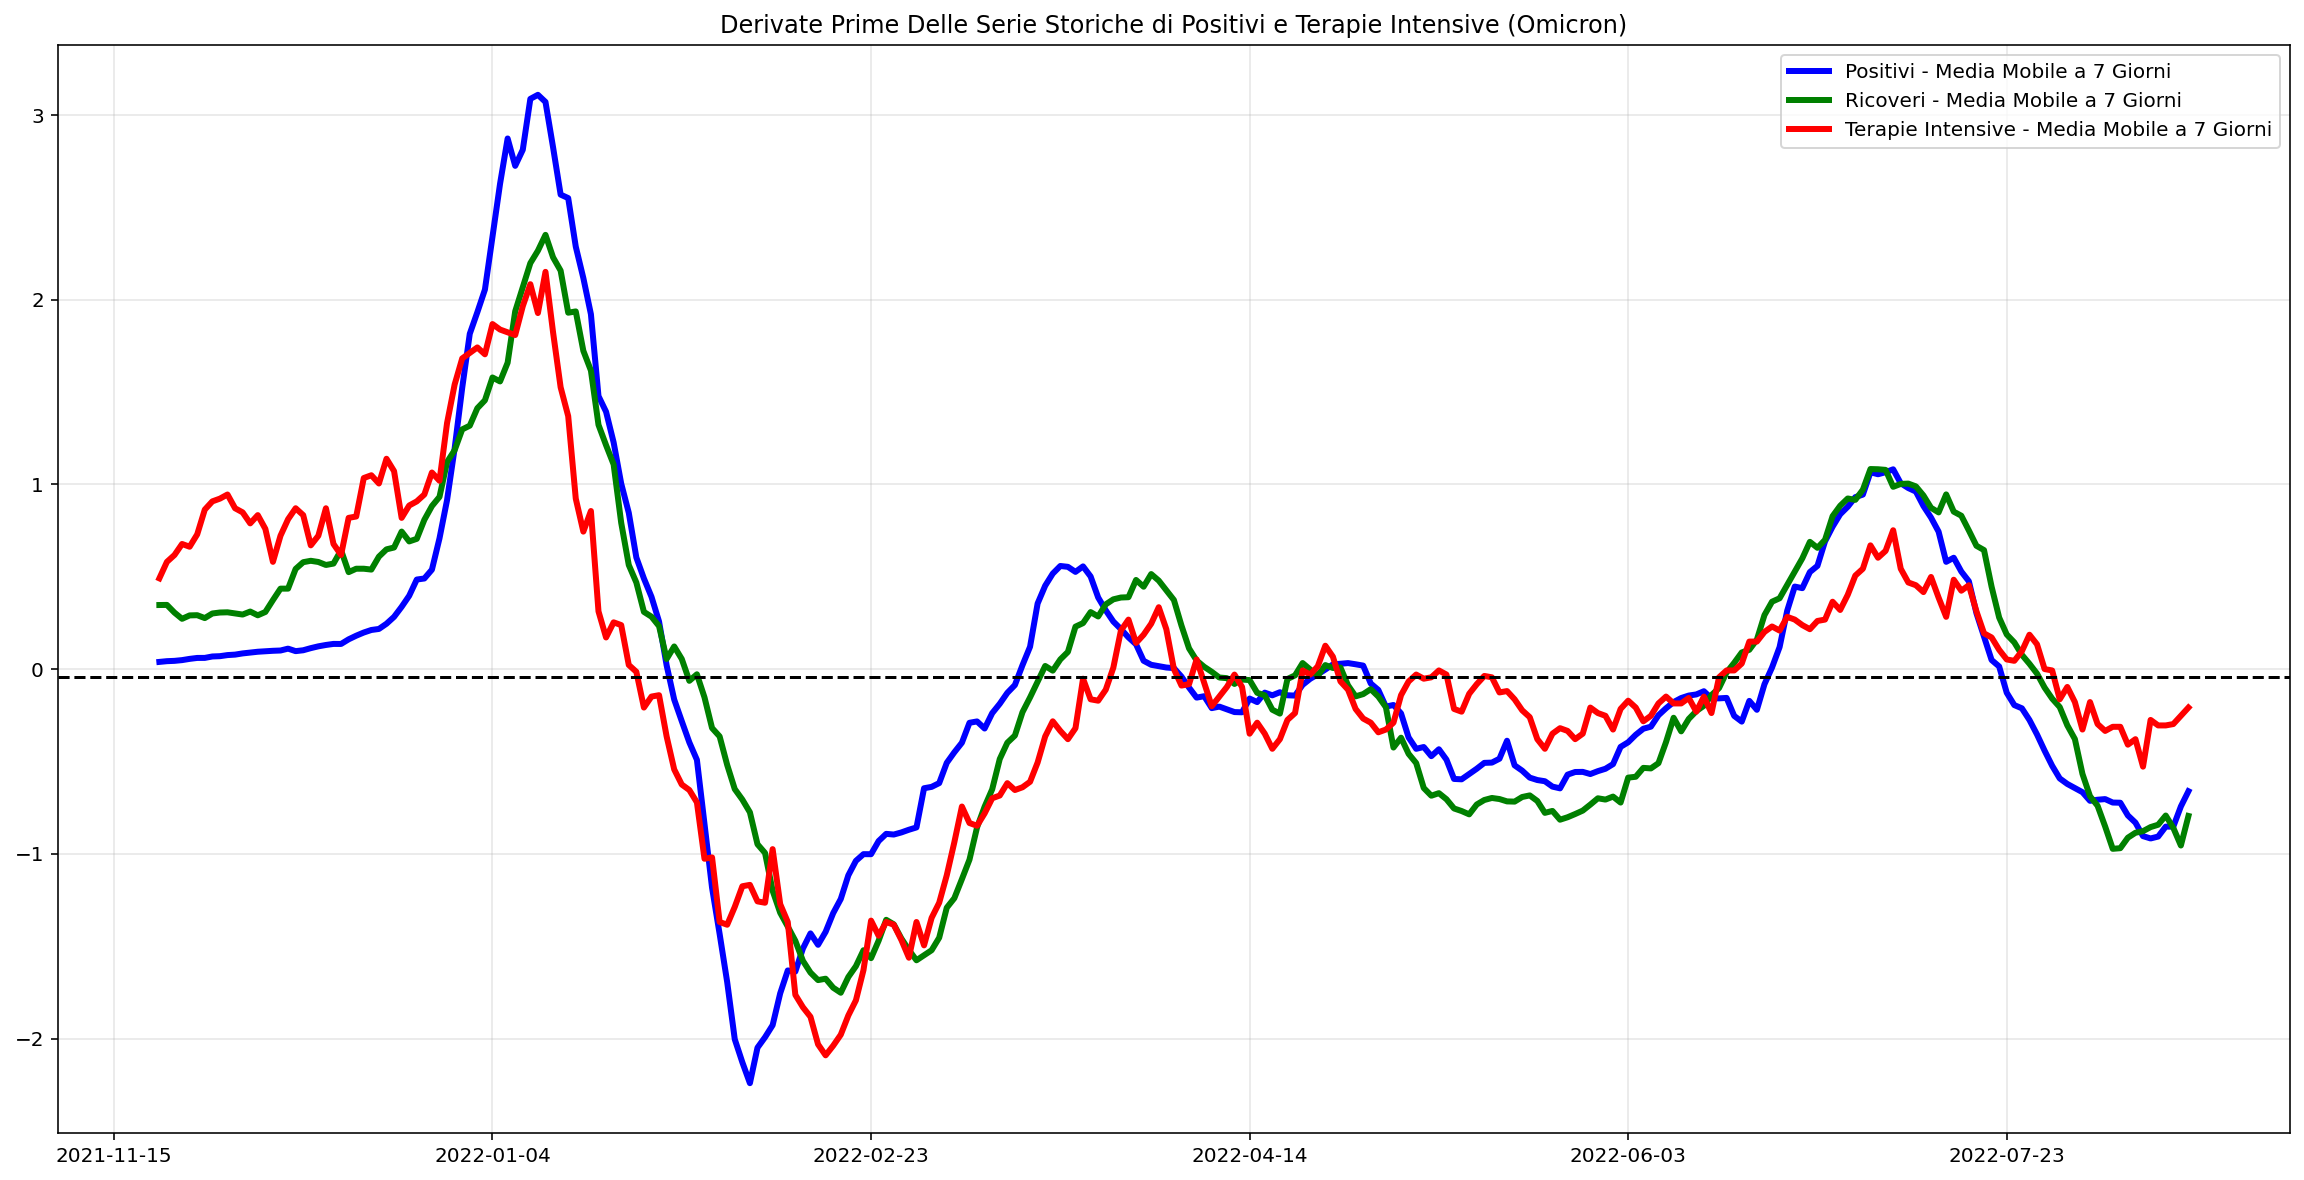

In [56]:
fig, ax = plt.subplots(figsize=(20,10))

std_scal(d_pos[630:]).rolling(7).mean().plot(ax=ax, linewidth=3, c = 'b', label = 'Positivi - Media Mobile a 7 Giorni')
std_scal(d_osp[630:]).rolling(7).mean().plot(ax=ax, linewidth=3, c = 'g', label = 'Ricoveri - Media Mobile a 7 Giorni')
std_scal(d_ti[630:]).rolling(7).mean().plot(ax=ax, linewidth=3, c = 'r', label = 'Terapie Intensive - Media Mobile a 7 Giorni')
_ = ax.legend()
_ = ax.axhline(std_zero, c='k', linestyle='--')
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('')
_ = ax.set_title('Derivate Prime Delle Serie Storiche di Positivi e Terapie Intensive (Omicron)')

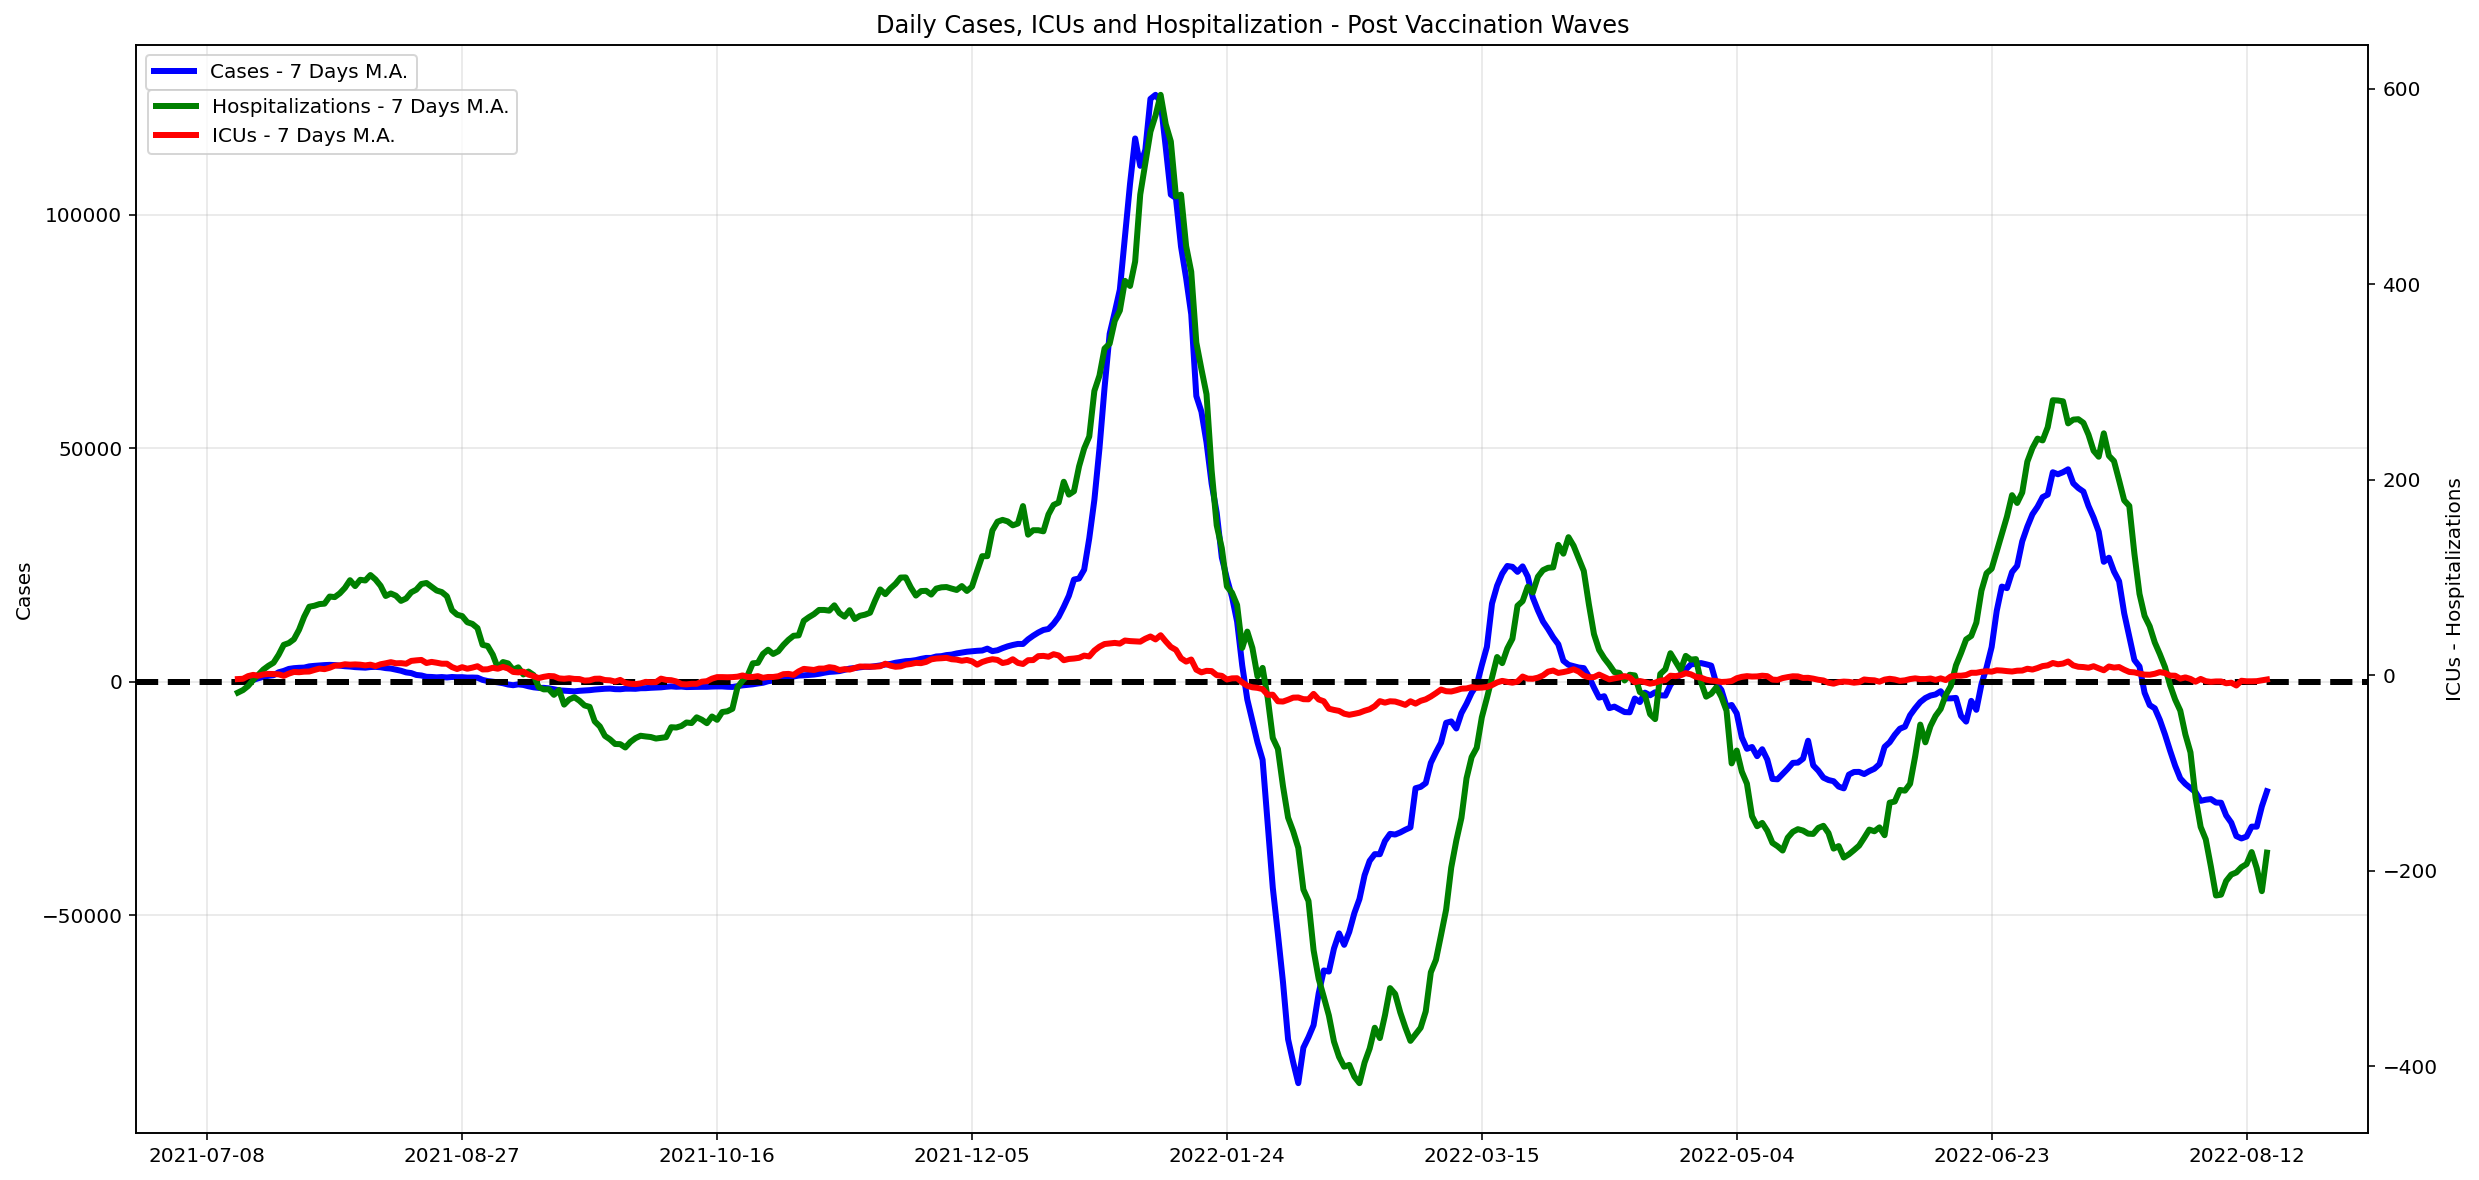

In [57]:
fig, ax = plt.subplots(figsize=(20,10))

cax = ax.twinx()
d_pos[500:].rolling(7).mean().plot(ax=ax, linewidth=3, c = 'b', label = 'Cases - 7 Days M.A.')
d_osp[500:].rolling(7).mean().plot(ax=cax, linewidth=3, c = 'g', label = 'Hospitalizations - 7 Days M.A.')
d_ti[500:].rolling(7).mean().plot(ax=cax, linewidth=3, c = 'r', label = 'ICUs - 7 Days M.A.')
_ = ax.axhline(0, c = 'k', linewidth = 3, linestyle = '--')
_ = ax.grid(alpha = .3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Cases')
_ = cax.set_ylabel('ICUs - Hospitalizations')
_ = ax.legend(loc = 'upper left')
_ = cax.legend(loc = (0.005, .9))
_ = ax.set_title('Daily Cases, ICUs and Hospitalization - Post Vaccination Waves')

In [58]:
start = ti.index[0]

ti['days_since_start'] = diff_dates(pd.to_datetime(start), pd.to_datetime(ti.index), days = True)
first_wave = ti.iloc[:round(ti.shape[0]/2)].reset_index()
second_wave = ti.iloc[-round(ti.shape[0]/2):].reset_index()

In [59]:
fw_start = first_wave.data[0]
sw_start = second_wave.data[0]
first_wave.days_since_start = diff_dates(pd.to_datetime(fw_start), pd.to_datetime(first_wave.data), days = True)
second_wave.days_since_start = diff_dates(pd.to_datetime(sw_start), pd.to_datetime(second_wave.data), days = True)

In [60]:
d_ti_fw = first_wave.terapia_intensiva.diff()
d_ti_sw = second_wave.terapia_intensiva.diff()

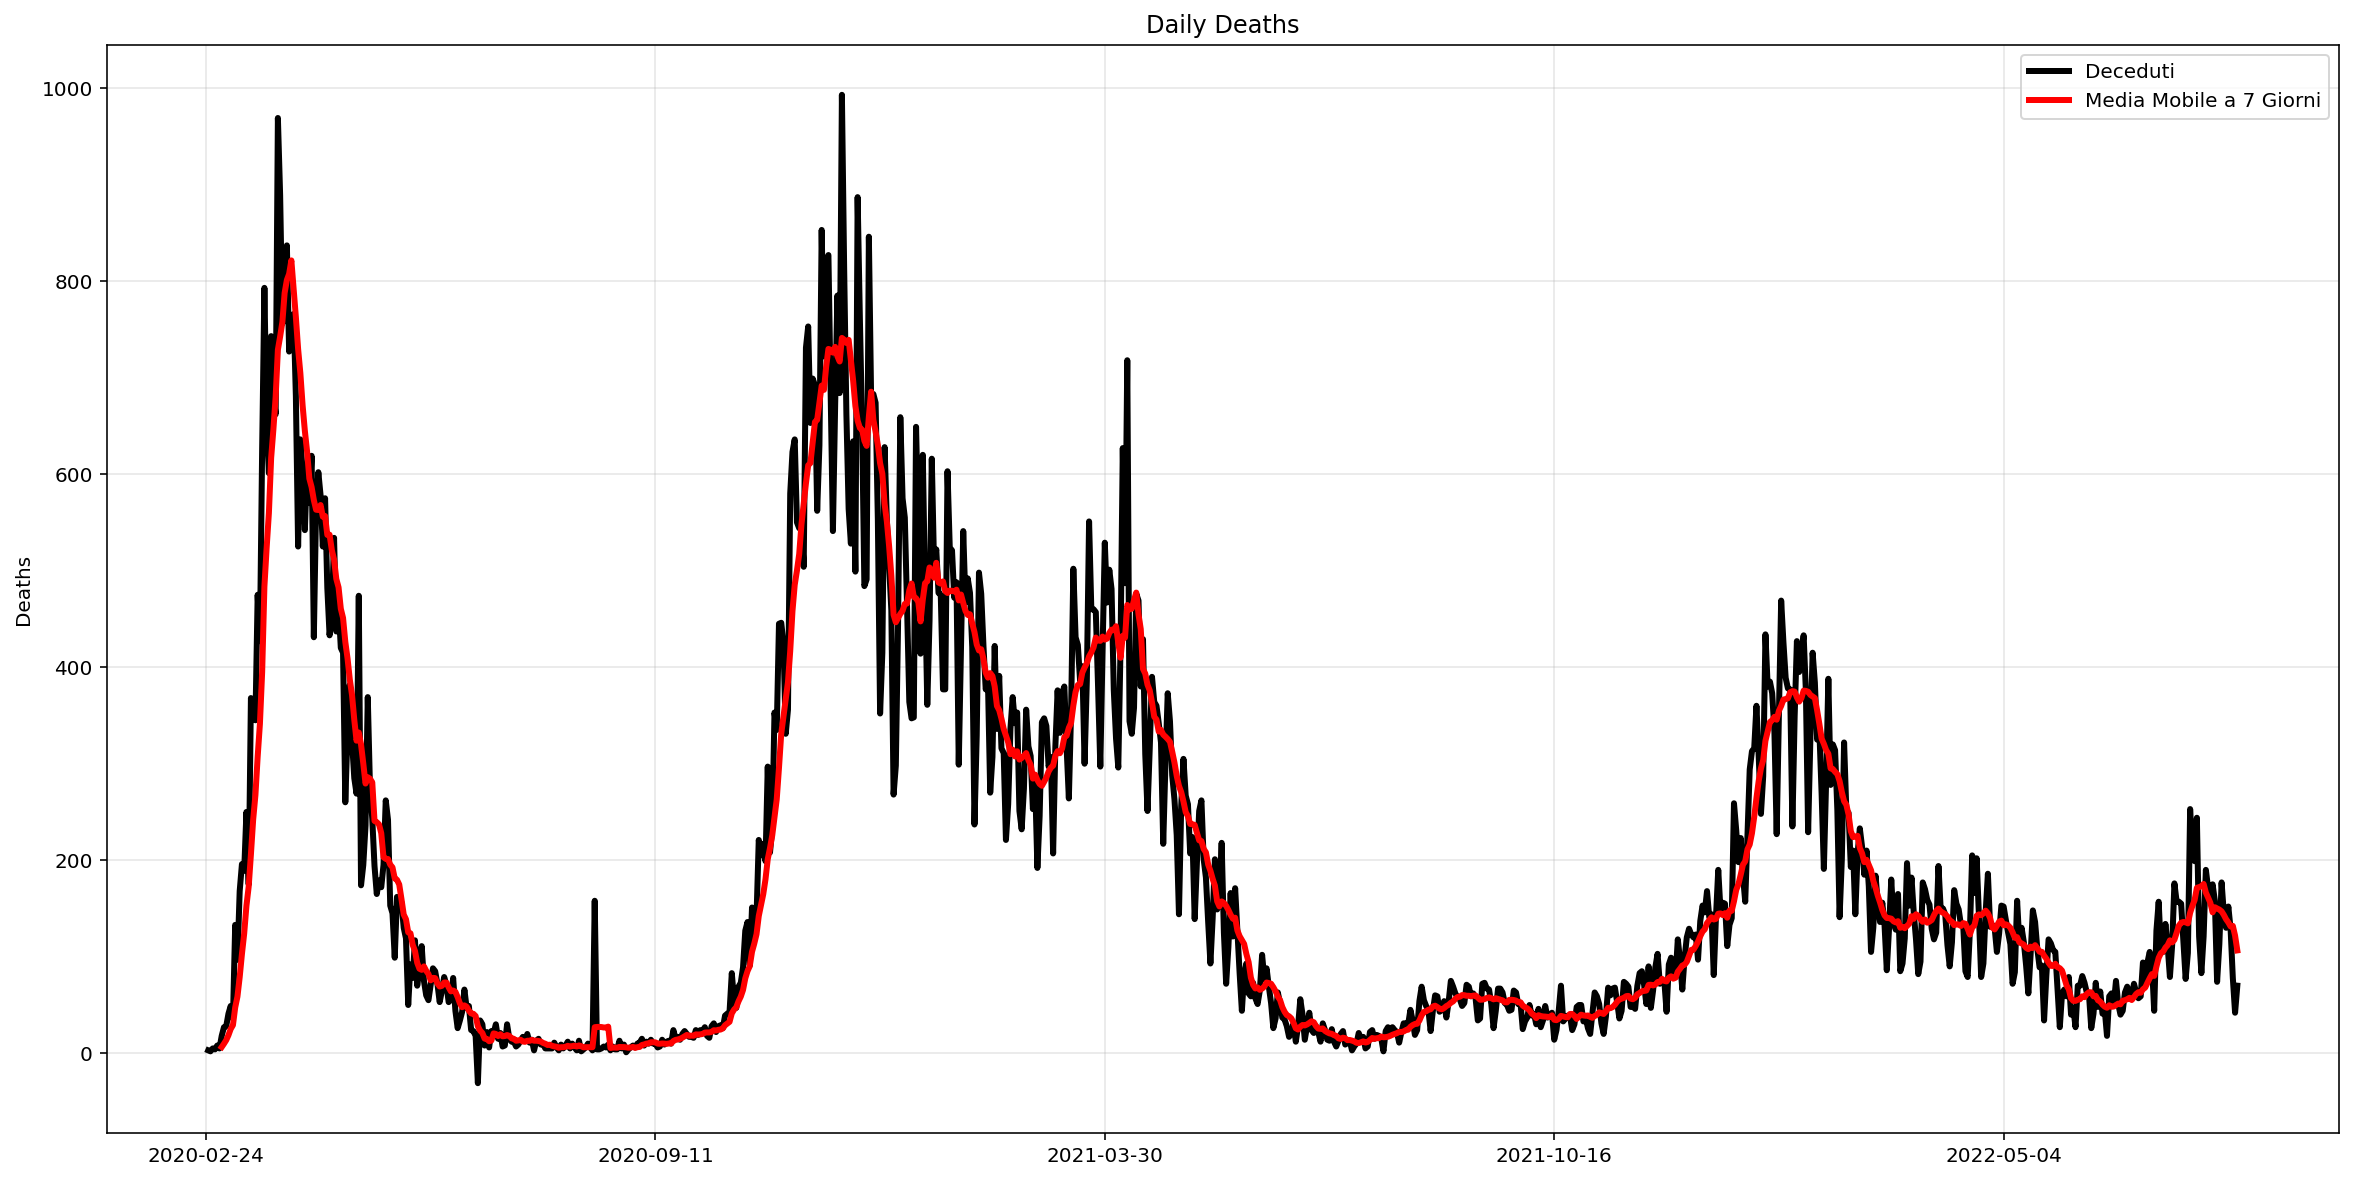

In [61]:
fig, ax = plt.subplots(figsize = (20,10))

ti.deceduti.diff().plot(ax = ax, c = 'k', linewidth = 3, label = 'Deceduti')
ti.deceduti.rolling(7).mean().diff().plot(ax = ax, c = 'r', linewidth = 3, label = 'Media Mobile a 7 Giorni')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Deaths')
_ = ax.set_title('Daily Deaths')

In [62]:
d_dec_fw = first_wave.deceduti.diff()
d_dec_sw = second_wave.deceduti.diff()

In [63]:
same_start = True

if same_start:
    y21 = y21[y21.days_since_start >= y21.days_since_start[54]]
    y21 = y21.reset_index(drop = True)
    y21.days_since_start = np.arange(len(y21))
    y21 = y21.set_index('data')

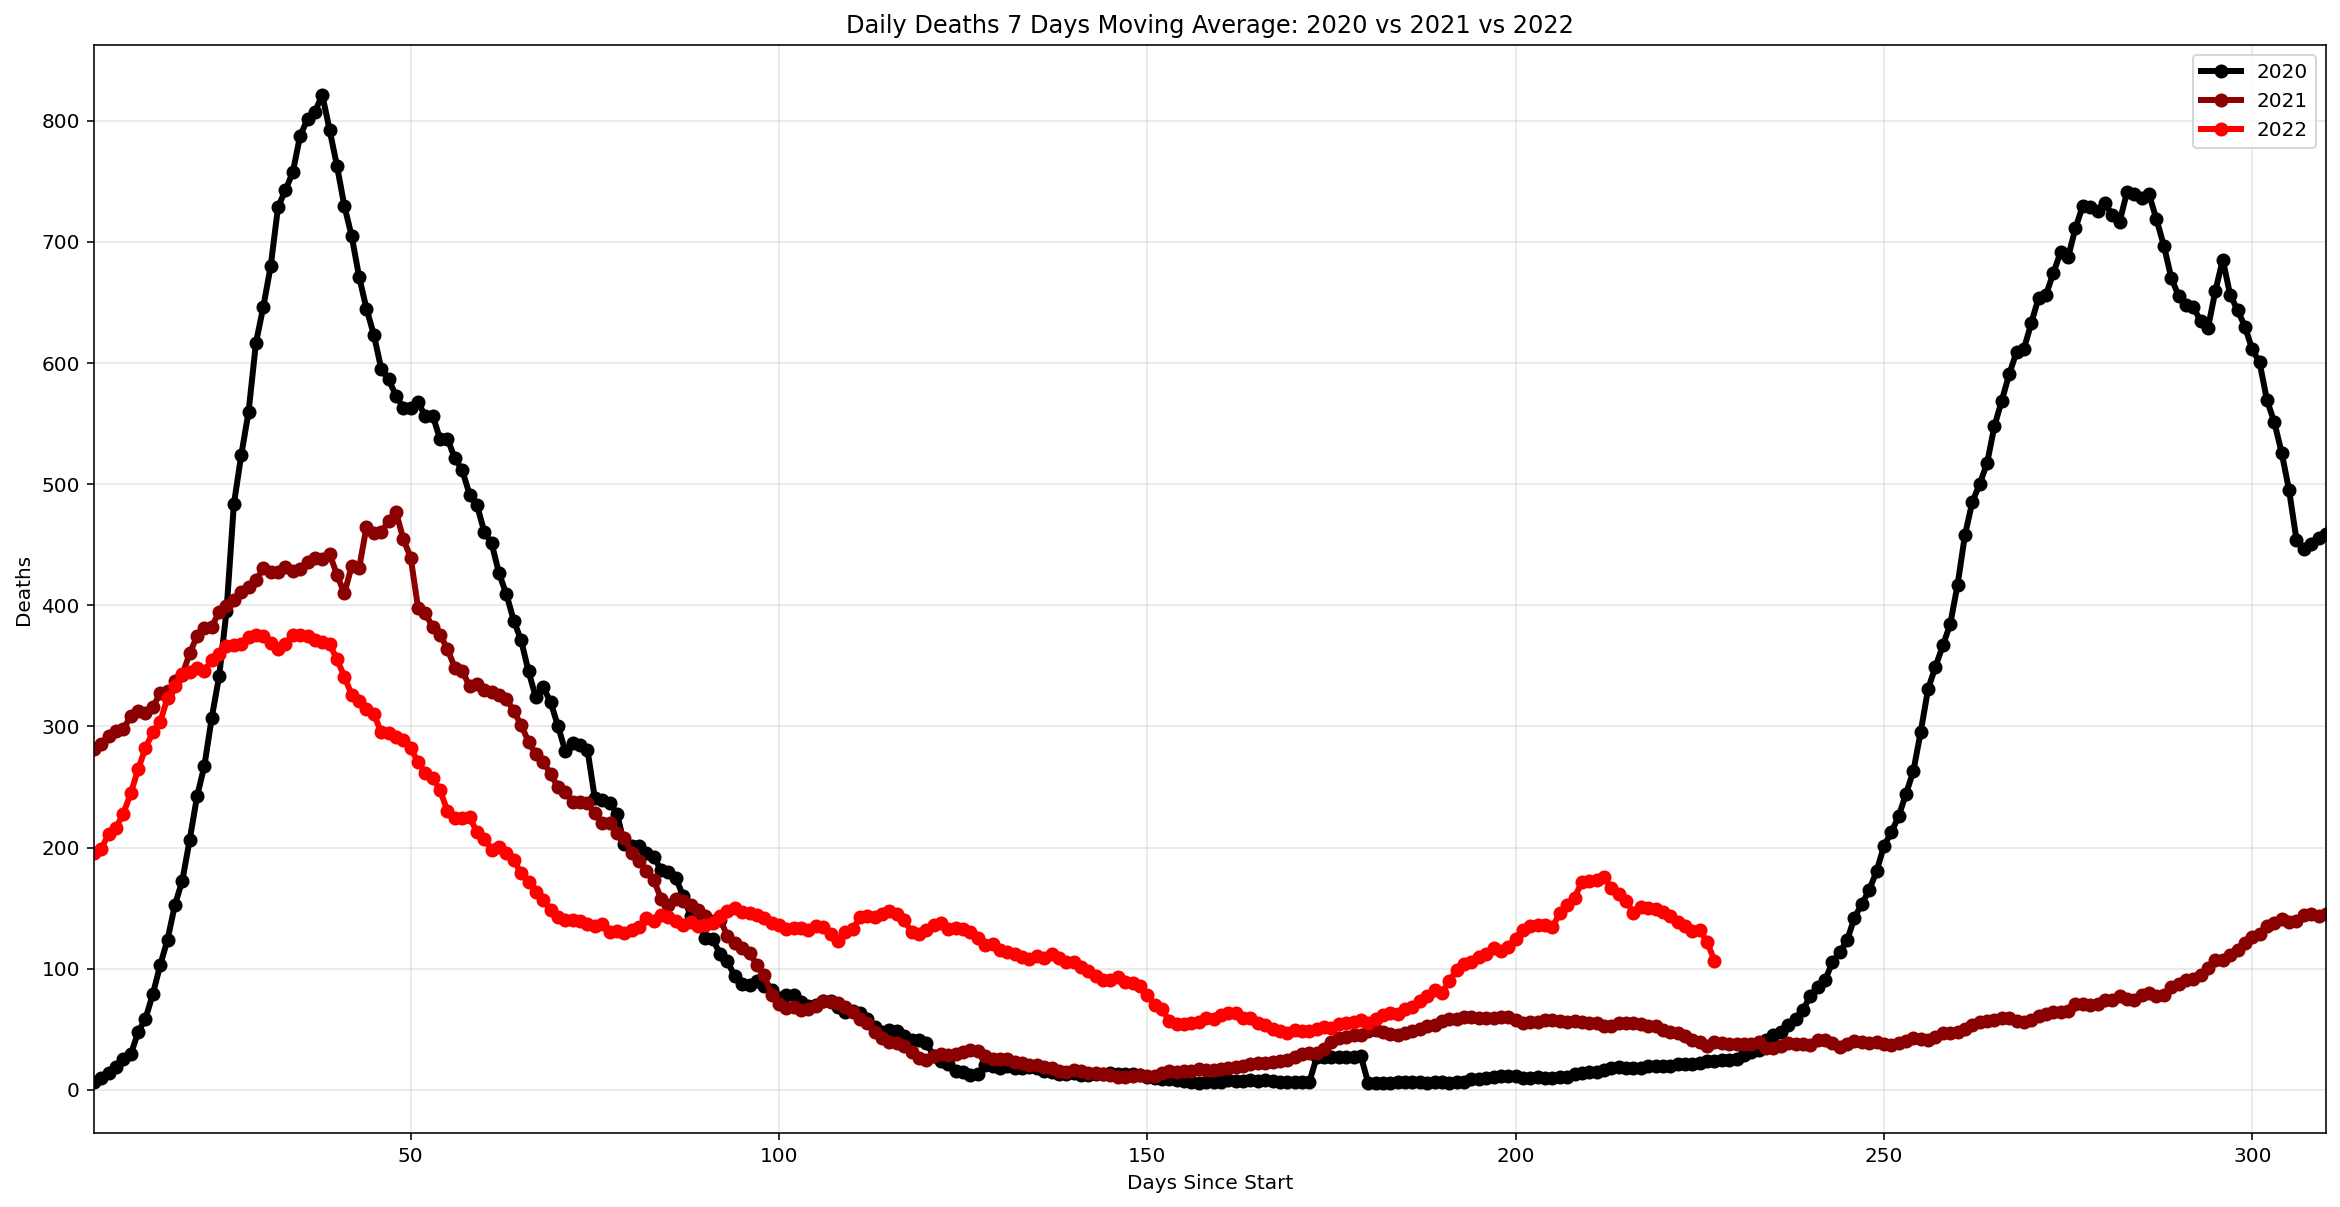

In [64]:
d_dec_fw = y20.deceduti.diff()
d_dec_sw = y21.deceduti.diff()
d_dec_tw = y22.deceduti.diff()

y21_end = y21.days_since_start[-1]
fig, ax = plt.subplots(figsize=(20,10))

d_dec_fw_rm = pd.Series(d_dec_fw).rolling(7).mean()
d_dec_sw_rm = pd.Series(d_dec_sw).rolling(7).mean()
d_dec_tw_rm = pd.Series(d_dec_tw).rolling(7).mean()
ax.plot(y20.days_since_start, d_dec_fw_rm, linewidth = 3, c = 'k', marker = 'o', label = '2020')
ax.plot(y21.days_since_start, d_dec_sw_rm, linewidth = 3, c = 'darkred', marker = 'o', label = '2021')
ax.plot(y22.days_since_start, d_dec_tw_rm, linewidth = 3, c = 'r', marker = 'o', label = '2022')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlim([7, y21.days_since_start[-1]])
_ = ax.set_xlabel('Days Since Start')
_ = ax.set_ylabel('Deaths')
_ = ax.set_title('Daily Deaths 7 Days Moving Average: 2020 vs 2021 vs 2022')

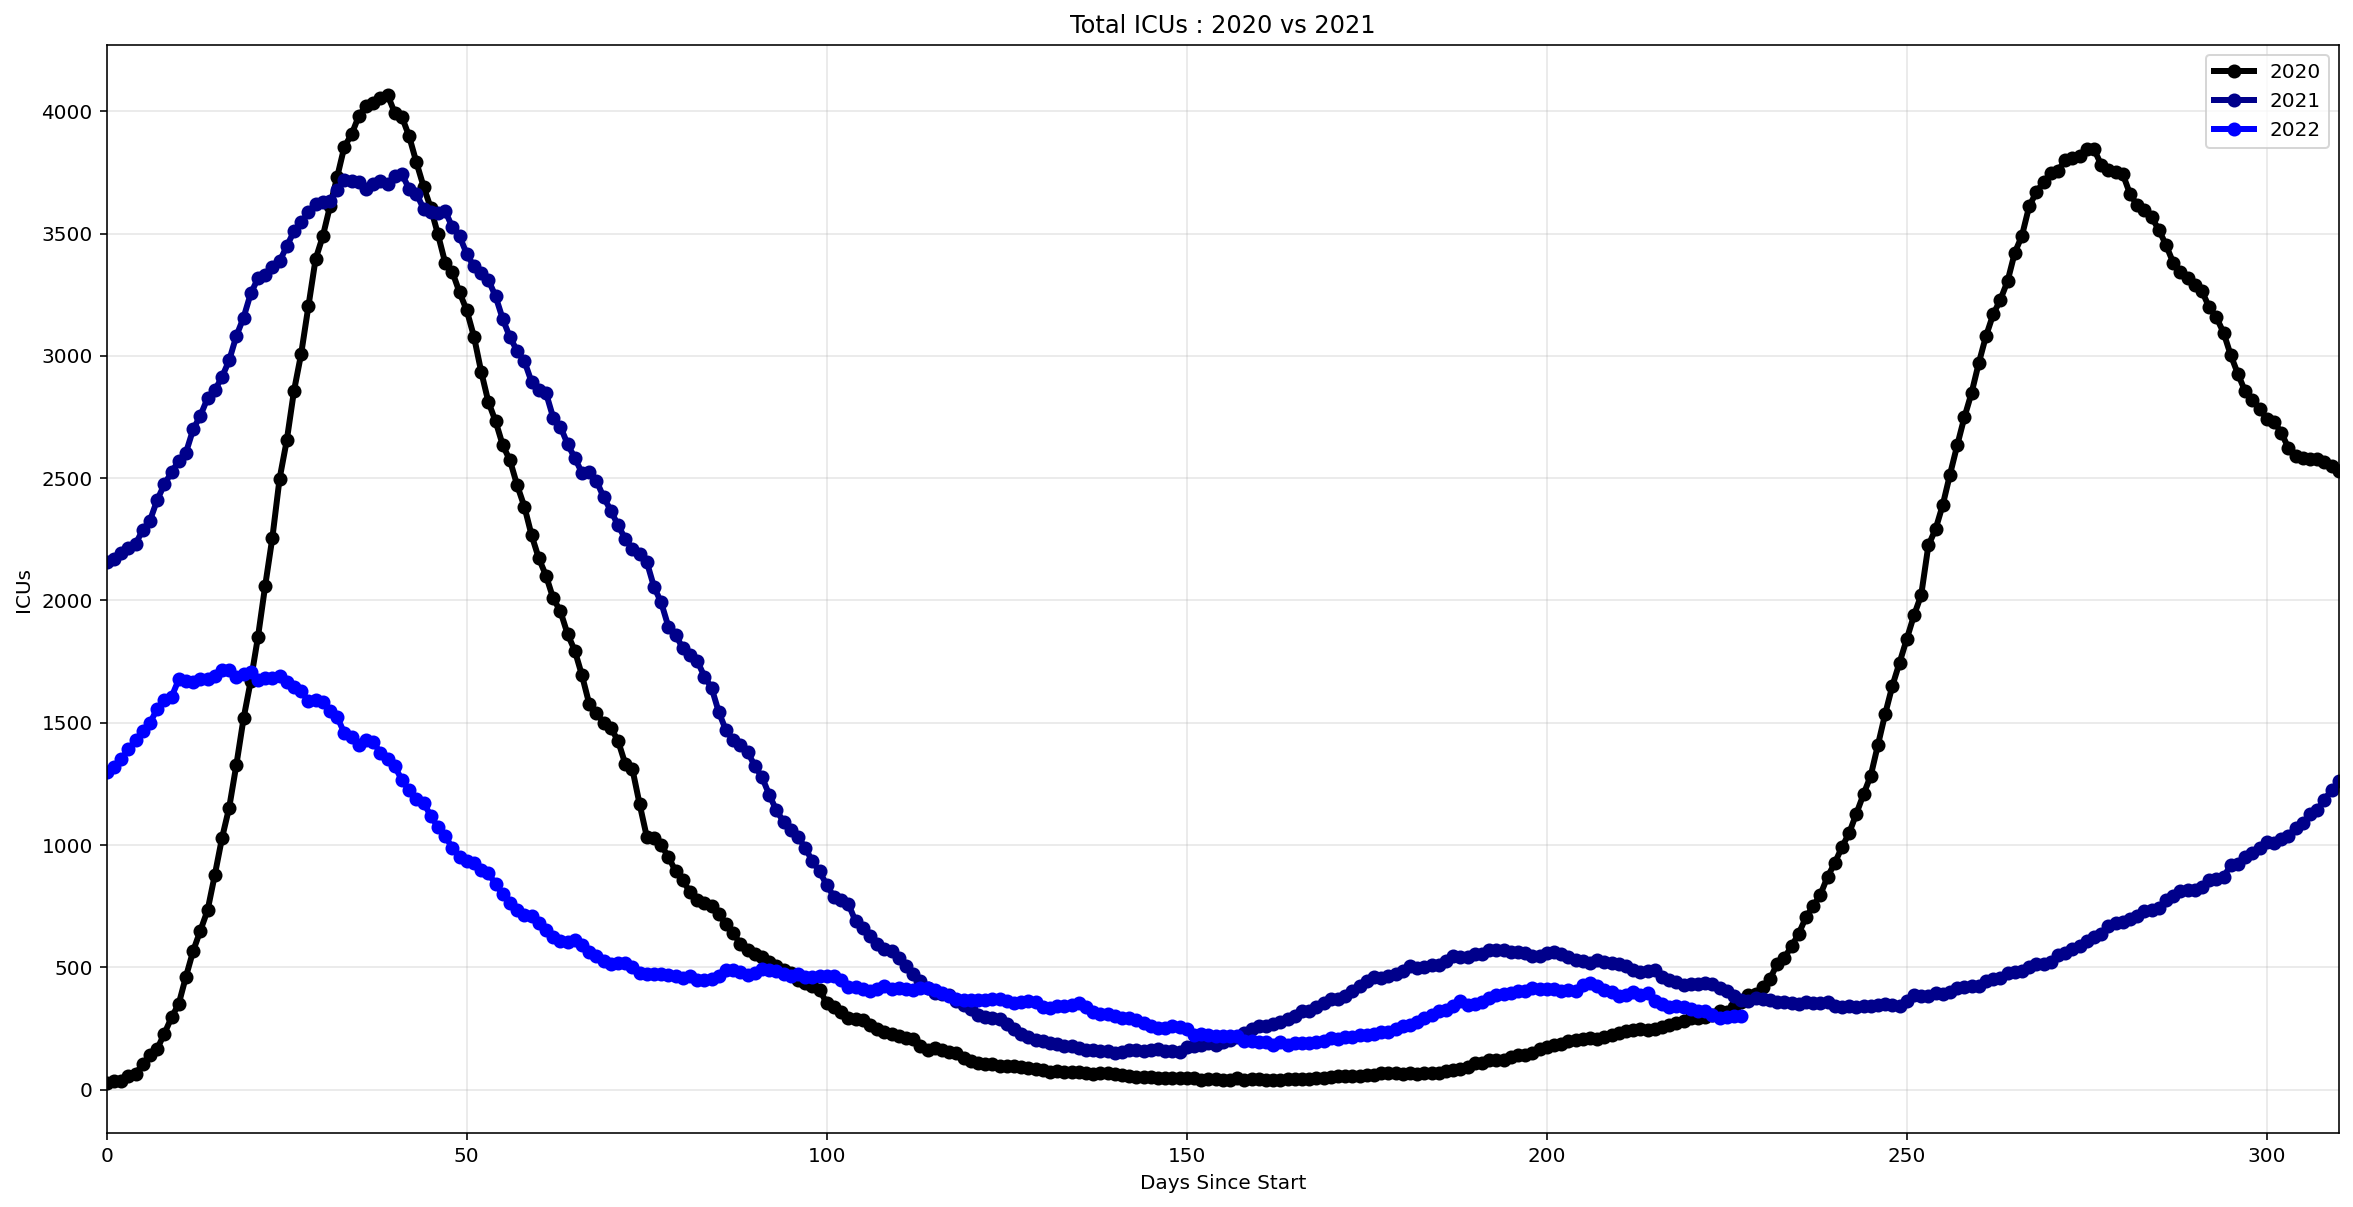

In [65]:
d_dec_fw = y20.terapia_intensiva
d_dec_sw = y21.terapia_intensiva
d_dec_tw = y22.terapia_intensiva

fig, ax = plt.subplots(figsize=(20,10))

d_dec_fw_rm = pd.Series(d_dec_fw)
d_dec_sw_rm = pd.Series(d_dec_sw)
d_dec_tw_rm = pd.Series(d_dec_tw)
ax.plot(y20.days_since_start, d_dec_fw_rm, linewidth = 3, c = 'k', marker = 'o', label = '2020')
ax.plot(y21.days_since_start, d_dec_sw_rm, linewidth = 3, c = 'darkblue', marker = 'o', label = '2021')
ax.plot(y22.days_since_start, d_dec_tw_rm, linewidth = 3, c = 'b', marker = 'o', label = '2022')
# _ = ax.fill_between(y21.days_since_start, d_dec_fw_rm[:y21_end+1], d_dec_sw_rm, color = 'b', alpha=.4, label = 'Differenza Tassi di Crescita')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlim([0, y21.days_since_start[-1]])
_ = ax.set_xlabel('Days Since Start')
_ = ax.set_ylabel('ICUs')
_ = ax.set_title('Total ICUs : 2020 vs 2021')

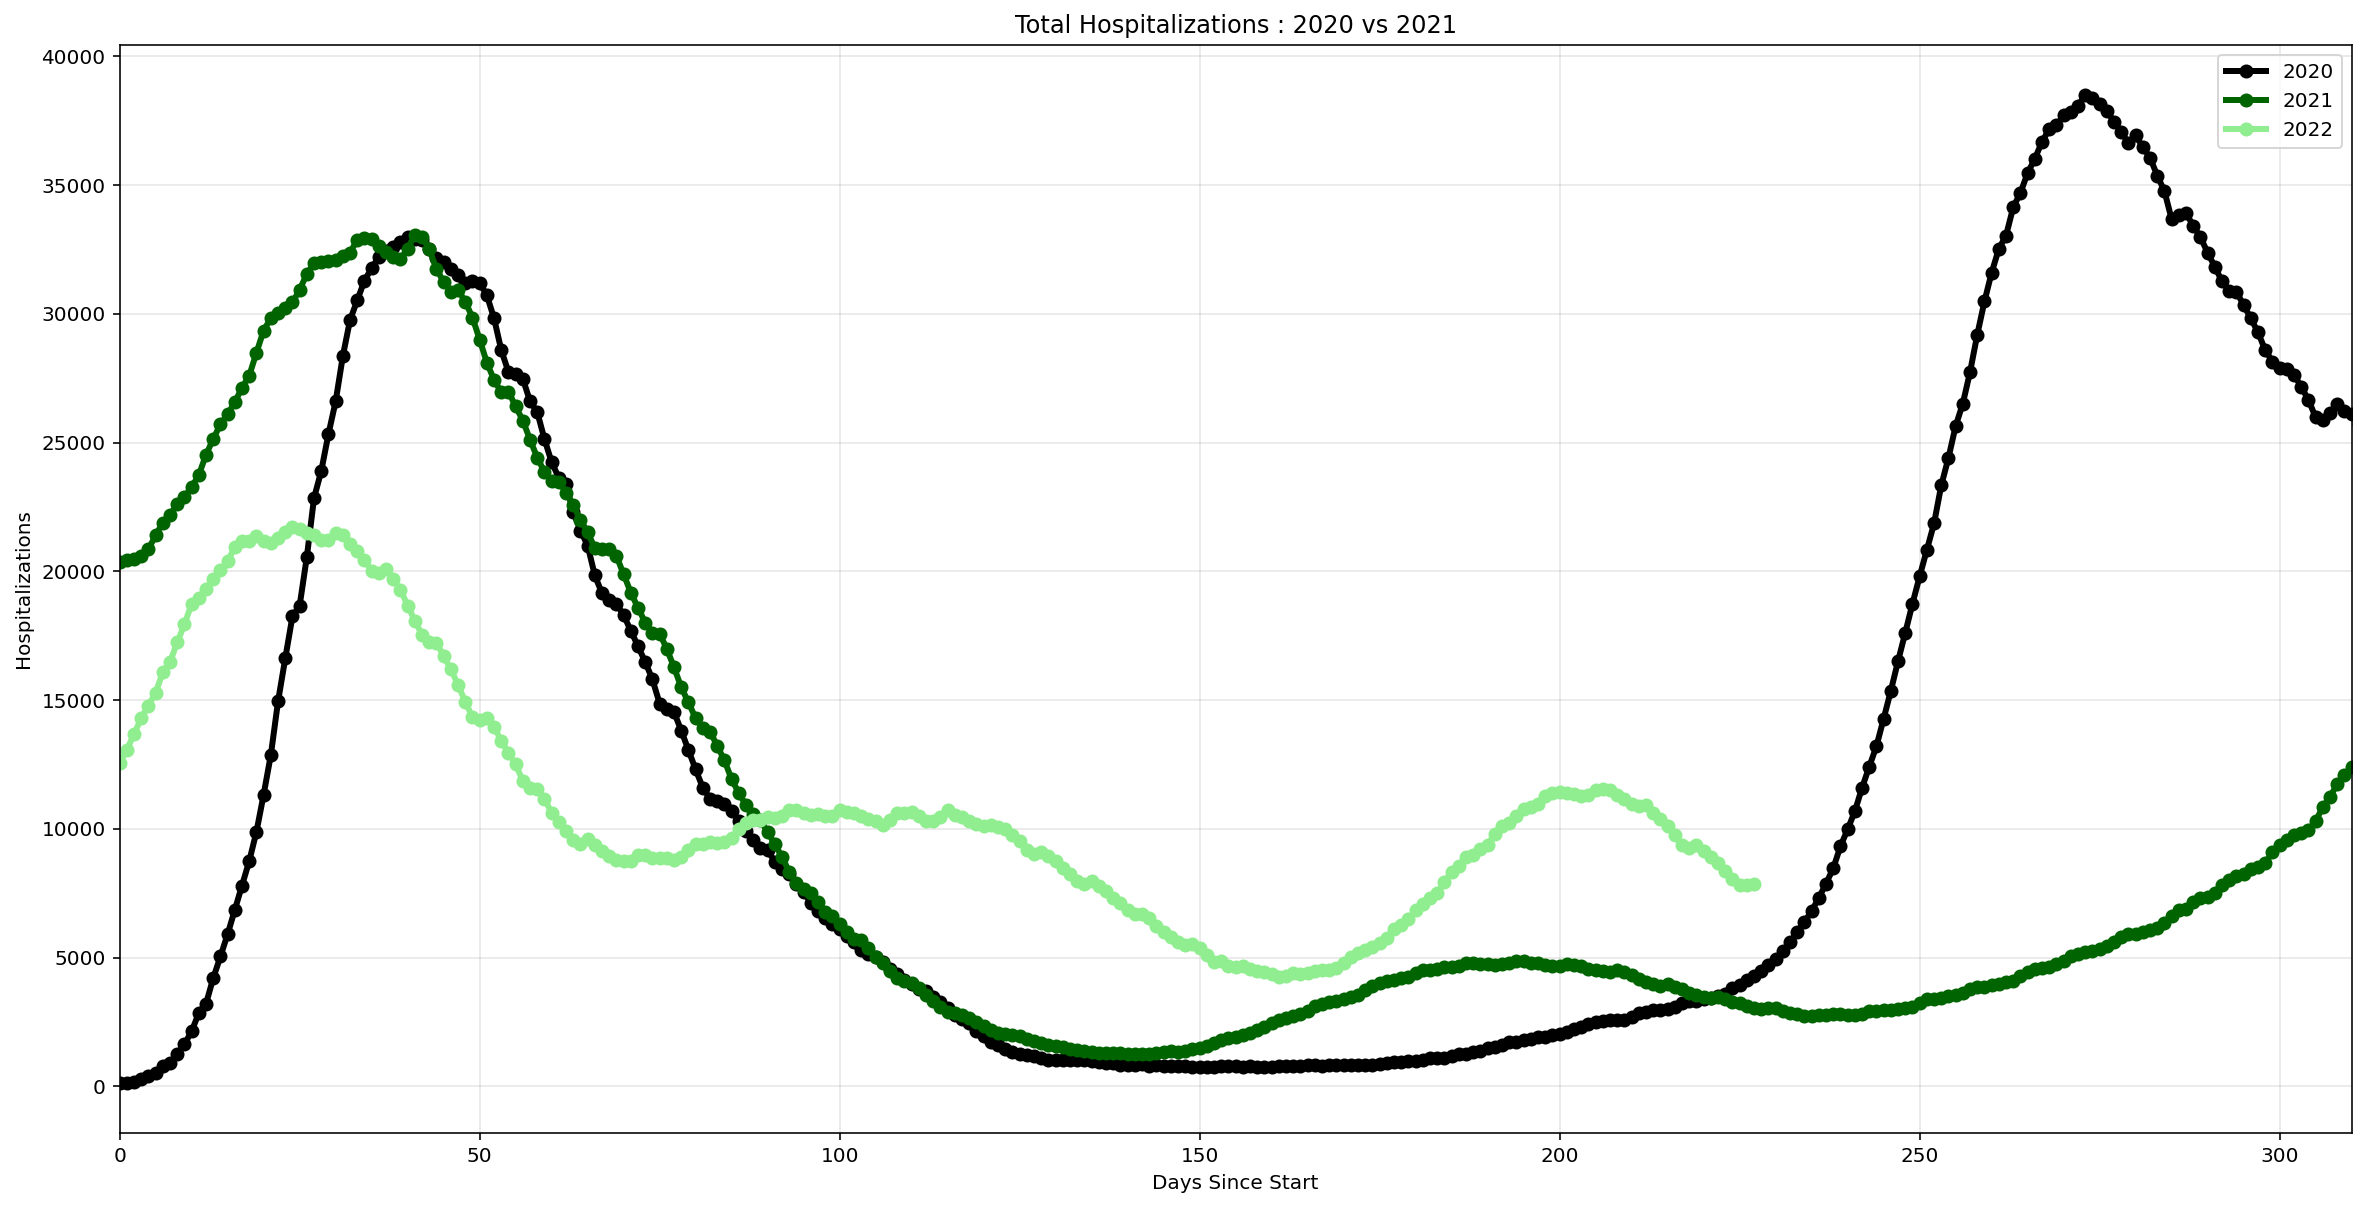

In [66]:
d_dec_fw = y20.ospedalizzati
d_dec_sw = y21.ospedalizzati
d_dec_tw = y22.ospedalizzati

fig, ax = plt.subplots(figsize=(20,10))

d_dec_fw_rm = pd.Series(d_dec_fw)
d_dec_sw_rm = pd.Series(d_dec_sw)
d_dec_tw_rm = pd.Series(d_dec_tw)
ax.plot(y20.days_since_start, d_dec_fw_rm, linewidth = 3, c = 'k', marker = 'o', label = '2020')
ax.plot(y21.days_since_start, d_dec_sw_rm, linewidth = 3, c = 'darkgreen', marker = 'o', label = '2021')
ax.plot(y22.days_since_start, d_dec_tw_rm, linewidth = 3, c = 'lightgreen', marker = 'o', label = '2022')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlim([0, y21.days_since_start[-1]])
_ = ax.set_xlabel('Days Since Start')
_ = ax.set_ylabel('Hospitalizations')
_ = ax.set_title('Total Hospitalizations : 2020 vs 2021')

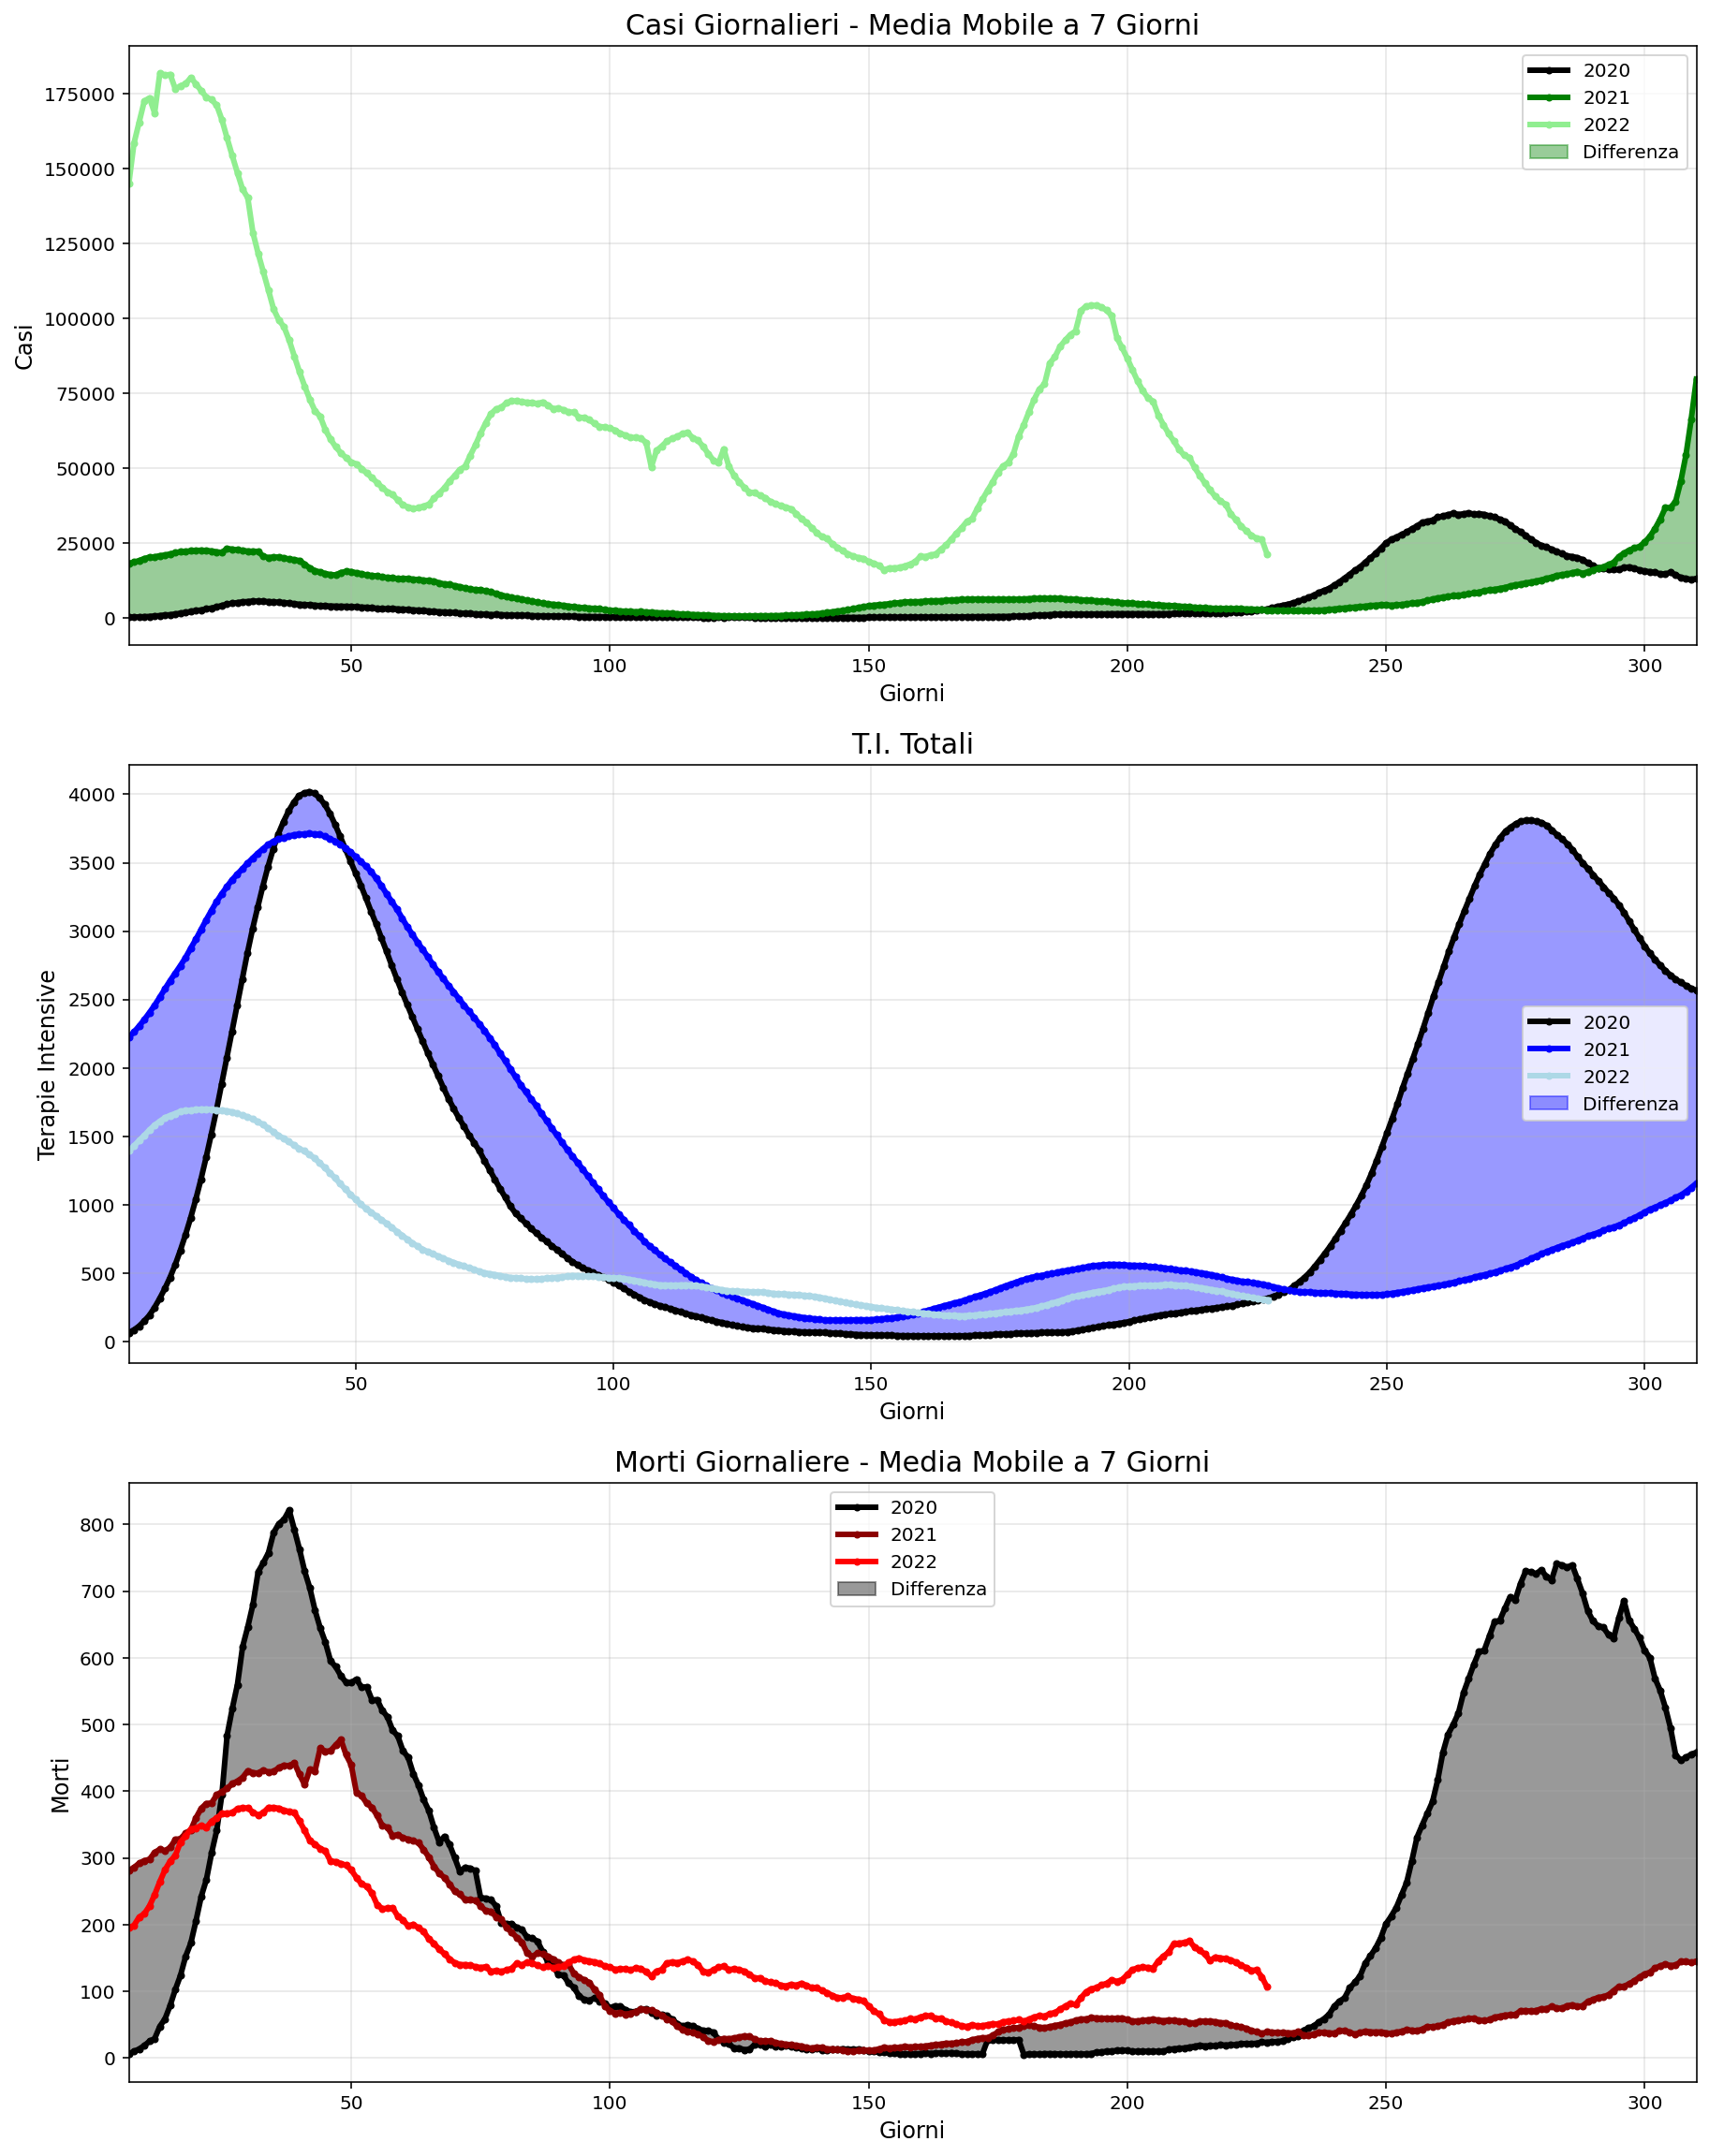

In [67]:
fig, ax = plt.subplots(3,1, figsize = (15, 20))

d_casi_fw = y20.totale_casi.diff().rolling(7).mean()
d_casi_sw = y21.totale_casi.diff().rolling(7).mean()
d_casi_tw = y22.totale_casi.diff().rolling(7).mean()

d_ti_fw = y20.terapia_intensiva
d_ti_sw = y21.terapia_intensiva
d_ti_tw = y22.terapia_intensiva

d_dec_fw = y20.deceduti.diff()
d_dec_sw = y21.deceduti.diff()
d_dec_tw = y22.deceduti.diff()

d_dec_fw_rm = pd.Series(d_dec_fw).rolling(7).mean()
d_dec_sw_rm = pd.Series(d_dec_sw).rolling(7).mean()
d_dec_tw_rm = pd.Series(d_dec_tw).rolling(7).mean()

d_ti_fw_rm = pd.Series(d_ti_fw).rolling(7).mean()
d_ti_sw_rm = pd.Series(d_ti_sw).rolling(7).mean()
d_ti_tw_rm = pd.Series(d_ti_tw).rolling(7).mean()

ax[0].plot(y20.days_since_start, d_casi_fw, linewidth = 3, c = 'k', marker = '.', label = '2020')
ax[0].plot(y21.days_since_start, d_casi_sw, linewidth = 3, c = 'green', marker = '.', label = '2021')
ax[0].plot(y22.days_since_start, d_casi_tw, linewidth = 3, c = 'lightgreen', marker = '.', label = '2022')
ax[1].plot(y20.days_since_start, d_ti_fw_rm, linewidth = 3, c = 'k', marker = '.', label = '2020')
ax[1].plot(y21.days_since_start, d_ti_sw_rm, linewidth = 3, c = 'b', marker = '.', label = '2021')
ax[1].plot(y22.days_since_start, d_ti_tw_rm, linewidth = 3, c = 'lightblue', marker = '.', label = '2022')
ax[2].plot(y20.days_since_start, d_dec_fw_rm, linewidth = 3, c = 'k', marker = '.', label = '2020')
ax[2].plot(y21.days_since_start, d_dec_sw_rm, linewidth = 3, c = 'darkred', marker = '.', label = '2021')
ax[2].plot(y22.days_since_start, d_dec_tw_rm, linewidth = 3, c = 'r', marker = '.', label = '2022')
_ = ax[0].fill_between(y21.days_since_start, d_casi_fw[:y21_end+1], d_casi_sw, color='green', alpha=.4, label='Differenza')
_ = ax[1].fill_between(y21.days_since_start, d_ti_fw_rm[:y21_end+1], d_ti_sw_rm, color='b', alpha=.4, label='Differenza')
_ = ax[2].fill_between(y21.days_since_start, d_dec_fw_rm[:y21_end+1], d_dec_sw_rm, color='k', alpha=.4, label='Differenza')
_, _, _ = ax[0].grid(alpha = .3), ax[1].grid(alpha = .3), ax[2].grid(alpha = .3)
_, _, _ = ax[0].legend(), ax[1].legend(), ax[2].legend()
_ = ax[0].set_xlim([7, y21.days_since_start[-1]])
_, _ = ax[1].set_xlim([6, y21.days_since_start[-1]]), ax[2].set_xlim([7, y21.days_since_start[-1]])
_, _, _ = ax[0].set_xlabel('Giorni', fontsize = 12), ax[1].set_xlabel('Giorni', fontsize = 12), ax[2].set_xlabel('Giorni', fontsize = 12)
_, _, _ = ax[0].set_ylabel('Casi',fontsize = 12), ax[1].set_ylabel('Terapie Intensive', fontsize = 12), ax[2].set_ylabel('Morti', fontsize = 12)
_ = ax[0].set_title('Casi Giornalieri - Media Mobile a 7 Giorni', fontsize = 15)
_, _ = ax[1].set_title('T.I. Totali', fontsize = 15), ax[2].set_title(
    'Morti Giornaliere - Media Mobile a 7 Giorni', fontsize = 15
)

_ = fig.savefig('waves_comparison.png')